# Setting Up and Cleaning the Initial Lab Blood Sample Data

## Setup & Data Load

**What this cell does**
- Imports core libraries: pandas, numpy, matplotlib; scikit-learn helpers; TensorFlow/Keras.
- Sets a fixed random seed for reproducible results.
- Increases default figure size so plots are readable.
- Loads `LabTUH4.xlsx` into a DataFrame named `data`.
- Runs `data.describe()` to quickly profile numeric columns (counts, mean, std, quartiles, min/max) and spot scale issues/outliers.

**Why this matters**
- Ensures a repeatable environment and confirms the dataset is correctly loaded before any preprocessing or modeling.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import*
from sklearn import*
import tensorflow as tf
from tensorflow import keras
import numpy as np


# sklearn encoding, data preparation and evaluation tools
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# Keras (2.X on - I used 2.7 but the below should work for any version.)
from tensorflow import keras
from tensorflow.keras.layers import Dense, SpatialDropout3D
from tensorflow.keras.models import Sequential

seed = 1
# fix random seed for reproducibility, makes sure that you are able to compare with the same weights
np.random.seed(seed)

# Some matplotlib figure sizes
plt.rcParams["figure.figsize"] = (12,8)


data = pd.read_excel("LabTUH4.xlsx")


data.describe()

,DateSampleTaken,DateReceivedLab,DateResultReported,DistanceFromTUH_KM,Haemolysis
count,9922,9922,9922,9922.000000,9922.000000
mean,2023-01-28 01:09:13.678693888,2023-01-28 01:18:39.693609984,2023-01-29 03:54:49.417456128,5.098912,12.269804
min,2023-01-03 00:00:00,2023-01-03 00:00:00,2023-01-03 00:00:00,0.500000,0.000000
25%,2023-01-13 00:00:00,2023-01-13 00:00:00,2023-01-14 00:00:00,3.000000,4.000000
50%,2023-01-24 00:00:00,2023-01-24 00:00:00,2023-01-25 00:00:00,5.900000,7.000000
75%,2023-02-09 00:00:00,2023-02-09 00:00:00,2023-02-10 00:00:00,6.500000,11.000000
max,2023-04-28 00:00:00,2023-04-28 00:00:00,2023-05-02 00:00:00,11.200000,788.000000
std,NaN,NaN,NaN,2.430079,28.373708


In [ ]:
print(data.describe())

print("\n\n Missing values (?)")
print((data == '?').sum())

# Converting missing data to NaN
data.replace('?', np.nan, inplace=True)

# here we are dropping the NaN values, this is not ideal, and you will be asked questions on this later
data.dropna(inplace=True)

print("\n\n Missing values (?) after del")
print((data == '?').sum())


                     DateSampleTaken                DateReceivedLab  \
count                           9922                           9922   
mean   2023-01-28 01:09:13.678693888  2023-01-28 01:18:39.693609984   
min              2023-01-03 00:00:00            2023-01-03 00:00:00   
25%              2023-01-13 00:00:00            2023-01-13 00:00:00   
50%              2023-01-24 00:00:00            2023-01-24 00:00:00   
75%              2023-02-09 00:00:00            2023-02-09 00:00:00   
max              2023-04-28 00:00:00            2023-04-28 00:00:00   
std                              NaN                            NaN   

                  DateResultReported  DistanceFromTUH_KM   Haemolysis  
count                           9922         9922.000000  9922.000000  
mean   2023-01-29 03:54:49.417456128            5.098912    12.269804  
min              2023-01-03 00:00:00            0.500000     0.000000  
25%              2023-01-14 00:00:00            3.000000     4.000000  


In [ ]:
data.describe()

,DateSampleTaken,DateReceivedLab,DateResultReported,DistanceFromTUH_KM,Haemolysis
count,9890,9890,9890,9890.000000,9890.000000
mean,2023-01-28 00:58:05.702729984,2023-01-28 01:07:33.549039360,2023-01-29 03:44:31.061678336,5.097856,12.269464
min,2023-01-03 00:00:00,2023-01-03 00:00:00,2023-01-03 00:00:00,0.500000,0.000000
25%,2023-01-13 00:00:00,2023-01-13 00:00:00,2023-01-14 00:00:00,3.000000,4.000000
50%,2023-01-24 00:00:00,2023-01-24 00:00:00,2023-01-25 00:00:00,5.900000,7.000000
75%,2023-02-09 00:00:00,2023-02-09 00:00:00,2023-02-10 00:00:00,6.500000,11.000000
max,2023-04-28 00:00:00,2023-04-28 00:00:00,2023-05-02 00:00:00,11.200000,788.000000
std,NaN,NaN,NaN,2.429611,28.407678


## Date–Time Cleanup, Timestamp Construction & Transit-Time Imputation

### 1) Normalize raw dates/times
- Parse **DateSampleTaken** and **DateReceivedLab** to pandas `datetime` with `errors='coerce'` so any bad entries become `NaT` (won’t crash the run).
- Parse clock fields (**TimeSampleTaken**, **TimeReceivedLab**, **TimeResultReported**) using the expected `%H:%M:%S` format.

**Why:** ensures consistent, machine-readable time fields for later duration calculations.

---

### 2) Build unified event timestamps
- Convert time objects to strings and **concatenate Date + Time** to create:
  - **DatetimeSampleTaken**
  - **DatetimeReceivedLab**
  - **DatetimeResultReported**

**Why:** full timestamps let us compute intervals across steps in the workflow (e.g., GP → Lab → Report).

---

### 3) Sanity checks
- Print `dtypes` and a few rows to confirm parsing worked.
- Display the original date/time columns alongside the new combined datetimes to visually verify alignment.

**Why:** early verification catches format issues and unexpected `NaT`s.

---

### 4) Validate & fix GP→Lab transit minutes
- Count rows where **MinutesFromGPtoLab ≤ 0** (non-physical or placeholder values).
- Compute the **median** of positive values and **impute** invalid entries with this median.

**Why:** median is robust to skew/outliers and yields plausible times without leaking target information.


In [ ]:
# Convert 'Date_Sample_taken' to datetime format
data['DateSampleTaken'] = pd.to_datetime(data['DateSampleTaken'], errors='coerce')
data['DateReceivedLab'] = pd.to_datetime(data['DateReceivedLab'], errors='coerce')


# Convert 'Time_Recorded', 'Time_of_Technical_Validation', and 'Time_of_Clinical_Validation' to time format
data['TimeSampleTaken'] = pd.to_datetime(data['TimeSampleTaken'], format='%H:%M:%S', errors='coerce').dt.time
data['TimeReceivedLab'] = pd.to_datetime(data['TimeReceivedLab'], format='%H:%M:%S', errors='coerce').dt.time
data['TimeResultReported'] = pd.to_datetime(data['TimeResultReported'], format='%H:%M:%S', errors='coerce').dt.time

# Check the types and a few rows to ensure everything is correctly formatted
print(data.dtypes)
print(data.head())


DateSampleTaken       datetime64[ns]
TimeSampleTaken               object
DateReceivedLab       datetime64[ns]
TimeReceivedLab               object
DateResultReported    datetime64[ns]
TimeResultReported            object
GP                            object
DistanceFromTUH_KM           float64
Potassium_mmol/L              object
Haemolysis                     int64
dtype: object
  DateSampleTaken TimeSampleTaken DateReceivedLab TimeReceivedLab  \
0      2023-02-13        18:22:00      2023-02-13        18:22:00   
1      2023-02-09        11:00:00      2023-02-09        16:50:00   
2      2023-01-17        09:45:00      2023-01-17        15:56:00   
3      2023-01-11        16:16:00      2023-01-11        16:47:00   
4      2023-01-23        12:44:00      2023-01-23        14:01:00   

  DateResultReported TimeResultReported    GP  DistanceFromTUH_KM  \
0         2023-02-15           09:18:00  GP51                 1.3   
1         2023-02-10           14:19:00  GP01                 1

In [ ]:
# Convert 'TimeSampleTaken', 'TimeReceivedLab', and 'TimeResultReported' to string format
data['TimeSampleTaken'] = data['TimeSampleTaken'].astype(str)
data['TimeReceivedLab'] = data['TimeReceivedLab'].astype(str)
data['TimeResultReported'] = data['TimeResultReported'].astype(str)

# Combine 'DateSampleTaken' and 'TimeSampleTaken' into a single datetime column
data['DatetimeSampleTaken'] = pd.to_datetime(data['DateSampleTaken'].astype(str) + ' ' + data['TimeSampleTaken'], errors='coerce')

# Combine 'DateReceivedLab' and 'TimeReceivedLab' into a single datetime column
data['DatetimeReceivedLab'] = pd.to_datetime(data['DateReceivedLab'].astype(str) + ' ' + data['TimeReceivedLab'], errors='coerce')

# Combine 'DateResultReported' and 'TimeResultReported' into a single datetime column
data['DatetimeResultReported'] = pd.to_datetime(data['DateResultReported'].astype(str) + ' ' + data['TimeResultReported'], errors='coerce')

# Check the results to ensure the new datetime columns are created correctly
print(data[['DateSampleTaken', 'TimeSampleTaken', 'DatetimeSampleTaken',
            'DateReceivedLab', 'TimeReceivedLab', 'DatetimeReceivedLab',
            'DateResultReported', 'TimeResultReported', 'DatetimeResultReported']].head())


  DateSampleTaken TimeSampleTaken DatetimeSampleTaken DateReceivedLab  \
0      2023-02-13        18:22:00 2023-02-13 18:22:00      2023-02-13   
1      2023-02-09        11:00:00 2023-02-09 11:00:00      2023-02-09   
2      2023-01-17        09:45:00 2023-01-17 09:45:00      2023-01-17   
3      2023-01-11        16:16:00 2023-01-11 16:16:00      2023-01-11   
4      2023-01-23        12:44:00 2023-01-23 12:44:00      2023-01-23   

  TimeReceivedLab DatetimeReceivedLab DateResultReported TimeResultReported  \
0        18:22:00 2023-02-13 18:22:00         2023-02-15           09:18:00   
1        16:50:00 2023-02-09 16:50:00         2023-02-10           14:19:00   
2        15:56:00 2023-01-17 15:56:00         2023-01-18           15:31:00   
3        16:47:00 2023-01-11 16:47:00         2023-01-12           12:18:00   
4        14:01:00 2023-01-23 14:01:00         2023-01-23           15:26:00   

  DatetimeResultReported  
0    2023-02-15 09:18:00  
1    2023-02-10 14:19:00  
2    

In [ ]:
data.head(10)

,DateSampleTaken,TimeSampleTaken,DateReceivedLab,TimeReceivedLab,DateResultReported,TimeResultReported,GP,DistanceFromTUH_KM,Potassium_mmol/L,Haemolysis,DatetimeSampleTaken,DatetimeReceivedLab,DatetimeResultReported
0,2023-02-13,18:22:00,2023-02-13,18:22:00,2023-02-15,09:18:00,GP51,1.3,4.2,3,2023-02-13 18:22:00,2023-02-13 18:22:00,2023-02-15 09:18:00
1,2023-02-09,11:00:00,2023-02-09,16:50:00,2023-02-10,14:19:00,GP01,1.1,3.8,6,2023-02-09 11:00:00,2023-02-09 16:50:00,2023-02-10 14:19:00
2,2023-01-17,09:45:00,2023-01-17,15:56:00,2023-01-18,15:31:00,GP33,6.5,3.9,4,2023-01-17 09:45:00,2023-01-17 15:56:00,2023-01-18 15:31:00
3,2023-01-11,16:16:00,2023-01-11,16:47:00,2023-01-12,12:18:00,GP10,5.7,4.8,11,2023-01-11 16:16:00,2023-01-11 16:47:00,2023-01-12 12:18:00
4,2023-01-23,12:44:00,2023-01-23,14:01:00,2023-01-23,15:26:00,GP40,7.8,4.3,36,2023-01-23 12:44:00,2023-01-23 14:01:00,2023-01-23 15:26:00
5,2023-02-17,12:27:00,2023-02-17,12:27:00,2023-02-20,10:11:00,GP58,5.5,6.2,5,2023-02-17 12:27:00,2023-02-17 12:27:00,2023-02-20 10:11:00
6,2023-01-11,16:07:00,2023-01-11,16:47:00,2023-01-12,08:54:00,GP31,2.4,3.9,6,2023-01-11 16:07:00,2023-01-11 16:47:00,2023-01-12 08:54:00
7,2023-02-07,15:15:00,2023-02-07,15:15:00,2023-02-08,16:38:00,GP39,6.4,3.7,5,2023-02-07 15:15:00,2023-02-07 15:15:00,2023-02-08 16:38:00
8,2023-02-20,16:07:00,2023-02-20,16:07:00,2023-02-21,08:47:00,GP12,4.3,4.5,16,2023-02-20 16:07:00,2023-02-20 16:07:00,2023-02-21 08:47:00
9,2023-01-30,10:10:00,2023-01-30,17:52:00,2023-01-31,10:05:00,GP31,2.4,4.6,7,2023-01-30 10:10:00,2023-01-30 17:52:00,2023-01-31 10:05:00


In [ ]:
# Calculate the minutes between DatetimeSampleTaken and DatetimeReceivedLab
data['MinutesFromGPtoLab'] = (data['DatetimeReceivedLab'] - data['DatetimeSampleTaken']).dt.total_seconds() / 60

# Calculate the minutes between DatetimeSampleTaken and DatetimeResultReported
data['MinutesFromLabToResults'] = (data['DatetimeResultReported'] - data['DatetimeSampleTaken']).dt.total_seconds() / 60

# Check the results
print(data[['DatetimeSampleTaken', 'DatetimeReceivedLab', 'MinutesFromGPtoLab',
            'DatetimeResultReported', 'MinutesFromLabToResults']].head())


  DatetimeSampleTaken DatetimeReceivedLab  MinutesFromGPtoLab  \
0 2023-02-13 18:22:00 2023-02-13 18:22:00                 0.0   
1 2023-02-09 11:00:00 2023-02-09 16:50:00               350.0   
2 2023-01-17 09:45:00 2023-01-17 15:56:00               371.0   
3 2023-01-11 16:16:00 2023-01-11 16:47:00                31.0   
4 2023-01-23 12:44:00 2023-01-23 14:01:00                77.0   

  DatetimeResultReported  MinutesFromLabToResults  
0    2023-02-15 09:18:00                   2336.0  
1    2023-02-10 14:19:00                   1639.0  
2    2023-01-18 15:31:00                   1786.0  
3    2023-01-12 12:18:00                   1202.0  
4    2023-01-23 15:26:00                    162.0  


In [ ]:
# Count where 'MinutesFromGPtoLab' is less than or equal to 0
count_invalid_minutes = data[data['MinutesFromGPtoLab'] <= 0].shape[0]

# Display the count
print(f"Count of rows where 'MinutesFromGPtoLab' is <= 0: {count_invalid_minutes}")


Count of rows where 'MinutesFromGPtoLab' is <= 0: 4471


In [ ]:
# Calculate the median of 'MinutesFromGPtoLab', excluding invalid values (<= 0)
median_minutes = data[data['MinutesFromGPtoLab'] > 0]['MinutesFromGPtoLab'].median()

# Replace rows where 'MinutesFromGPtoLab' is <= 0 with the median value
data['MinutesFromGPtoLab'] = data['MinutesFromGPtoLab'].apply(lambda x: median_minutes if x <= 0 else x)

# Verify the changes
print(data[['GP', 'MinutesFromGPtoLab']].head())


     GP  MinutesFromGPtoLab
0  GP51               215.0
1  GP01               350.0
2  GP33               371.0
3  GP10                31.0
4  GP40                77.0


In [ ]:
data.head(10)

,DateSampleTaken,TimeSampleTaken,DateReceivedLab,TimeReceivedLab,DateResultReported,TimeResultReported,GP,DistanceFromTUH_KM,Potassium_mmol/L,Haemolysis,DatetimeSampleTaken,DatetimeReceivedLab,DatetimeResultReported,MinutesFromGPtoLab,MinutesFromLabToResults
0,2023-02-13,18:22:00,2023-02-13,18:22:00,2023-02-15,09:18:00,GP51,1.3,4.2,3,2023-02-13 18:22:00,2023-02-13 18:22:00,2023-02-15 09:18:00,215.0,2336.0
1,2023-02-09,11:00:00,2023-02-09,16:50:00,2023-02-10,14:19:00,GP01,1.1,3.8,6,2023-02-09 11:00:00,2023-02-09 16:50:00,2023-02-10 14:19:00,350.0,1639.0
2,2023-01-17,09:45:00,2023-01-17,15:56:00,2023-01-18,15:31:00,GP33,6.5,3.9,4,2023-01-17 09:45:00,2023-01-17 15:56:00,2023-01-18 15:31:00,371.0,1786.0
3,2023-01-11,16:16:00,2023-01-11,16:47:00,2023-01-12,12:18:00,GP10,5.7,4.8,11,2023-01-11 16:16:00,2023-01-11 16:47:00,2023-01-12 12:18:00,31.0,1202.0
4,2023-01-23,12:44:00,2023-01-23,14:01:00,2023-01-23,15:26:00,GP40,7.8,4.3,36,2023-01-23 12:44:00,2023-01-23 14:01:00,2023-01-23 15:26:00,77.0,162.0
5,2023-02-17,12:27:00,2023-02-17,12:27:00,2023-02-20,10:11:00,GP58,5.5,6.2,5,2023-02-17 12:27:00,2023-02-17 12:27:00,2023-02-20 10:11:00,215.0,4184.0
6,2023-01-11,16:07:00,2023-01-11,16:47:00,2023-01-12,08:54:00,GP31,2.4,3.9,6,2023-01-11 16:07:00,2023-01-11 16:47:00,2023-01-12 08:54:00,40.0,1007.0
7,2023-02-07,15:15:00,2023-02-07,15:15:00,2023-02-08,16:38:00,GP39,6.4,3.7,5,2023-02-07 15:15:00,2023-02-07 15:15:00,2023-02-08 16:38:00,215.0,1523.0
8,2023-02-20,16:07:00,2023-02-20,16:07:00,2023-02-21,08:47:00,GP12,4.3,4.5,16,2023-02-20 16:07:00,2023-02-20 16:07:00,2023-02-21 08:47:00,215.0,1000.0
9,2023-01-30,10:10:00,2023-01-30,17:52:00,2023-01-31,10:05:00,GP31,2.4,4.6,7,2023-01-30 10:10:00,2023-01-30 17:52:00,2023-01-31 10:05:00,462.0,1435.0


## Compute Turnaround-Time Features (minutes)

**What this cell does**
- **GP → Lab transit time:**  
  `MinutesFromGPtoLab = DatetimeReceivedLab − DatetimeSampleTaken`, converted to minutes.
- **End-to-end time (collection → report):**  
  `MinutesFromLabToResults = DatetimeResultReported − DatetimeSampleTaken`, converted to minutes.
- **Quick check:** prints the source timestamps and the two derived durations for a few rows.

**Why it matters**
- These durations are key **operational KPIs** and **ML features** for modelling delays and haemolysis risk.
- Using `.dt.total_seconds() / 60` standardizes outputs in minutes and preserves fractional precision.

**Data quality notes**
- If either timestamp is missing (`NaT`), the result will be `NaN`—handle later in cleaning/imputation.
- Negative values indicate timestamp errors or clock misalignment and should be flagged.

> **Heads-up:** If you intend **“Lab → Results”** (from arrival at lab to report), compute  
> `DatetimeResultReported − DatetimeReceivedLab` instead.


In [ ]:
# Calculate the average, standard deviation, and variance for each GP for the three time differences
avg_minutes_gp = data.groupby('GP')[['MinutesFromGPtoLab', 'MinutesFromLabToResults']].agg(
    ['mean', 'std', 'var']
)
# Sort the result by GP in ascending order
avg_minutes_gp_sorted = avg_minutes_gp.sort_values(by='GP')

# Display the sorted average minutes for each GP
avg_minutes_gp_sorted
# add stndev, var -- put in the same plot


MinutesFromGPtoLab                            MinutesFromLabToResults  \
                   mean         std            var                    mean   
GP                                                                           
GP01         243.554688  148.794463   22139.792261             1575.335938   
GP02         392.333333   23.459184     550.333333             2474.333333   
GP03         143.000000  110.313191   12169.000000              813.333333   
GP04         152.500000   76.163539    5800.884615             1637.785714   
GP05         168.571429   82.145921    6747.952381             1809.857143   
GP06         135.500000   95.224297    9067.666667             1457.250000   
GP07         159.000000   48.754487    2377.000000              768.000000   
GP08         271.750000  113.500000   12882.250000             2081.250000   
GP09         237.958333  142.979621   20443.172101             1453.541667   
GP10         197.364078  116.721885   13623.998508             1436.762136   
GP11         241.874194  129.852818   16861.754348             1585.906452   
GP12         242.461279  133.571418   17841.323665             1407.801347   
GP13         207.565217  122.260090   14947.529644             1528.000000   
GP14         225.002732  138.054655   19059.087664             1467.480874   
GP15         230.427184  169.511675   28734.207881             1373.543689   
GP16         233.091525  144.610626   20912.233091             1287.905085   
GP17         241.748619  181.136258   32810.343835             1448.588398   
GP18         236.850608  351.871449  123813.516620             1461.711436   
GP19         238.259259  146.180235   21368.660969             1727.333333   
GP20         233.011765  144.343730   20835.112287             1366.676471   
GP21         221.306122  121.795116   14834.050170             1617.653061   
GP22         227.796296  126.312234   15954.780547             1897.777778   
GP23         209.086957  132.248359   17489.628458             1195.130435   
GP24         286.818182  367.427767  135003.163636             1055.454545   
GP25         232.591667  115.218330   13275.263529             1549.754167   
GP26         230.539157  130.013159   16903.421423             1441.951807   
GP27         242.154450  173.074316   29954.718865             1529.117801   
GP28         243.405405  115.261649   13285.247748             1878.810811   
GP29         238.714286  139.346946   19417.571429             1516.714286   
GP30         253.407115  145.567541   21189.908997             1549.043478   
GP31         237.484615  143.894467   20705.617523             1666.915385   
GP32         245.593373  266.431958   70985.988234             1383.728916   
GP33         254.129534  202.307622   40928.373759             1383.113990   
GP34         198.250000  131.104194   17188.309701             1329.794118   
GP35         253.111111  126.372905   15970.111111             1561.777778   
GP36         253.000000  137.515713   18910.571429             1936.162791   
GP37         228.886878  116.469352   13565.109872             1399.918552   
GP38         222.635135  147.110100   21641.381418             1627.635135   
GP39         239.811912  155.721881   24249.304134             1527.479624   
GP40         222.807407  124.278228   15445.078012             1708.170370   
GP41         255.111111  127.681077   16302.457516             1378.444444   
GP42         249.296875  150.557408   22667.533219             1310.945312   
GP43         209.483871  125.231817   15683.007932             1397.983871   
GP44         221.225191  133.413391   17799.133003             1708.370229   
GP45         207.685393  123.558010   15266.581716             1285.179775   
GP46         269.400000  121.642098   14796.800000             2951.200000   
GP47         168.375000   50.723163    2572.839286             1186.125000   
GP48         225.500000   96.802573    9370.738095             1048.136364   
GP49         267.610429  43

# Creating a Scoring System (was not used in the final model)

## Feature Engineering: Haemolysis/K Scoring

**What this cell does**
- Creates a binary **Results** flag (initially `1` if `Haemolysis > 100`, else `0`), then **replaces** it with a **0–10 risk/quality score** based on Haemolysis and Potassium.
- Cleans **Potassium_mmol/L** to numeric (`errors='coerce'` → `NaN` → filled with `0`) so thresholds can be applied.
- Applies scoring rules:
  - **Haemolysis > 500** → score **0**
  - **100–500** → score **5**
  - **> 90** → score **7**
  - **≤ 90** then use Potassium:
    - **K < 3** → **3**
    - **3.4 ≤ K ≤ 5** → **8**
    - **K > 5** → **2**

**Why this matters**
- Produces a single, interpretable **target/label** that blends biochemical quality (haemolysis) with **potassium** ranges for downstream analysis or modelling.

**Notes**
- Converting invalid Potassium to **0** treats those rows as **low K** in the scoring—verify this is intended.
- The range **3.0–3.39** is not explicitly handled (falls through to no change); consider adding a rule if needed.


In [ ]:
# 1. Create a new column 'Results' based on Haemolysis:
#  - Flag as 1 if Haemolysis is greater than 100, otherwise flag as 0.
#  - We will also update this to scale between 0-10 later.

data['Results'] = data['Haemolysis'].apply(lambda x: 1 if x > 100 else 0)

# 2. Clean 'Potassium_mmol/L' column:
# Replace any text values in 'Potassium_mmol/L' with 0 and convert the column to numeric
data['Potassium_mmol/L'] = pd.to_numeric(data['Potassium_mmol/L'], errors='coerce').fillna(0)

# 3. Update 'Results' to a 0-10 scale based on Haemolysis and Potassium_mmol/L
def categorize_values(row):
    # Initialize score
    score = 0

    # Haemolysis conditions
    if row['Haemolysis'] > 500:
        score = 0  # Remove all entries if Haemolysis > 500
    elif 100 <= row['Haemolysis'] <= 500:
        score = 5  # If Haemolysis between 100 and 500, remove K completely
    elif row['Haemolysis'] > 90:
        score = 7  # Flag K if Haemolysis > 90
    elif row['Haemolysis'] <= 90:
        if row['Potassium_mmol/L'] < 3:
            score = 3  # Low K
        elif 3.4 <= row['Potassium_mmol/L'] <= 5:
            score = 8  # Normal K range
        elif row['Potassium_mmol/L'] > 5:
            score = 2  # High K

    return score
# Apply the function to calculate 'Results' as a score (0-10)
data['Results'] = data.apply(categorize_values, axis=1)

# 4. Check the changes made
print(data[['Haemolysis', 'Results', 'Potassium_mmol/L']].head())


   Haemolysis  Results  Potassium_mmol/L
0           3        8               4.2
1           6        8               3.8
2           4        8               3.9
3          11        8               4.8
4          36        8               4.3


In [ ]:
data.describe()

,DateSampleTaken,DateReceivedLab,DateResultReported,DistanceFromTUH_KM,Potassium_mmol/L,Haemolysis,DatetimeSampleTaken,DatetimeReceivedLab,DatetimeResultReported,MinutesFromGPtoLab,MinutesFromLabToResults,HaemolysisScore,Results
count,9890,9890,9890,9890.000000,9890.000000,9890.000000,9890,9890,9890,9890.000000,9890.000000,9890.000000,9890.000000
mean,2023-01-28 00:58:05.702729984,2023-01-28 01:07:33.549039360,2023-01-29 03:44:31.061678336,5.097856,4.218605,12.269464,2023-01-28 15:09:16.410515712,2023-01-28 17:27:09.652173824,2023-01-29 15:59:57.858442752,235.337108,1490.690799,0.033569,7.577452
min,2023-01-03 00:00:00,2023-01-03 00:00:00,2023-01-03 00:00:00,0.500000,0.000000,0.000000,2023-01-03 08:40:00,2023-01-03 13:36:00,2023-01-03 14:32:00,1.000000,-235.000000,0.000000,0.000000
25%,2023-01-13 00:00:00,2023-01-13 00:00:00,2023-01-14 00:00:00,3.000000,4.000000,4.000000,2023-01-13 16:30:00,2023-01-13 16:32:00,2023-01-14 10:31:00,161.000000,1007.000000,0.000000,8.000000
50%,2023-01-24 00:00:00,2023-01-24 00:00:00,2023-01-25 00:00:00,5.900000,4.200000,7.000000,2023-01-24 15:12:30,2023-01-24 16:31:00,2023-01-25 08:59:30,215.000000,1228.500000,0.000000,8.000000
75%,2023-02-09 00:00:00,2023-02-09 00:00:00,2023-02-10 00:00:00,6.500000,4.500000,11.000000,2023-02-09 10:22:30,2023-02-09 14:54:45,2023-02-10 12:34:00,266.000000,1544.000000,0.000000,8.000000
max,2023-04-28 00:00:00,2023-04-28 00:00:00,2023-05-02 00:00:00,11.200000,7.000000,788.000000,2023-04-28 16:03:00,2023-04-28 16:30:00,2023-05-02 08:28:00,14400.000000,18513.000000,5.000000,8.000000
std,NaN,NaN,NaN,2.429611,0.671607,28.407678,NaN,NaN,NaN,224.441927,1260.128705,0.302157,1.547089


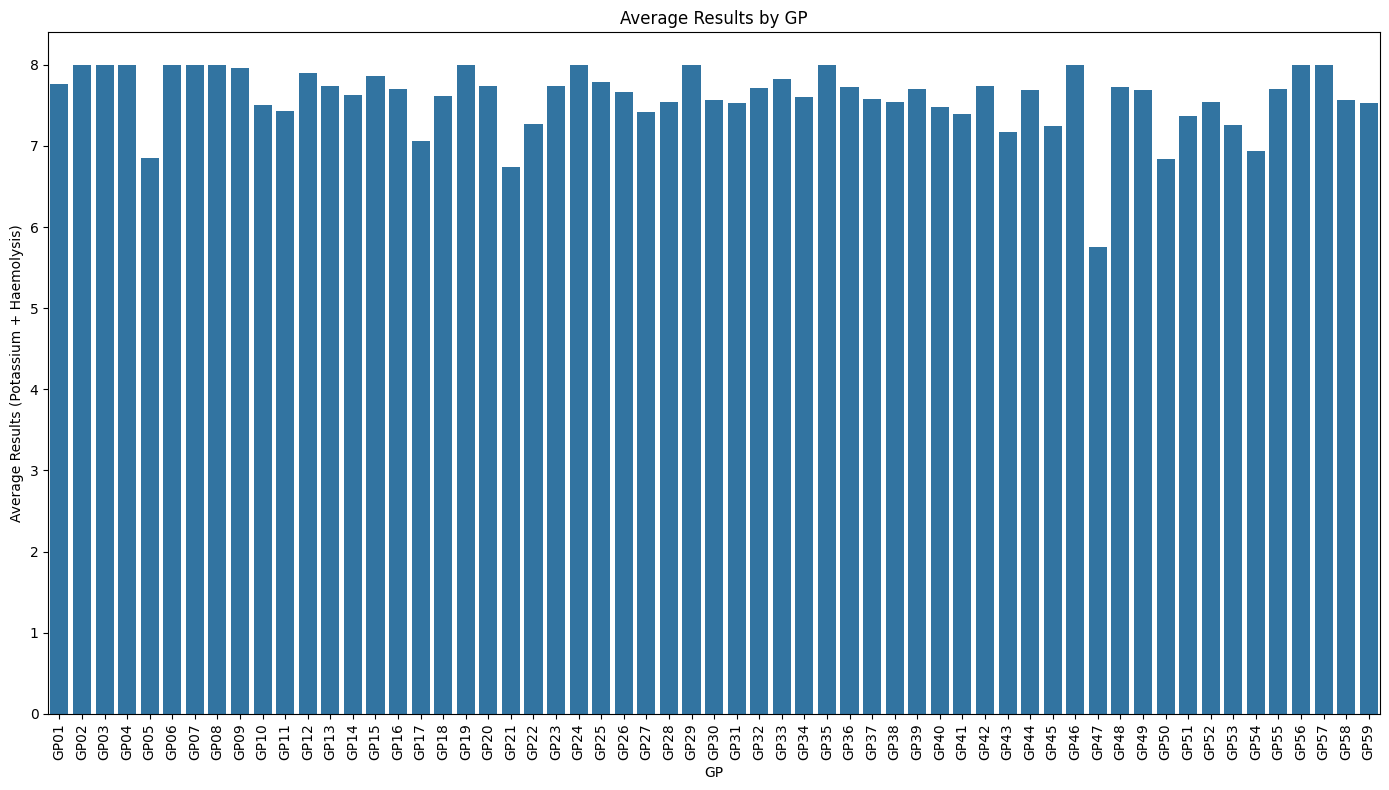

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the average 'Results' for each 'GP'
gp_avg_results = data.groupby('GP')['Results'].mean().reset_index()

# Sort the GP values in ascending order
gp_sorted = sorted(gp_avg_results['GP'])

# Create the plot for average results per GP
plt.figure(figsize=(14, 8))
sns.barplot(x='GP', y='Results', data=gp_avg_results, order=gp_sorted)
plt.title('Average Results by GP')
plt.xlabel('GP')
plt.ylabel('Average Results (Potassium + Haemolysis)')
plt.xticks(rotation=90)  # Rotate GP labels for better readability
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Calculate the average 'Results' for each 'GP'
gp_avg_results = data.groupby('GP')['Results'].mean().reset_index()

# Display the average results by GP in tabular format
print(gp_avg_results)


      GP   Results
0   GP01  7.765625
1   GP02  8.000000
2   GP03  8.000000
3   GP04  8.000000
4   GP05  6.857143
5   GP06  8.000000
6   GP07  8.000000
7   GP08  8.000000
8   GP09  7.958333
9   GP10  7.509709
10  GP11  7.425806
11  GP12  7.902357
12  GP13  7.739130
13  GP14  7.625683
14  GP15  7.864078
15  GP16  7.705085
16  GP17  7.066298
17  GP18  7.612165
18  GP19  8.000000
19  GP20  7.741176
20  GP21  6.734694
21  GP22  7.268519
22  GP23  7.739130
23  GP24  8.000000
24  GP25  7.791667
25  GP26  7.668675
26  GP27  7.416230
27  GP28  7.540541
28  GP29  8.000000
29  GP30  7.561265
30  GP31  7.534615
31  GP32  7.716867
32  GP33  7.818653
33  GP34  7.602941
34  GP35  8.000000
35  GP36  7.720930
36  GP37  7.579186
37  GP38  7.537838
38  GP39  7.699060
39  GP40  7.485185
40  GP41  7.388889
41  GP42  7.734375
42  GP43  7.177419
43  GP44  7.687023
44  GP45  7.247191
45  GP46  8.000000
46  GP47  5.750000
47  GP48  7.727273
48  GP49  7.687117
49  GP50  6.840580
50  GP51  7.369565
51  GP52  7.

In [ ]:
import pandas as pd


# Calculate the average 'Results' for each 'GP' and include distance ('DistanceFromTUH_KM')
gp_avg_results = data.groupby('GP').agg({'Results': 'mean', 'DistanceFromTUH_KM': 'mean'}).reset_index()

# Sort the results in ascending order of 'Results'
gp_avg_results_sorted = gp_avg_results.sort_values(by='Results', ascending=True)

# Display the sorted results
print(gp_avg_results_sorted)


      GP   Results  DistanceFromTUH_KM
46  GP47  5.750000                 0.5
20  GP21  6.734694                 4.4
49  GP50  6.840580                 6.5
4   GP05  6.857143                 7.0
53  GP54  6.932203                 5.3
16  GP17  7.066298                10.4
42  GP43  7.177419                10.5
44  GP45  7.247191                 9.5
52  GP53  7.260274                 0.5
21  GP22  7.268519                 3.2
50  GP51  7.369565                 1.3
40  GP41  7.388889                 4.5
26  GP27  7.416230                 0.5
10  GP11  7.425806                 2.8
39  GP40  7.485185                 7.8
9   GP10  7.509709                 5.7
58  GP59  7.533333                 8.3
30  GP31  7.534615                 2.4
37  GP38  7.537838                 7.3
27  GP28  7.540541                 7.3
51  GP52  7.540698                 4.9
29  GP30  7.561265                 0.9
57  GP58  7.566038                 5.5
36  GP37  7.579186                 7.3
33  GP34  7.602941       

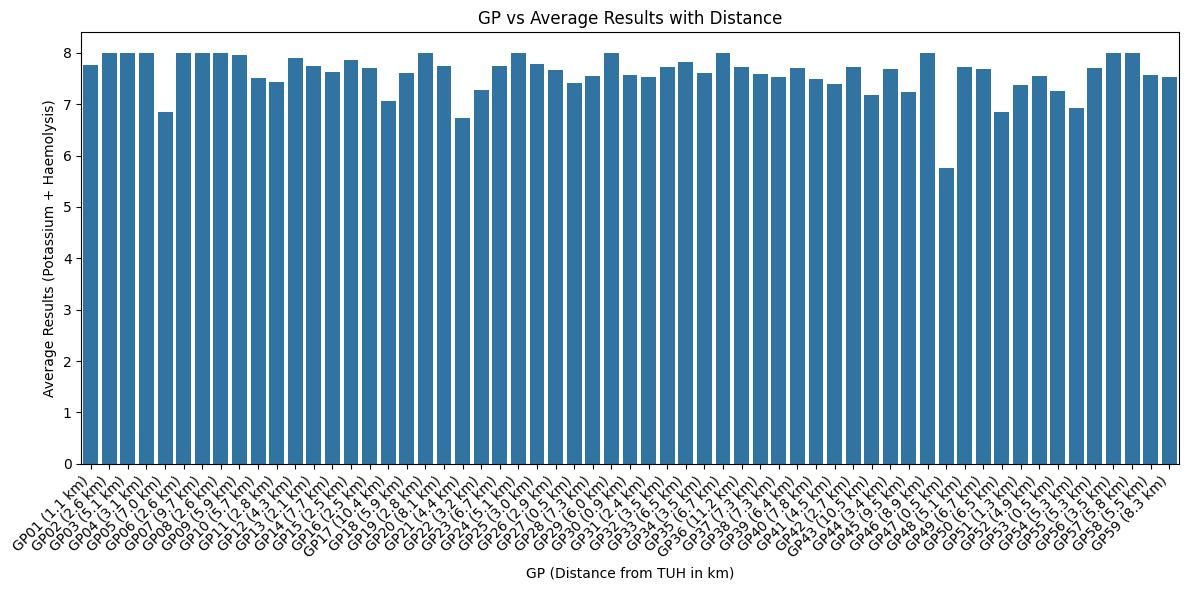

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate the average 'Results' for each 'GP' and include distance ('DistanceFromTUH_KM')
gp_avg_results = data.groupby('GP').agg({'Results': 'mean', 'DistanceFromTUH_KM': 'first'}).reset_index()

# Create a new column 'GP_Label' that combines GP with Distance in brackets
gp_avg_results['GP_Label'] = gp_avg_results['GP'] + ' (' + gp_avg_results['DistanceFromTUH_KM'].astype(str) + ' km)'

# Create the bar plot with GP vs mean results
plt.figure(figsize=(12, 6))
sns.barplot(x='GP_Label', y='Results', data=gp_avg_results)

# Add title and labels
plt.title('GP vs Average Results with Distance')
plt.xlabel('GP (Distance from TUH in km)')
plt.ylabel('Average Results (Potassium + Haemolysis)')
plt.xticks(rotation=45, ha='right')  # Rotate GP labels for better readability
plt.tight_layout()  # Adjust layout for better readability
plt.show()


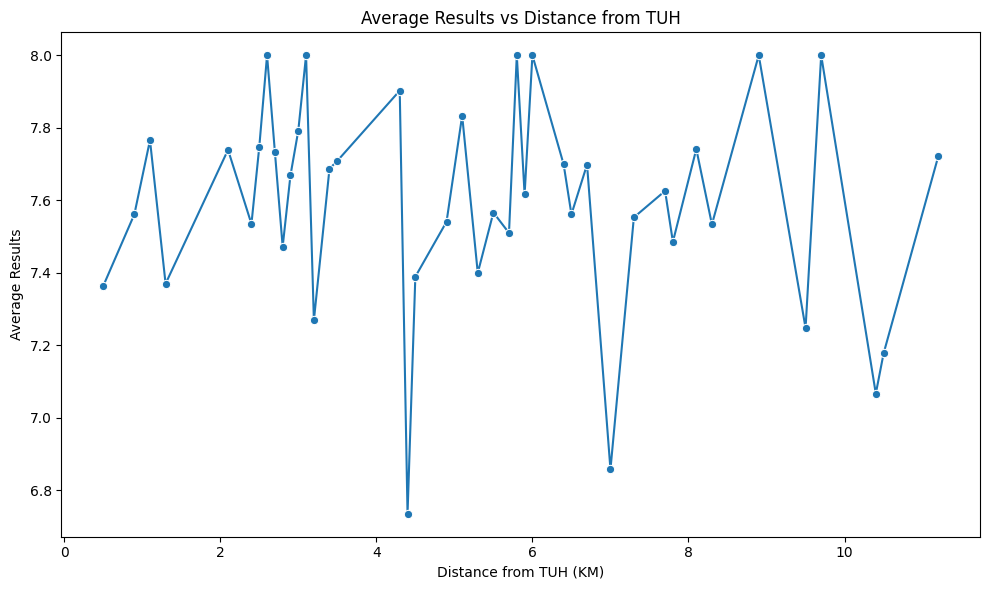

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the average 'Results' for each 'DistanceFromTUH_KM'
distance_avg_results = data.groupby('DistanceFromTUH_KM')['Results'].mean().reset_index()

# Sort by 'DistanceFromTUH_KM' for a better line plot
distance_avg_results = distance_avg_results.sort_values(by='DistanceFromTUH_KM')

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='DistanceFromTUH_KM', y='Results', data=distance_avg_results, marker='o')

# Add title and labels
plt.title('Average Results vs Distance from TUH')
plt.xlabel('Distance from TUH (KM)')
plt.ylabel('Average Results')
plt.tight_layout()  # Adjust layout for better readability
plt.show()


# Adding Route Data

In [ ]:
# 4. Read the workbooks
df_routes = pd.read_excel("routes.xlsx")


# 5. Merge on the GP columns: every GP in LabTUH4 will pull in all matching rows from routes
merged = pd.merge(
    data,                      # start from your lab data
    df_routes,                   # bring in the route info
    left_on='GP',                # key in LabTUH4.xlsx
    right_on='GP',          # key in routes.xlsx
    how='left',                  # keep all lab rows, even if no route match
    suffixes=('_lab', '_route')  # avoid any overlapping column names
)



# 7. Inspect the first few rows
print("Merged DataFrame shape:", merged.shape)
merged.head()



Merged DataFrame shape: (9890, 21)


,DateSampleTaken,TimeSampleTaken,DateReceivedLab,TimeReceivedLab,DateResultReported,TimeResultReported,GP,DistanceFromTUH_KM,Potassium_mmol/L,Haemolysis,...,DatetimeReceivedLab,DatetimeResultReported,MinutesFromGPtoLab,MinutesFromLabToResults,HaemolysisScore,Results,Distance from TUH Lab in KMs,Est time collected from practice,Who delivered samples,Delivery Window
0,2023-02-13,18:22:00,2023-02-13,18:22:00,2023-02-15,09:18:00,GP51,1.3,4.2,3,...,2023-02-13 18:22:00,2023-02-15 09:18:00,215.0,2336.0,0,8,1.3,Unknown,Courier,12.00-12.30
1,2023-02-09,11:00:00,2023-02-09,16:50:00,2023-02-10,14:19:00,GP01,1.1,3.8,6,...,2023-02-09 16:50:00,2023-02-10 14:19:00,350.0,1639.0,0,8,1.1,10.00am - 11.50am,Courier,12.00-12.30
2,2023-01-17,09:45:00,2023-01-17,15:56:00,2023-01-18,15:31:00,GP33,6.5,3.9,4,...,2023-01-17 15:56:00,2023-01-18 15:31:00,371.0,1786.0,0,8,6.5,09.30 - 11.40,Courier,16.00-16.30
3,2023-01-11,16:16:00,2023-01-11,16:47:00,2023-01-12,12:18:00,GP10,5.7,4.8,11,...,2023-01-11 16:47:00,2023-01-12 12:18:00,31.0,1202.0,0,8,5.7,Unknown,Courier,14.30-15.00
4,2023-01-23,12:44:00,2023-01-23,14:01:00,2023-01-23,15:26:00,GP40,7.8,4.3,36,...,2023-01-23 14:01:00,2023-01-23 15:26:00,77.0,162.0,0,8,7.8,Unknown,Courier,14.30-15.00


In [ ]:
# 1. Simple count with value_counts()
gp_counts = data['GP'].value_counts().reset_index()
gp_counts.columns = ['GP', 'entry_count']
print(gp_counts)


      GP  entry_count
0   GP18         2055
1   GP27          382
2   GP38          370
3   GP14          366
4   GP17          362
5   GP52          344
6   GP32          332
7   GP26          332
8   GP49          326
9   GP39          319
10  GP11          310
11  GP12          297
12  GP16          295
13  GP40          270
14  GP44          262
15  GP31          260
16  GP30          253
17  GP25          240
18  GP37          221
19  GP10          206
20  GP33          193
21  GP55          185
22  GP20          170
23  GP42          128
24  GP01          128
25  GP54          118
26  GP22          108
27  GP58          106
28  GP15          103
29  GP51           92
30  GP45           89
31  GP53           73
32  GP50           69
33  GP34           68
34  GP43           62
35  GP21           49
36  GP36           43
37  GP28           37
38  GP59           30
39  GP19           27
40  GP09           24
41  GP23           23
42  GP13           23
43  GP48           22
44  GP41  

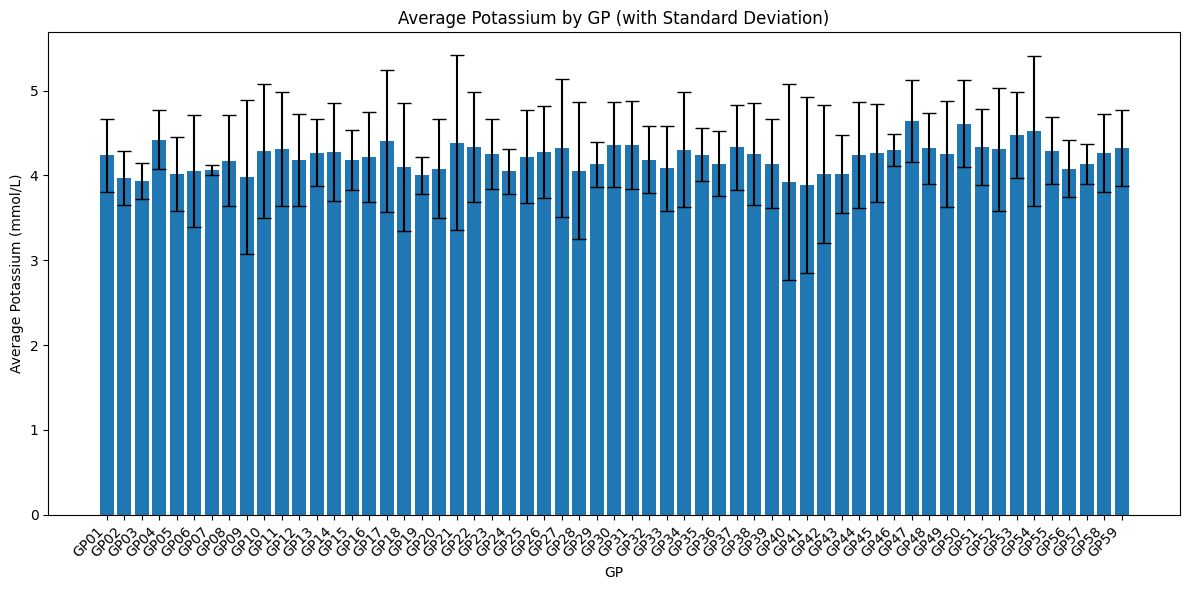

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 1. Ensure Potassium is numeric
merged['Potassium_mmol/L'] = pd.to_numeric(
    merged['Potassium_mmol/L'],
    errors='coerce'
)

# 2. Compute mean and standard deviation of Potassium by GP
stats = (
    merged
    .dropna(subset=['Potassium_mmol/L'])
    .groupby('GP')['Potassium_mmol/L']
    .agg(mean='mean', std='std')
    .reset_index()
)

# 3. Plot bar chart with error bars
plt.figure(figsize=(12, 6))
plt.bar(
    stats['GP'].astype(str),
    stats['mean'],
    yerr=stats['std'],
    capsize=5
)
plt.xlabel('GP')
plt.ylabel('Average Potassium (mmol/L)')
plt.title('Average Potassium by GP (with Standard Deviation)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


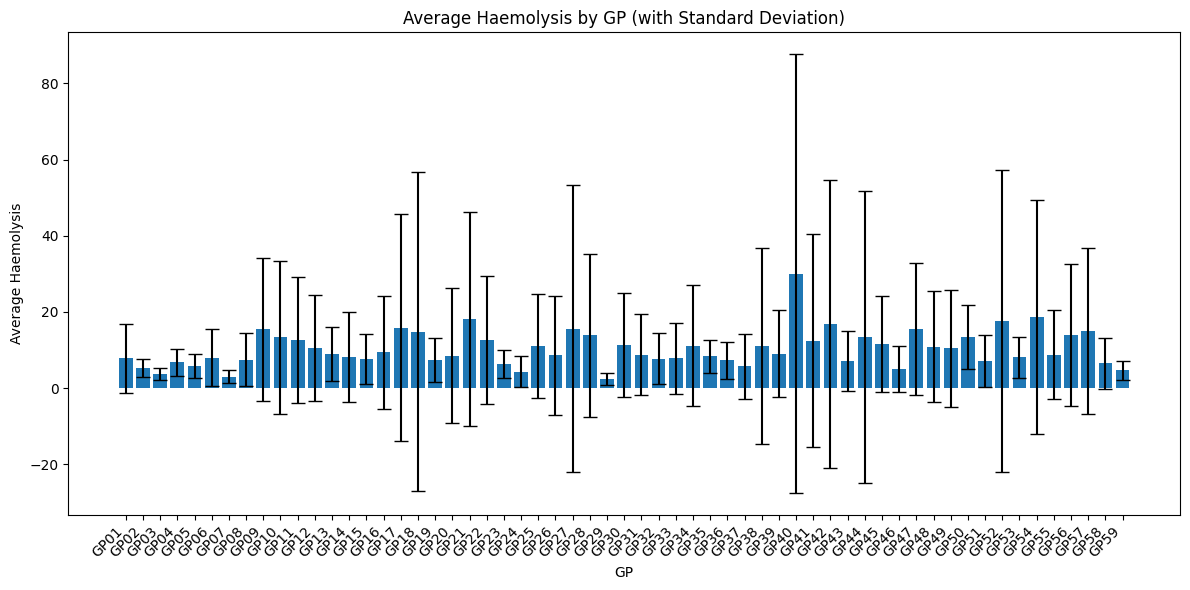

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Ensure Haemolysis is numeric
merged['Haemolysis'] = pd.to_numeric(
    merged['Haemolysis'],
    errors='coerce'
)

# 2. Compute mean and standard deviation of Haemolysis by GP
haem_stats = (
    merged
    .dropna(subset=['Haemolysis'])
    .groupby('GP')['Haemolysis']
    .agg(mean='mean', std='std')
    .reset_index()
)

# 3. Plot bar chart with error bars
plt.figure(figsize=(12, 6))
plt.bar(
    haem_stats['GP'].astype(str),
    haem_stats['mean'],
    yerr=haem_stats['std'],
    capsize=5
)
plt.xlabel('GP')
plt.ylabel('Average Haemolysis')
plt.title('Average Haemolysis by GP (with Standard Deviation)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


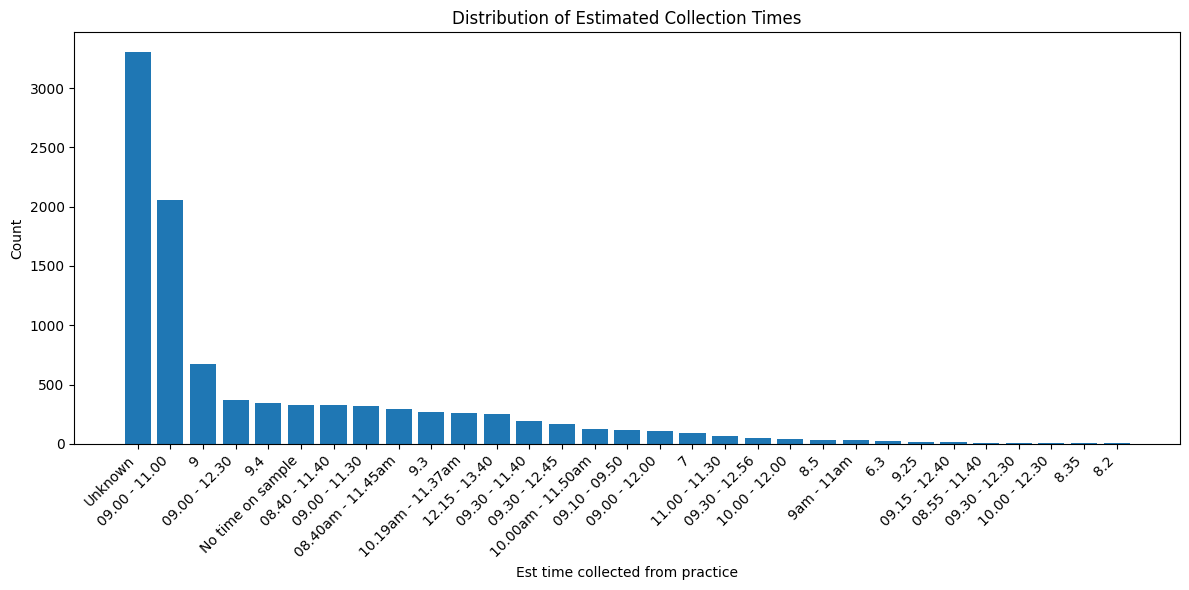

In [ ]:
import matplotlib.pyplot as plt
counts = merged['Est time collected from practice'].value_counts()

# 2. Plot
plt.figure(figsize=(12, 6))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel('Est time collected from practice')
plt.ylabel('Count')
plt.title('Distribution of Estimated Collection Times')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


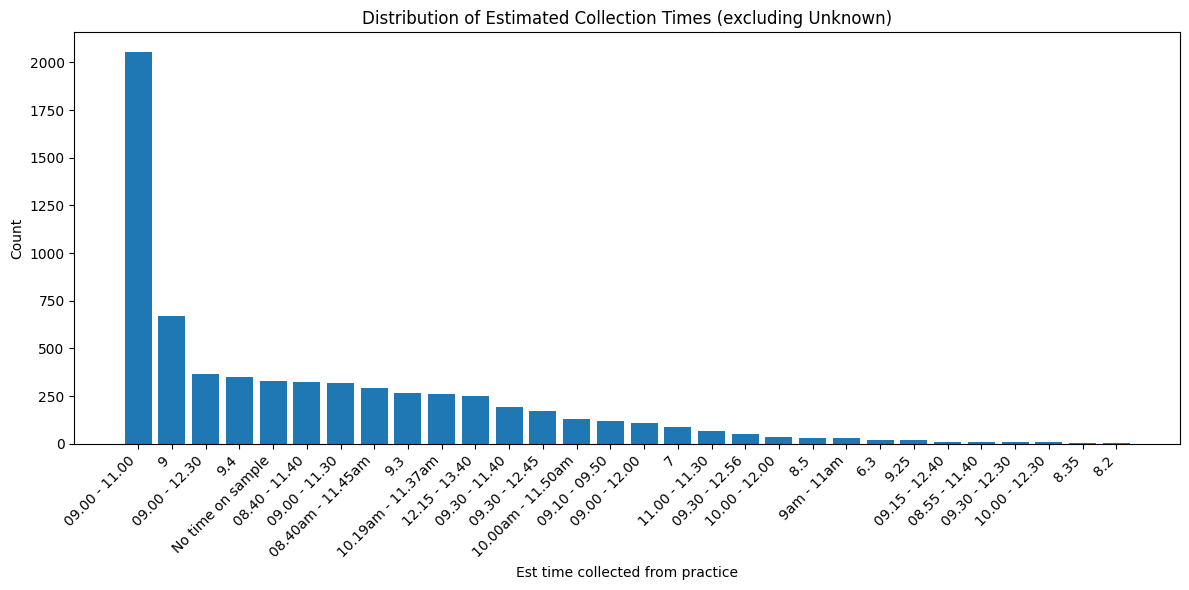

In [ ]:
import matplotlib.pyplot as plt

# 1. Exclude the 'Unknown' entries
filtered = merged[merged['Est time collected from practice'] != 'Unknown']

# 2. Count how many times each label appears
counts = filtered['Est time collected from practice'].value_counts()

# 3. Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel('Est time collected from practice')
plt.ylabel('Count')
plt.title('Distribution of Estimated Collection Times (excluding Unknown)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


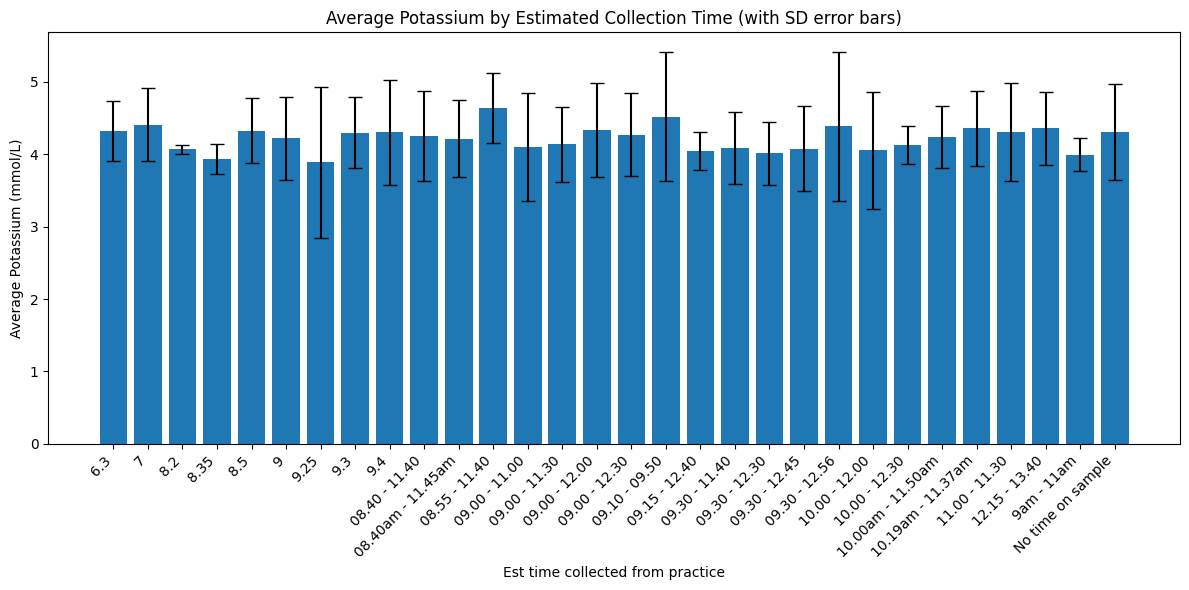

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Exclude 'Unknown' and make a copy
filtered = merged[merged['Est time collected from practice'] != 'Unknown'].copy()

# 2. Ensure Potassium is numeric
filtered['Potassium_mmol/L'] = pd.to_numeric(
    filtered['Potassium_mmol/L'],
    errors='coerce'
)

# 3. Compute mean & std of Potassium for each collection time
stats = (
    filtered
    .dropna(subset=['Potassium_mmol/L'])
    .groupby('Est time collected from practice')['Potassium_mmol/L']
    .agg(mean='mean', std='std')
    .reset_index()
)

# 4. (Optional) Sort by mean descending or by label order
# stats = stats.sort_values('mean', ascending=False)

# 5. Plot bar chart with error bars
plt.figure(figsize=(12, 6))
plt.bar(
    stats['Est time collected from practice'].astype(str),
    stats['mean'],
    yerr=stats['std'],
    capsize=5
)
plt.xlabel('Est time collected from practice')
plt.ylabel('Average Potassium (mmol/L)')
plt.title('Average Potassium by Estimated Collection Time (with SD error bars)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


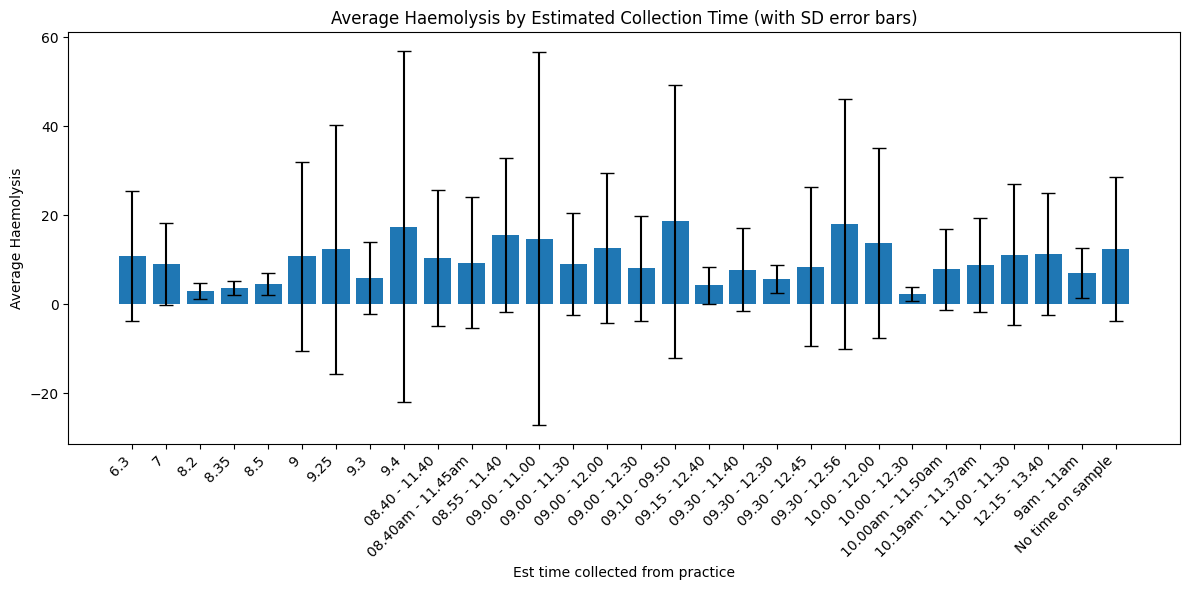

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Exclude 'Unknown' and copy
filtered = merged[merged['Est time collected from practice'] != 'Unknown'].copy()

# 2. Ensure Haemolysis is numeric
filtered['Haemolysis'] = pd.to_numeric(
    filtered['Haemolysis'],
    errors='coerce'
)

# 3. Compute mean & std of Haemolysis for each collection time
stats = (
    filtered
    .dropna(subset=['Haemolysis'])
    .groupby('Est time collected from practice')['Haemolysis']
    .agg(mean='mean', std='std')
    .reset_index()
)

# 4. Plot bar chart with error bars
plt.figure(figsize=(12, 6))
plt.bar(
    stats['Est time collected from practice'].astype(str),
    stats['mean'],
    yerr=stats['std'],
    capsize=5
)
plt.xlabel('Est time collected from practice')
plt.ylabel('Average Haemolysis')
plt.title('Average Haemolysis by Estimated Collection Time (with SD error bars)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


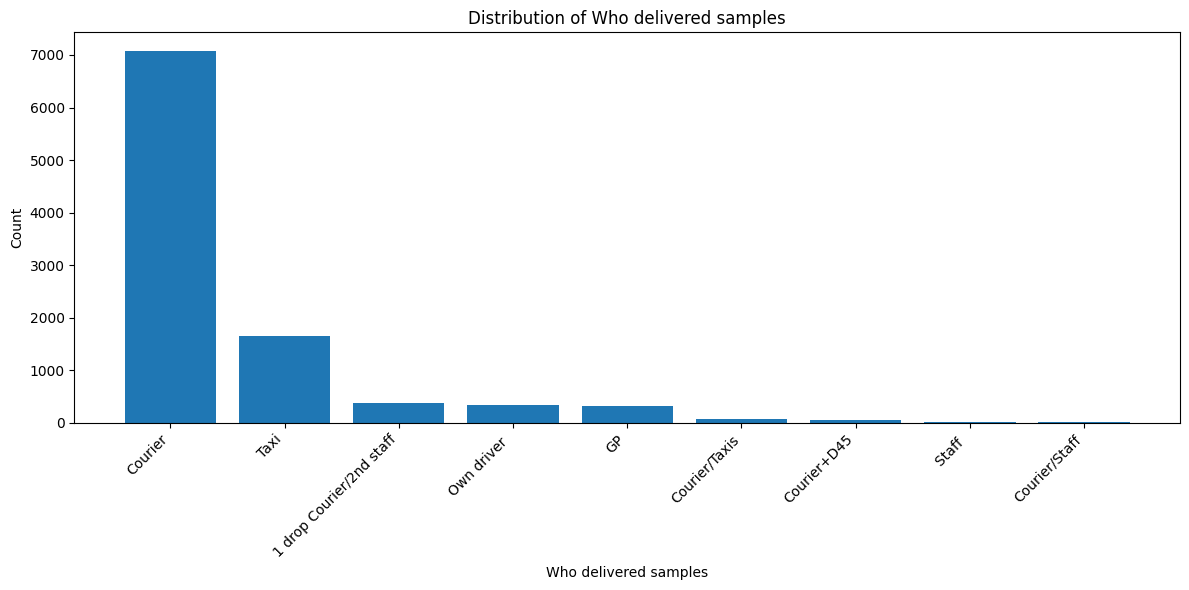

In [ ]:
import matplotlib.pyplot as plt
counts = merged['Who delivered samples'].value_counts()

# 2. Plot
plt.figure(figsize=(12, 6))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel('Who delivered samples')
plt.ylabel('Count')
plt.title('Distribution of Who delivered samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


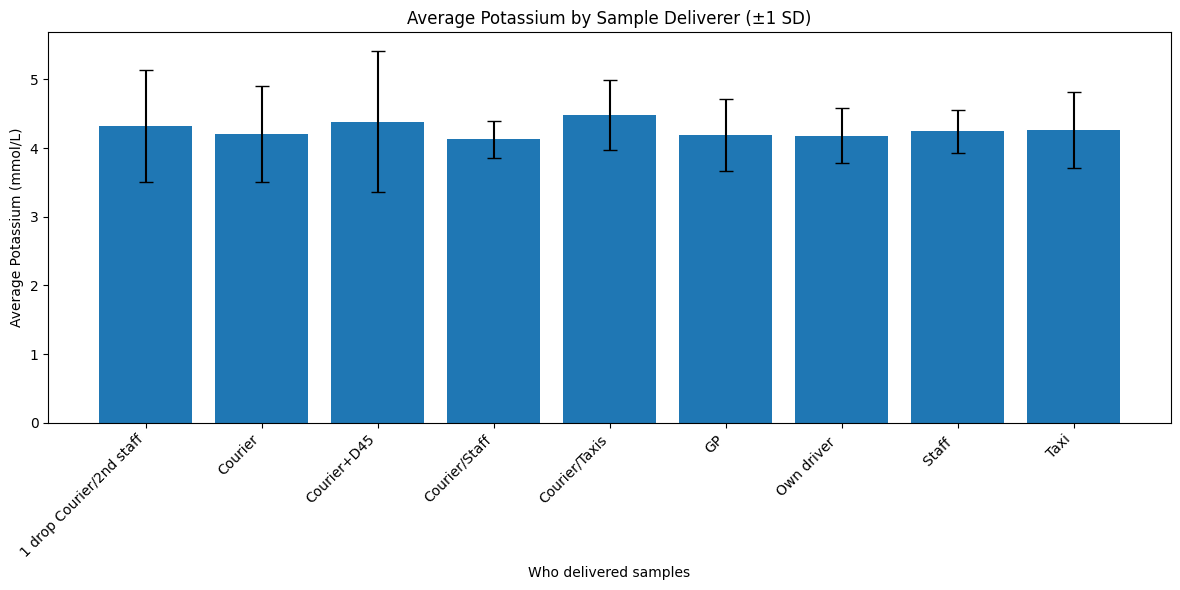

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Ensure Potassium is numeric
merged['Potassium_mmol/L'] = pd.to_numeric(
    merged['Potassium_mmol/L'],
    errors='coerce'
)

# 2. Compute mean and standard deviation of Potassium by deliverer
stats = (
    merged
    .dropna(subset=['Potassium_mmol/L'])
    .groupby('Who delivered samples')['Potassium_mmol/L']
    .agg(mean='mean', std='std')
    .reset_index()
)

# 3. Plot bar chart with error bars
plt.figure(figsize=(12, 6))
plt.bar(
    stats['Who delivered samples'].astype(str),
    stats['mean'],
    yerr=stats['std'],
    capsize=5
)
plt.xlabel('Who delivered samples')
plt.ylabel('Average Potassium (mmol/L)')
plt.title('Average Potassium by Sample Deliverer (±1 SD)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


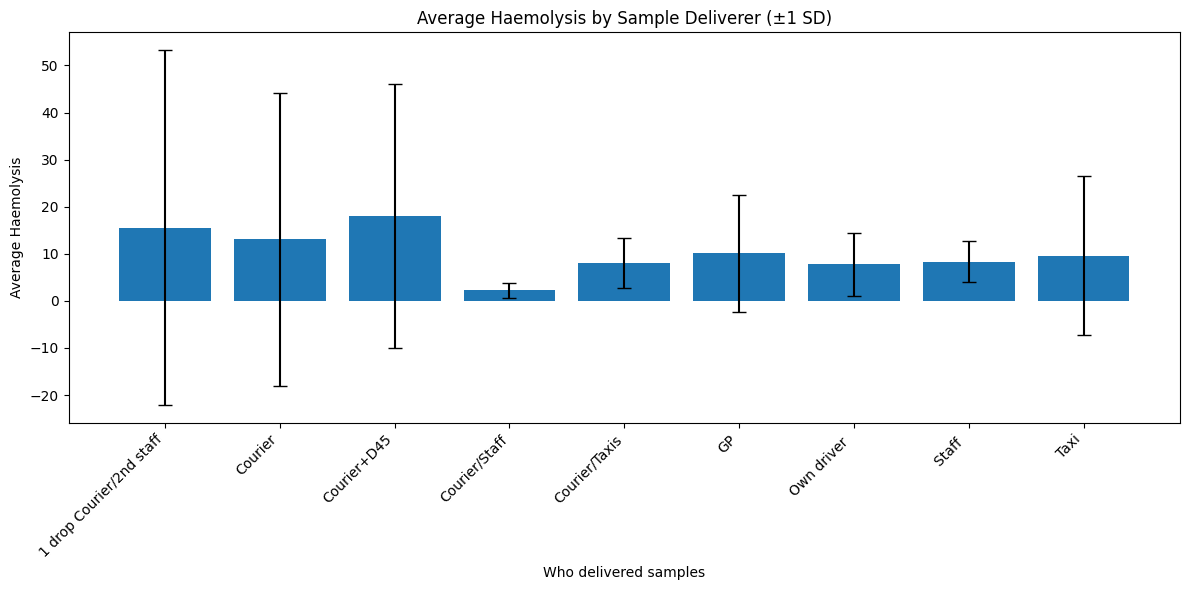

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# (Re)load merged DataFrame if needed:
# merged = pd.read_excel('/path/to/merged.xlsx')

# 1. Ensure Haemolysis is numeric
merged['Haemolysis'] = pd.to_numeric(
    merged['Haemolysis'],
    errors='coerce'
)

# 2. Compute mean and standard deviation of Haemolysis by sample deliverer
haem_stats = (
    merged
    .dropna(subset=['Haemolysis'])
    .groupby('Who delivered samples')['Haemolysis']
    .agg(mean='mean', std='std')
    .reset_index()
)

# 3. Plot bar chart with error bars
plt.figure(figsize=(12, 6))
plt.bar(
    haem_stats['Who delivered samples'].astype(str),
    haem_stats['mean'],
    yerr=haem_stats['std'],
    capsize=5
)
plt.xlabel('Who delivered samples')
plt.ylabel('Average Haemolysis')
plt.title('Average Haemolysis by Sample Deliverer (±1 SD)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


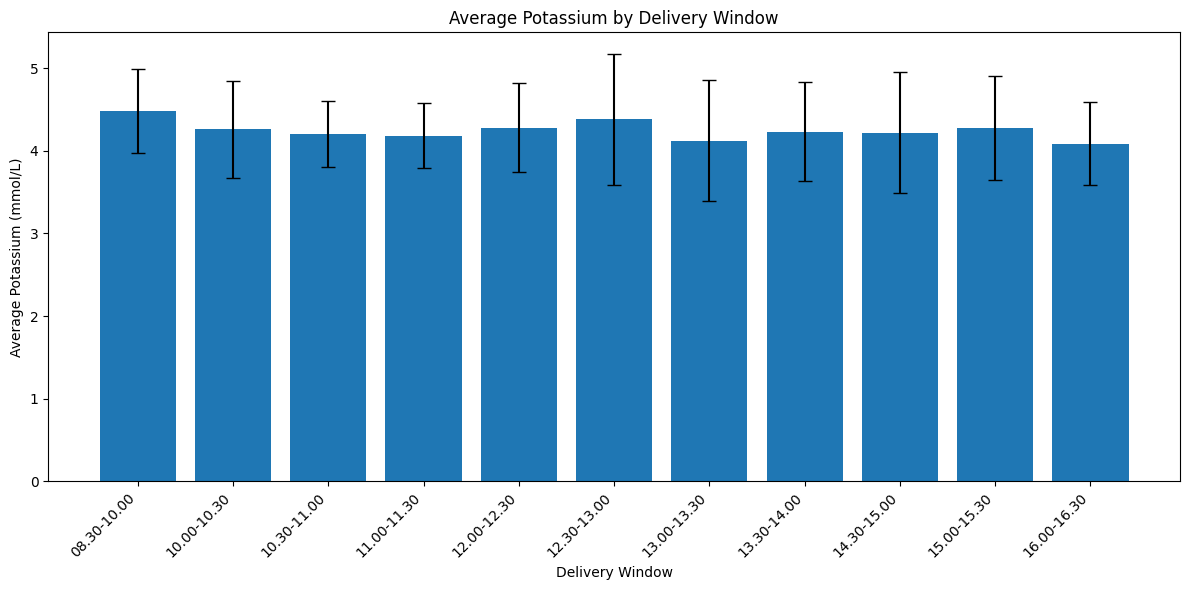

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Ensure Potassium is numeric
merged['Potassium_mmol/L'] = pd.to_numeric(
    merged['Potassium_mmol/L'],
    errors='coerce'
)

# 2. Compute mean and standard deviation of Potassium by Delivery Window
potassium_stats = (
    merged
    .dropna(subset=['Potassium_mmol/L'])
    .groupby('Delivery Window')['Potassium_mmol/L']
    .agg(mean='mean', std='std')
    .reset_index()
)

# 3. Plot bar chart with error bars
plt.figure(figsize=(12, 6))
plt.bar(
    potassium_stats['Delivery Window'].astype(str),
    potassium_stats['mean'],
    yerr=potassium_stats['std'],
    capsize=5
)
plt.xlabel('Delivery Window')
plt.ylabel('Average Potassium (mmol/L)')
plt.title('Average Potassium by Delivery Window')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


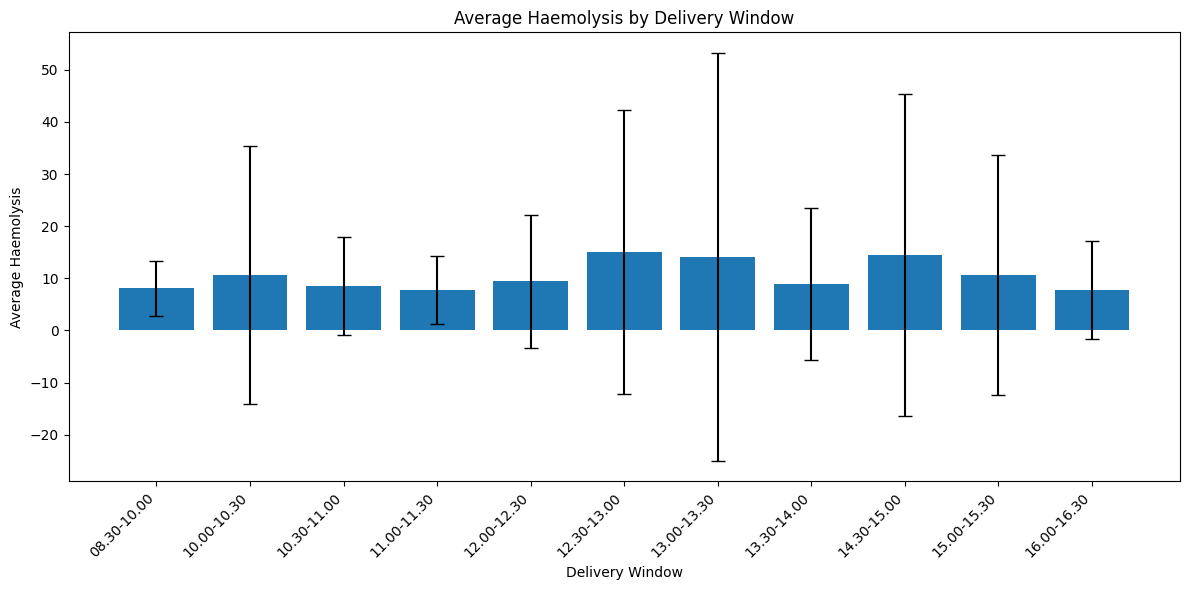

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Ensure Haemolysis is numeric
merged['Haemolysis'] = pd.to_numeric(
    merged['Haemolysis'],
    errors='coerce'
)

# 2. Compute mean and standard deviation of Haemolysis by Delivery Window
haem_stats = (
    merged
    .dropna(subset=['Haemolysis'])
    .groupby('Delivery Window')['Haemolysis']
    .agg(mean='mean', std='std')
    .reset_index()
)

# 3. Plot bar chart with error bars
plt.figure(figsize=(12, 6))
plt.bar(
    haem_stats['Delivery Window'].astype(str),
    haem_stats['mean'],
    yerr=haem_stats['std'],
    capsize=5
)
plt.xlabel('Delivery Window')
plt.ylabel('Average Haemolysis')
plt.title('Average Haemolysis by Delivery Window')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# 1. Aggregate: compute average minutes for each collector
avg_minutes = (
    merged
    .groupby('Who delivered samples', as_index=False)['MinutesFromGPtoLab']
    .mean()
)
avg_minutes.columns = ['Who delivered samples', 'avg_minutes_from_gp_to_lab']

# add std dev, var
print(avg_minutes) # Added print to explicitly display the DataFrame

      Who delivered samples  avg_minutes_from_gp_to_lab
0  1 drop Courier/2nd staff                  242.154450
1                   Courier                  235.983750
2               Courier+D45                  221.306122
3             Courier/Staff                  238.714286
4             Courier/Taxis                  226.589041
5                        GP                  224.509494
6               Own driver                   245.593373
7                    Staff                   253.111111
8                      Taxi                  231.676596


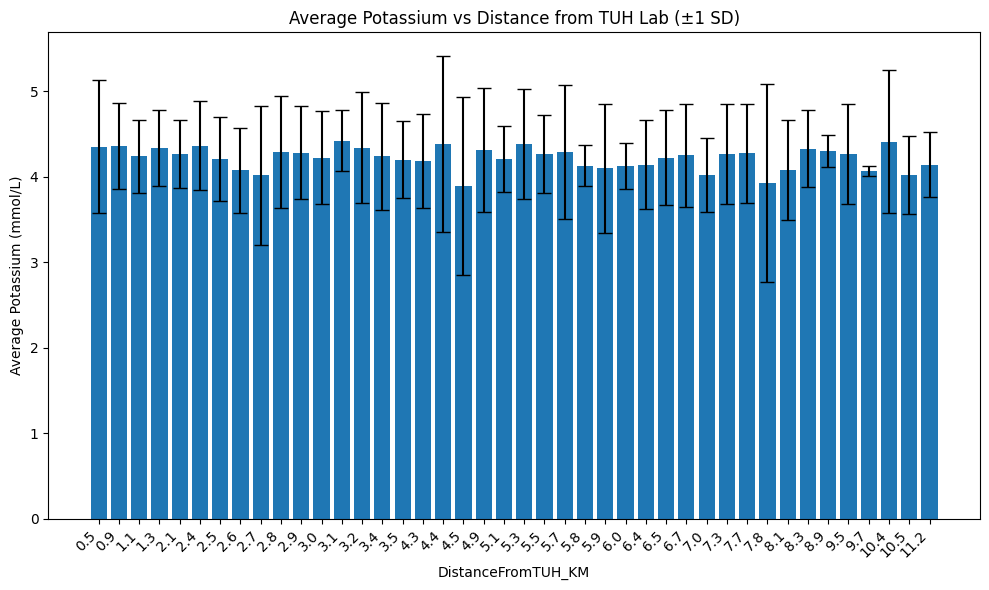

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Ensure Potassium is numeric
merged['Potassium_mmol/L'] = pd.to_numeric(
    merged['Potassium_mmol/L'],
    errors='coerce'
)

# 2. Compute mean and standard deviation of Potassium for each distance
stats = (
    merged
    .dropna(subset=['Potassium_mmol/L'])
    .groupby('DistanceFromTUH_KM')['Potassium_mmol/L']
    .agg(mean='mean', std='std')
    .reset_index()
    .sort_values('DistanceFromTUH_KM')
)

# 3. Plot bar chart with error bars
plt.figure(figsize=(10, 6))
plt.bar(
    stats['DistanceFromTUH_KM'].astype(str),
    stats['mean'],
    yerr=stats['std'],
    capsize=5
)
plt.xlabel('DistanceFromTUH_KM')
plt.ylabel('Average Potassium (mmol/L)')
plt.title('Average Potassium vs Distance from TUH Lab (±1 SD)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


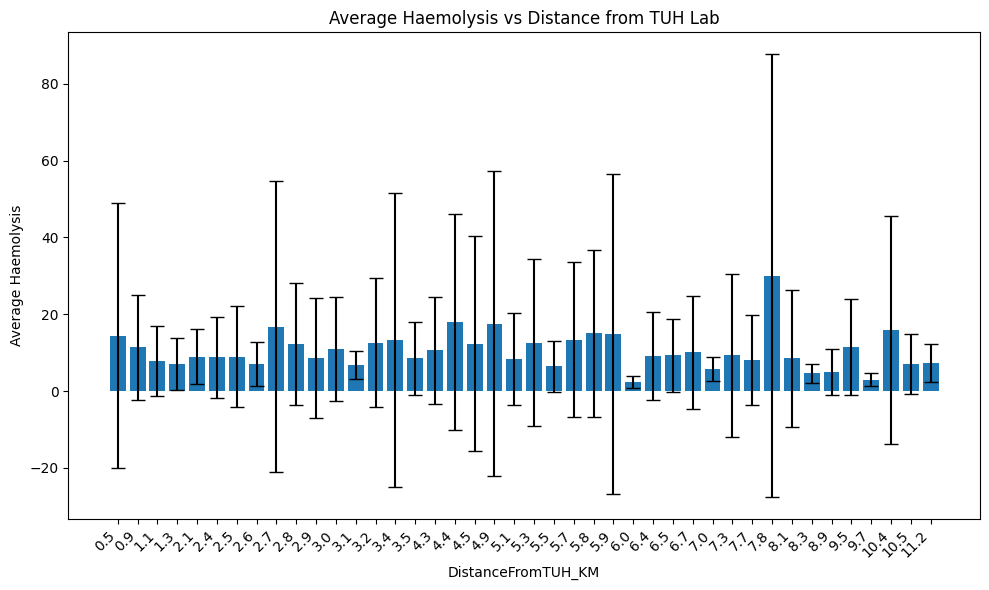

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Ensure Haemolysis is numeric
merged['Haemolysis'] = pd.to_numeric(
    merged['Haemolysis'],
    errors='coerce'
)

# 2. Compute mean, std dev, and variance of Haemolysis by distance
stats = (
    merged
    .dropna(subset=['Haemolysis'])
    .groupby('DistanceFromTUH_KM')['Haemolysis']
    .agg(mean='mean', std='std', var='var')
    .reset_index()
    .sort_values('DistanceFromTUH_KM')
)


# 4. Plot bar chart of mean with error bars = ±1 std dev
plt.figure(figsize=(10, 6))
plt.bar(
    stats['DistanceFromTUH_KM'].astype(str),
    stats['mean'],
    yerr=stats['std'],
    capsize=5
)
plt.xlabel('DistanceFromTUH_KM')
plt.ylabel('Average Haemolysis')
plt.title('Average Haemolysis vs Distance from TUH Lab')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Model 1

In [ ]:
# Drop the specified columns from the dataset
data = merged.drop(columns=['DateSampleTaken', 'TimeSampleTaken',
                          'DateReceivedLab', 'TimeReceivedLab',
                          'DateResultReported', 'TimeResultReported','Est time collected from practice','Delivery Window'])

# Check the first few rows to confirm the columns have been removed
print(data.head())


     GP  DistanceFromTUH_KM  Potassium_mmol/L  Haemolysis DatetimeSampleTaken  \
0  GP51                 1.3               4.2           3 2023-02-13 18:22:00   
1  GP01                 1.1               3.8           6 2023-02-09 11:00:00   
2  GP33                 6.5               3.9           4 2023-01-17 09:45:00   
3  GP10                 5.7               4.8          11 2023-01-11 16:16:00   
4  GP40                 7.8               4.3          36 2023-01-23 12:44:00   

  DatetimeReceivedLab DatetimeResultReported  MinutesFromGPtoLab  \
0 2023-02-13 18:22:00    2023-02-15 09:18:00               215.0   
1 2023-02-09 16:50:00    2023-02-10 14:19:00               350.0   
2 2023-01-17 15:56:00    2023-01-18 15:31:00               371.0   
3 2023-01-11 16:47:00    2023-01-12 12:18:00                31.0   
4 2023-01-23 14:01:00    2023-01-23 15:26:00                77.0   

   MinutesFromLabToResults  HaemolysisScore  Results  \
0                   2336.0                0     

In [ ]:
# Drop the specified columns from the dataset
data = data.drop(columns=['DatetimeSampleTaken', 'DatetimeReceivedLab',
                          'DatetimeResultReported'])

# Check the first few rows to confirm the columns have been removed
print(data.head())


     GP  DistanceFromTUH_KM  Potassium_mmol/L  Haemolysis  MinutesFromGPtoLab  \
0  GP51                 1.3               4.2           3               215.0   
1  GP01                 1.1               3.8           6               350.0   
2  GP33                 6.5               3.9           4               371.0   
3  GP10                 5.7               4.8          11                31.0   
4  GP40                 7.8               4.3          36                77.0   

   MinutesFromLabToResults  HaemolysisScore  Results  \
0                   2336.0                0        8   
1                   1639.0                0        8   
2                   1786.0                0        8   
3                   1202.0                0        8   
4                    162.0                0        8   

   Distance from TUH Lab in KMs Who delivered samples  
0                           1.3               Courier  
1                           1.1               Courier  
2       

In [ ]:
# Drop the specified columns from the dataset
data = data.drop(columns=['GP'])

# Check the first few rows to confirm the columns have been removed
print(data.head())


   DistanceFromTUH_KM  Potassium_mmol/L  Haemolysis  MinutesFromGPtoLab  \
0                 1.3               4.2           3               215.0   
1                 1.1               3.8           6               350.0   
2                 6.5               3.9           4               371.0   
3                 5.7               4.8          11                31.0   
4                 7.8               4.3          36                77.0   

   MinutesFromLabToResults  HaemolysisScore  Results  \
0                   2336.0                0        8   
1                   1639.0                0        8   
2                   1786.0                0        8   
3                   1202.0                0        8   
4                    162.0                0        8   

   Distance from TUH Lab in KMs Who delivered samples  
0                           1.3               Courier  
1                           1.1               Courier  
2                           6.5             

## Multi-Class MLP: Data Prep, Training & Evaluation

**What this cell does**

- **Reproducibility**
  - Fixes NumPy and TensorFlow seeds (`seed=1`).

- **Target & Features**
  - Uses **`Results`** as the multi-class target.
  - Builds **X** from all columns **except** `Results`, `Haemolysis`, and `HaemolysisScore` to avoid leakage.
  - One-hot encodes **Y** for softmax training.

- **Scaling & Split**
  - Applies **row-wise normalization** (`sklearn.Normalizer`) so each sample has unit norm.
  - Splits data into **train/validation (67/33)** with a fixed random state.

- **Model**
  - **MLP (Keras Sequential)** with hidden layers: `Dense(128) → Dense(64) → Dense(32)` (ReLU).
  - Output layer: `Dense(n_classes, activation='softmax')`.
  - Optimizer: **Adam** (`lr=1e-4`); Loss: **categorical_crossentropy**; Metric: **accuracy**.

- **Training**
  - Trains for **30 epochs**, `batch_size=32`, shuffling each epoch.
  - Records **training/validation loss** and **accuracy**.

- **Visualization**
  - Plots two panels: **loss** and **accuracy** for train vs. validation over epochs.

- **Evaluation**
  - Predicts class probabilities on the validation set.
  - Reports **classification_report** (precision/recall/F1 per class + accuracy).
  - Computes **multi-class ROC-AUC** (OvR) with **macro** and **weighted** averages (handles class imbalance).

**Why it matters**

- Produces a clean **baseline neural classifier** on your engineered labels.
- Tracks both **optimization behavior** (loss curves) and **generalization** (val accuracy, ROC-AUC, F1).


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5211 - loss: 2.0504 - val_accuracy: 0.9246 - val_loss: 1.4297
Epoch 2/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9326 - loss: 1.0990 - val_accuracy: 0.9246 - val_loss: 0.4825
Epoch 3/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9326 - loss: 0.4168 - val_accuracy: 0.9246 - val_loss: 0.4010
Epoch 4/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9326 - loss: 0.3609 - val_accuracy: 0.9246 - val_loss: 0.3846
Epoch 5/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9326 - loss: 0.3476 - val_accuracy: 0.9246 - val_loss: 0.3760
Epoch 6/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9326 - loss: 0.3403 - val_accuracy: 0.9246 - val_loss: 0.3696
Epoch 7/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9326 - loss: 0.3349 - val_accuracy: 0.9246 - val_loss: 0.3643
Epoch 8/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9326 - loss: 0.3306 - val_accuracy: 0

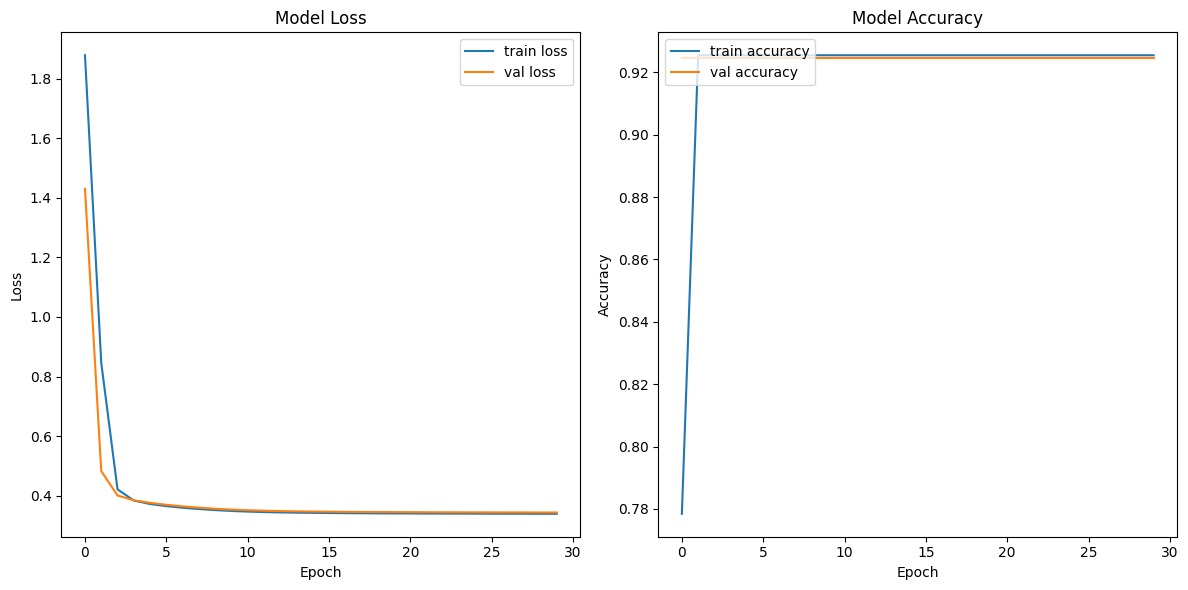

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           2       0.00      0.00      0.00       161
           3       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        40
           7       0.00      0.00      0.00         7
           8       0.92      1.00      0.96      3018

    accuracy                           0.92      3264
   macro avg       0.15      0.17      0.16      3264
weighted avg       0.85      0.92      0.89      3264

Could not calculate AUC-ROC: Number of classes in y_true not equal to the number of columns in 'y_score'
This might happen if a class has only one sample in the validation set.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, Normalizer, OneHotEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score


# === 1. Fix random seeds for reproducibility ===
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

# === 2. Prepare data for multi-class classification ===
# Assuming 'Results' is the target variable and other relevant columns are features
# Re-define X and Y based on the current state of the 'data' DataFrame
# Exclude 'Haemolysis' as it was used to create 'Results'
feature_cols = [col for col in data.columns if col not in ['Results', 'Haemolysis', 'HaemolysisScore']]
X = data[feature_cols].values
Y = data['Results'].values

# One-hot encode the target variable for multi-class classification
Y_one_hot = to_categorical(Y)

# Normalize the features
scaler = Normalizer()
normalizedX = scaler.fit_transform(X)

# Split data into training and validation sets
X_train, X_val, Y_train_one_hot, Y_val_one_hot = train_test_split(
    normalizedX, Y_one_hot, test_size=0.33, random_state=seed
)
Y_train = np.argmax(Y_train_one_hot, axis=1) # Keep original labels for plotting
Y_val = np.argmax(Y_val_one_hot, axis=1) # Keep original labels for plotting


# === 3. Build a multi-class classification model ===
optimizer = Adam(learning_rate=0.0001)
model = Sequential()
model.add(Dense(128, input_dim=normalizedX.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(Y_one_hot.shape[1], activation='softmax')) # Output layer with softmax for multi-class

# === 4. Compile with a multi-class loss and metrics ===
model.compile(
    loss='categorical_crossentropy',  # Categorical crossentropy for multi-class
    optimizer=optimizer,
    metrics=['accuracy']     # Track accuracy
)

# === 5. Fit the model and store history ===
results = model.fit(
    X_train,
    Y_train_one_hot,
    validation_data=(X_val, Y_val_one_hot),
    epochs=30,
    batch_size=32,
    verbose=1,
    shuffle=True
)

# === 6. Plot training & validation loss and accuracy ===
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'], label='train loss')
plt.plot(results.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'], label='train accuracy')
plt.plot(results.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# === 7. Evaluate model performance ===
# Predict probabilities for the validation set
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1) # Convert probabilities to class labels

# Display classification report
print("Classification Report:\n")
print(classification_report(Y_val, y_pred))

# Calculate AUC-ROC. For multi-class, use 'ovr' or 'ovo'
# roc_auc_score is typically used for binary classification or one-vs-rest/one-vs-one in multi-class.
# Given the potential imbalance and multiple classes, macro or weighted average AUC might be more informative.
try:
    auc_roc_macro = roc_auc_score(Y_val, y_pred_prob, multi_class='ovr', average='macro')
    print(f"AUC-ROC (macro average): {auc_roc_macro}")

    auc_roc_weighted = roc_auc_score(Y_val, y_pred_prob, multi_class='ovr', average='weighted')
    print(f"AUC-ROC (weighted average): {auc_roc_weighted}")
except ValueError as e:
    print(f"Could not calculate AUC-ROC: {e}")
    print("This might happen if a class has only one sample in the validation set.")

# Model 2

## Random Forest for Haemolysis (with SHAP)

### What this cell does
- **Drops** an unused column: `Est time collected from practice`.
- **Sets the target** `y = Haemolysis`.
- **Selects numeric features** `X = [DistanceFromTUH_KM, Potassium_mmol/L, MinutesFromGPtoLab, MinutesFromLabToResults]`.
- **Splits data** into train/test (80/20, `random_state=42`).
- **Trains** a `RandomForestRegressor(n_estimators=100)`.
- **Ranks features** using the model’s impurity-based importances.
- **Explains predictions** with **TreeSHAP** and shows a SHAP **summary plot** (global view).
- **Evaluates** generalization with **R²**, **MSE**, and **MAE** on the test set.

### Why these choices
- **Random Forest** handles nonlinearity, interactions, and mixed feature scales with minimal preprocessing.
- **SHAP** gives consistent, additive attributions for each feature → clearer clinical/operational insight.
- **R²/MSE/MAE** quantify out-of-sample performance (MAE is in haemolysis units, so it’s easy to interpret).

### How to read the outputs
- **Feature importances table:** higher = more influence in the forest’s splits (global, model-level).
- **SHAP summary plot:**
  - Y-axis lists features (most impactful at top).
  - Each dot = one sample’s contribution; **position** shows effect size on the prediction.
  - **Color** encodes the feature value (e.g., high vs. low MinutesFromLabToResults).
- **Metrics:**
  - **R²** near **1** = strong fit; near **0** = weak; **<0** = worse than predicting the mean.
  - **MAE** is the average absolute error in actual haemolysis units.

> **Notes**
> - Ensure all selected features are numeric and cleaned (no NaNs) before fitting.
> - If you want “Lab → Results” time instead of end-to-end, compute `DatetimeResultReported − DatetimeReceivedLab`.


In [ ]:
merged = merged.drop(columns=['Est time collected from practice'])
print(merged.head())

  DateSampleTaken TimeSampleTaken DateReceivedLab TimeReceivedLab  \
0      2023-02-13        18:22:00      2023-02-13        18:22:00   
1      2023-02-09        11:00:00      2023-02-09        16:50:00   
2      2023-01-17        09:45:00      2023-01-17        15:56:00   
3      2023-01-11        16:16:00      2023-01-11        16:47:00   
4      2023-01-23        12:44:00      2023-01-23        14:01:00   

  DateResultReported TimeResultReported    GP  DistanceFromTUH_KM  \
0         2023-02-15           09:18:00  GP51                 1.3   
1         2023-02-10           14:19:00  GP01                 1.1   
2         2023-01-18           15:31:00  GP33                 6.5   
3         2023-01-12           12:18:00  GP10                 5.7   
4         2023-01-23           15:26:00  GP40                 7.8   

   Potassium_mmol/L  Haemolysis DatetimeSampleTaken DatetimeReceivedLab  \
0               4.2           3 2023-02-13 18:22:00 2023-02-13 18:22:00   
1               3.8 

Feature importances for predicting Haemolysis:
                feature  importance
       Potassium_mmol/L    0.576539
MinutesFromLabToResults    0.268188
     MinutesFromGPtoLab    0.082675
     DistanceFromTUH_KM    0.072597


/tmp/ipython-input-542874.py:41: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=feature_cols)


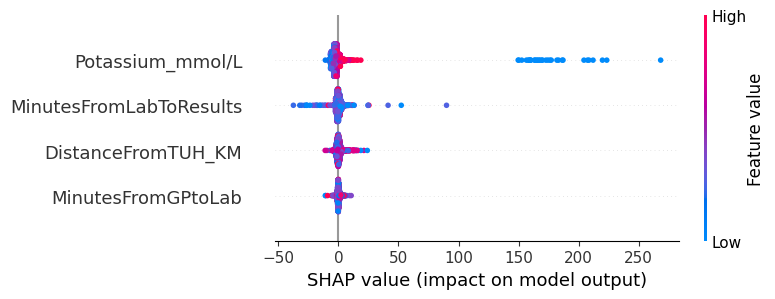

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

y = merged['Haemolysis']

# Features: numeric columns
feature_cols = [
    'DistanceFromTUH_KM',
    'Potassium_mmol/L',
    'MinutesFromGPtoLab',
    'MinutesFromLabToResults'
]
X = merged[feature_cols].copy()

# === 3. Split into train/test sets ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# === 4. Fit a Random Forest regressor ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# === 5. Extract and display feature importances ===
fi = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Feature importances for predicting Haemolysis:")
print(fi.to_string(index=False))

# === 6. Compute and visualize SHAP values (TreeSHAP) ===
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# 6a. SHAP summary plot (global importance)
shap.summary_plot(shap_values, X_test, feature_names=feature_cols)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1. Predict on the test set
y_pred = rf.predict(X_test)

# 2. Compute R²
r2 = r2_score(y_test, y_pred)
print(f"R² on test set: {r2:.3f}")

# 3. Compute Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.3f}")

# 4. Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:.3f}")


R² on test set: 0.578
Test MSE: 281.313
Test MAE: 8.266


# Model 3

## Regression and Feature Importance Analysis for Haemolysis Prediction




### What this cell does
- **Data prep**
  - Selects 4 numeric predictors: `DistanceFromTUH_KM`, `Potassium_mmol/L`, `MinutesFromGPtoLab`, `MinutesFromLabToResults`.
  - Imputes missing values (mean), then **standardizes** features (z-scores) → `X_final`.

- **Linear baseline (OLS)**
  - Fits **OLS** with an intercept on standardized features.
  - Prints the full regression summary (R², F-stat, coefficients, SEs, t, p, CIs).
  - Reports **standardized coefficients** (effect per 1 SD), allowing direct magnitude comparison across features.

- **Sparse linear model (LassoCV)**
  - Runs **LassoCV (5-fold)** to select an L1 penalty.
  - Prints **non-zero coefficients** → variables retained after shrinkage (helps with multicollinearity and feature selection).

- **Nonlinear model (Random Forest)**
  - Trains a **RandomForestRegressor (n=200)** and prints **train R²** and **train MAE** (overfit check).
  - Re-splits into **train/test (80/20)**, refits RF, and computes **permutation importance on the test set** (drop in score when a feature is shuffled).

- **Model explainability (TreeSHAP)**
  - Uses **SHAP TreeExplainer** on the test RF and shows a **summary (beeswarm) plot**:
    - Y-axis: features ranked by impact.
    - X-axis: SHAP value (direction/magnitude of effect on prediction).
    - Color: feature value (low→high), revealing monotonic/non-monotonic patterns.

### Why these steps
- **OLS** gives an interpretable baseline with significance tests and effect sizes.
- **Lasso** performs embedded feature selection and stabilizes estimates.
- **Random Forest** captures **nonlinearities** and interactions with minimal tuning.
- **Permutation importance** (on **held-out** data) provides **model-agnostic** global importance.
- **SHAP** complements importance with **consistent, local-to-global attributions**.

### How to read the outputs
- **OLS summary**: check R² and p-values; standardized coefficients show relative influence (caution with correlated predictors).
- **Lasso non-zeros**: variables the model keeps after penalization → candidates for a simpler linear spec.
- **RF train metrics**: high train R² with low test performance ⇒ overfitting (use the split RF for honest assessment).
- **Permutation importance**: larger mean decrease ⇒ more influential on test predictions.
- **SHAP beeswarm**: spread = variability of impact; color trend (left→right) shows how increasing a feature shifts predictions.

### Notes & caveats
- Ensure no **NaNs** remain after imputation before fitting.
- **Standardization** is required for Lasso/OLS interpretability; RF does not need it (kept for consistency).
- OLS assumptions (linearity, homoscedasticity, normal residuals) are **not** auto-checked here—validate with residual plots/tests if you plan to report inference.


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# === 1. Define numeric feature and target columns ===
feature_cols = [
    'DistanceFromTUH_KM',
    'Potassium_mmol/L',
    'MinutesFromGPtoLab',
    'MinutesFromLabToResults'
]
target_col = 'Haemolysis'

# === 2. Split X and y ===
X = merged[feature_cols].copy()
y = merged[target_col].values  # continuous target

# === 3. Impute missing values for numeric features ===
num_imputer = SimpleImputer(strategy='mean')
X_num_imputed = num_imputer.fit_transform(X)

# === 4. Standardize numeric variables ===
scaler = StandardScaler()
X_num_std = scaler.fit_transform(X_num_imputed)

# Now X_final consists only of the four standardized numeric columns
X_final = X_num_std
feature_names = feature_cols

# === 5. Fit OLS (ordinary least squares) regression ===
# Add constant term for intercept
X_sm = sm.add_constant(X_final, has_constant='add')
ols_model = sm.OLS(y, X_sm).fit()
print("=== OLS Regression Summary ===")
print(ols_model.summary())

# Standardized OLS Coefficients (excluding intercept)
ols_coefs = pd.Series(ols_model.params[1:], index=feature_names)
print("\nStandardized OLS Coefficients:")
print(ols_coefs.sort_values(key=abs, ascending=False))

# === 6. Fit LassoCV to identify sparse predictors ===
lasso = LassoCV(cv=5, random_state=42).fit(X_final, y)
lasso_coefs = pd.Series(lasso.coef_, index=feature_names)

nonzero_coefs = lasso_coefs[lasso_coefs.abs() > 1e-4].sort_values(key=abs, ascending=False)
print("\n=== Lasso Nonzero Coefficients ===")
print(nonzero_coefs)


=== OLS Regression Summary ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     931.2
Date:                Wed, 08 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:03:31   Log-Likelihood:                -45550.
No. Observations:                9890   AIC:                         9.111e+04
Df Residuals:                    9885   BIC:                         9.115e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.2695

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_final, y)
y_pred = rf.predict(X_final)
print("RF R² (train):", r2_score(y, y_pred))
print("RF MAE (train):", mean_absolute_error(y, y_pred))


RF R² (train): 0.9284962796921201
RF MAE (train): 3.1090408176448876


In [ ]:
from sklearn.inspection import permutation_importance
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train, y_train)
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
imp = pd.Series(perm.importances_mean, index=feature_cols).sort_values(ascending=False)
print("Permutation Importances:\n", imp)


Permutation Importances:
 Potassium_mmol/L           1.549488
MinutesFromLabToResults    0.118408
MinutesFromGPtoLab         0.007571
DistanceFromTUH_KM         0.007048
dtype: float64


/tmp/ipython-input-2026405905.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_explain, feature_names=feature_cols)


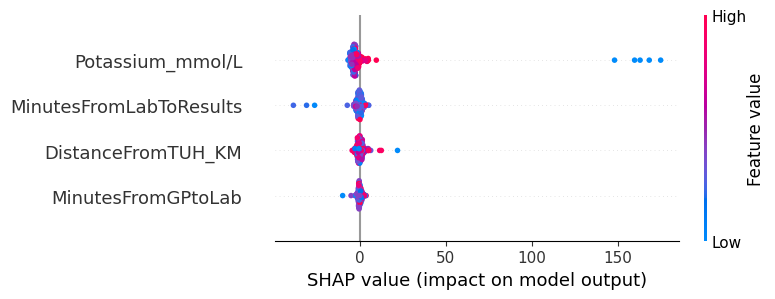

In [ ]:
import shap

explainer = shap.TreeExplainer(rf)
X_explain = X_test[:200]  # explain first 200 test samples
shap_values = explainer.shap_values(X_explain)

# Global summary (beeswarm)
shap.summary_plot(shap_values, X_explain, feature_names=feature_cols)



## Version 2

Haemolysis Prediction with Mixed Numeric & Categorical Features, Feature Reduction, and Tuned Random Forest (vs Model 3 Version 1 Numeric‑Only)

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# === 1. Define feature and target columns ===
feature_cols = [
    'DistanceFromTUH_KM',
    'Potassium_mmol/L',
    'MinutesFromGPtoLab',
    'MinutesFromLabToResults',
    'GP',                     # categorical
    'Who delivered samples',  # categorical
    'Delivery Window'         # categorical
]
target_col = 'Haemolysis'

# === 2. Split X and y ===
X = merged[feature_cols].copy()
y = merged[target_col].values  # continuous target

# === 3. Impute missing values ===
num_cols = [
    'DistanceFromTUH_KM',
    'Potassium_mmol/L',
    'MinutesFromGPtoLab',
    'MinutesFromLabToResults'
]
num_imputer = SimpleImputer(strategy='mean')
X_num_imputed = num_imputer.fit_transform(X[num_cols])

cat_cols = ['GP', 'Who delivered samples', 'Delivery Window']
cat_imputer = SimpleImputer(strategy='most_frequent')
X_cat_imputed = cat_imputer.fit_transform(X[cat_cols])

# === 4. One‐hot encode categorical variables ===
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_cat_enc = encoder.fit_transform(X_cat_imputed)
cat_feature_names = encoder.get_feature_names_out(cat_cols)

# === 5. Standardize numeric variables ===
scaler = StandardScaler()
X_num_std = scaler.fit_transform(X_num_imputed)

# === 6. Combine numeric + encoded categorical into final design matrix ===
X_final = np.hstack([X_num_std, X_cat_enc])
feature_names = num_cols + list(cat_feature_names)

# === 7. Fit OLS (ordinary least squares) regression ===
X_sm = sm.add_constant(X_final, has_constant='add')
ols_model = sm.OLS(y, X_sm).fit()
print("=== OLS Regression Summary ===")
print(ols_model.summary())

# Standardized OLS Coefficients (excluding intercept)
ols_coefs = pd.Series(ols_model.params[1:], index=feature_names)
print("\nStandardized OLS Coefficients:")
print(ols_coefs.sort_values(key=abs, ascending=False))

# === 8. Fit LassoCV to identify sparse predictors ===
lasso = LassoCV(cv=5, random_state=42).fit(X_final, y)
lasso_coefs = pd.Series(lasso.coef_, index=feature_names)

nonzero_coefs = lasso_coefs[lasso_coefs.abs() > 1e-4].sort_values(key=abs, ascending=False)
print("\n=== Lasso Nonzero Coefficients ===")
print(nonzero_coefs)


=== OLS Regression Summary ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     68.81
Date:                Wed, 08 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:06:26   Log-Likelihood:                -45373.
No. Observations:                9890   AIC:                         9.087e+04
Df Residuals:                    9828   BIC:                         9.132e+04
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.338e+12

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# === 1. Split X_final and y into train/test sets ===
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.20, random_state=42
)

# === 2. Fit Random Forest on the same features (numeric + one‐hot dummies) ===
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# === 3. Evaluate on the training set ===
y_train_pred = rf.predict(X_train)
print("RF R² (train):", r2_score(y_train, y_train_pred))
print("RF MAE (train):", mean_absolute_error(y_train, y_train_pred))

# === 4. Evaluate on the held‐out test set ===
y_test_pred = rf.predict(X_test)
print("RF R² (test):", r2_score(y_test, y_test_pred))
print("RF MAE (test):", mean_absolute_error(y_test, y_test_pred))


RF R² (train): 0.9146281364431567
RF MAE (train): 3.1280358361620686
RF R² (test): 0.516257161146215
RF MAE (test): 8.4209627961144


In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd

# === 1. Split X_final and y into train/test sets ===
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.20, random_state=42
)

# === 2. Fit Random Forest ===
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# === 3. Compute permutation importances on the test set ===
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# === 4. Create a Series indexed by feature_names ===
imp = pd.Series(perm.importances_mean, index=feature_names).sort_values(ascending=False)

print("Permutation Importances:\n", imp)


Permutation Importances:
 Potassium_mmol/L               1.342461
MinutesFromLabToResults        0.054337
GP_GP44                        0.015461
GP_GP40                        0.005778
GP_GP52                        0.003025
                                 ...   
GP_GP42                       -0.009359
DistanceFromTUH_KM            -0.017115
Delivery Window_14.30-15.00   -0.019061
MinutesFromGPtoLab            -0.027190
GP_GP18                       -0.043433
Length: 80, dtype: float64


In [ ]:
# 1. Identify the positively important feature names
pos_feats = imp[imp > 0].index.tolist()
# e.g., ['Potassium_mmol/L', 'MinutesFromLabToResults', 'GP_GP44', 'GP_GP40', ...]

# 2. Build X_pos by selecting only these columns from X_final
#    (Assume X_final’s columns align with feature_names in order)
X_pos = pd.DataFrame(X_final, columns=feature_names)[pos_feats].values

# 3. Train/test split on this reduced set
Xp_train, Xp_test, y_train, y_test = train_test_split(
    X_pos, y, test_size=0.20, random_state=42
)

# 4. Fit a new tuned random forest (or reuse rf_tuned settings)
from sklearn.ensemble import RandomForestRegressor
rf_small = RandomForestRegressor(
    n_estimators=200, max_depth=6, min_samples_leaf=5, random_state=42
).fit(Xp_train, y_train)

# 5. Evaluate
from sklearn.metrics import r2_score, mean_absolute_error
y_pred_sm = rf_small.predict(Xp_test)
print("Reduced RF R² (test):", r2_score(y_test, y_pred_sm))
print("Reduced RF MAE (test):", mean_absolute_error(y_test, y_pred_sm))


Reduced RF R² (test): 0.6537428941494745
Reduced RF MAE (test): 7.454292477019663


/tmp/ipython-input-568237746.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


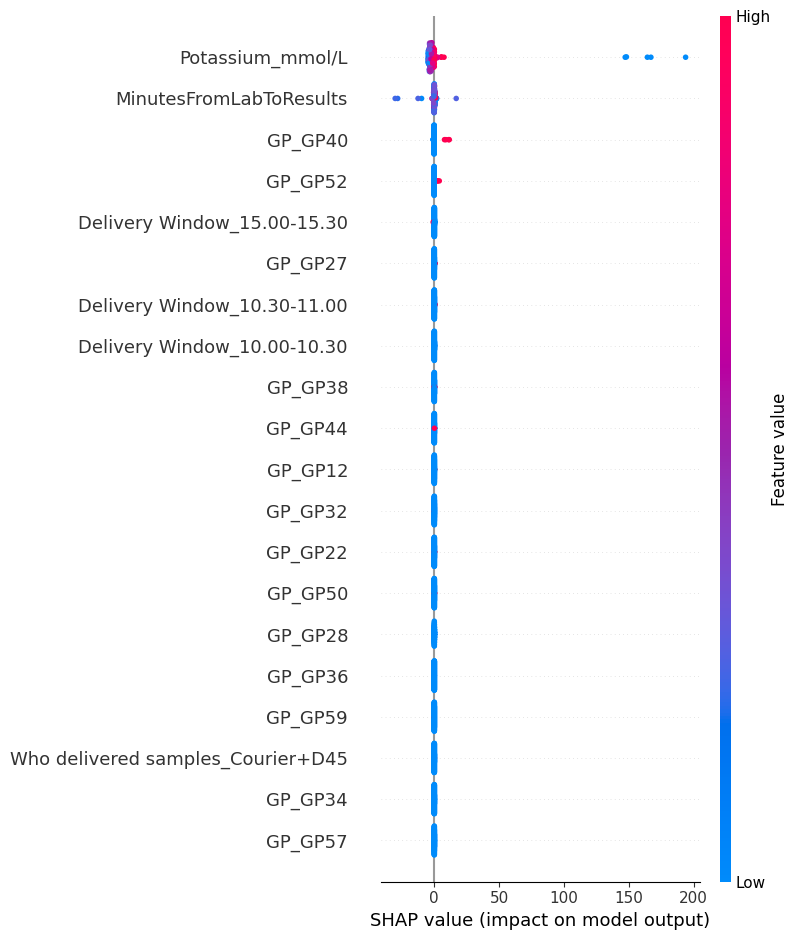

In [ ]:
import shap

# Use the reduced Random Forest (rf_small) and reduced feature set (Xp_test, pos_feats)
explainer = shap.TreeExplainer(rf_small)
Xp_explain = Xp_test[:200]  # explain first 200 rows of the reduced test set
shap_values_reduced = explainer.shap_values(Xp_explain)

# Global summary (beeswarm) for the reduced model
shap.summary_plot(
    shap_values_reduced,
    Xp_explain,
    feature_names=pos_feats
)


# Model 4 – Binned Haemolysis Scoring with Random Forest Regression and SHAP Feature Interpretation

## This model preprocesses haemolysis values by:

Filtering extreme values – removes samples with Haemolysis > 90.

Binning into ordinal categories – creates a ScoreOfHaemolysis (0–5) based on 15‑unit intervals.

Random Forest regression – predicts the haemolysis score using four numeric predictors (DistanceFromTUH_KM, Potassium_mmol/L, MinutesFromGPtoLab, MinutesFromLabToResults).

Feature importance analysis – extracts permutation‑based feature importances from the trained model.

Model explainability with SHAP – applies TreeSHAP to compute and visualise global feature influence via a summary plot.

In [ ]:
import numpy as np
import pandas as pd

# 1. Drop any rows where Haemolysis > 90
merged = merged[merged['Haemolysis'] <= 90].copy()

# 2. Define bin edges and labels
#    Edges: 0, 15, 30, 45, 60, 75, 90
bins = np.arange(0, 91, 15)
labels = list(range(len(bins) - 1))  # [0, 1, 2, 3, 4, 5]

# 3. Create the new binned “ScoreOfHaemolysis” column
merged['ScoreOfHaemolysis'] = pd.cut(
    merged['Haemolysis'],
    bins=bins,
    labels=labels,
    include_lowest=True,   # put Haemolysis == 0 into bin 0
    right=True             # (a, b] intervals, so 15→1, 90→5
)

# 4. Convert to integer dtype
merged['ScoreOfHaemolysis'] = merged['ScoreOfHaemolysis'].astype(int)

# Now `df` contains only Haemolysis ≤ 90, and ScoreOfHaemolysis in {0,1,2,3,4,5}.
print(merged[['Haemolysis','ScoreOfHaemolysis']].head(10))

   Haemolysis  ScoreOfHaemolysis
0           3                  0
1           6                  0
2           4                  0
3          11                  0
4          36                  2
5           5                  0
6           6                  0
7           5                  0
8          16                  1
9           7                  0


In [ ]:
merged.head(10)

,DateSampleTaken,TimeSampleTaken,DateReceivedLab,TimeReceivedLab,DateResultReported,TimeResultReported,GP,DistanceFromTUH_KM,Potassium_mmol/L,Haemolysis,...,DatetimeReceivedLab,DatetimeResultReported,MinutesFromGPtoLab,MinutesFromLabToResults,HaemolysisScore,Results,Distance from TUH Lab in KMs,Who delivered samples,Delivery Window,ScoreOfHaemolysis
0,2023-02-13,18:22:00,2023-02-13,18:22:00,2023-02-15,09:18:00,GP51,1.3,4.2,3,...,2023-02-13 18:22:00,2023-02-15 09:18:00,215.0,2336.0,0,8,1.3,Courier,12.00-12.30,0
1,2023-02-09,11:00:00,2023-02-09,16:50:00,2023-02-10,14:19:00,GP01,1.1,3.8,6,...,2023-02-09 16:50:00,2023-02-10 14:19:00,350.0,1639.0,0,8,1.1,Courier,12.00-12.30,0
2,2023-01-17,09:45:00,2023-01-17,15:56:00,2023-01-18,15:31:00,GP33,6.5,3.9,4,...,2023-01-17 15:56:00,2023-01-18 15:31:00,371.0,1786.0,0,8,6.5,Courier,16.00-16.30,0
3,2023-01-11,16:16:00,2023-01-11,16:47:00,2023-01-12,12:18:00,GP10,5.7,4.8,11,...,2023-01-11 16:47:00,2023-01-12 12:18:00,31.0,1202.0,0,8,5.7,Courier,14.30-15.00,0
4,2023-01-23,12:44:00,2023-01-23,14:01:00,2023-01-23,15:26:00,GP40,7.8,4.3,36,...,2023-01-23 14:01:00,2023-01-23 15:26:00,77.0,162.0,0,8,7.8,Courier,14.30-15.00,2
5,2023-02-17,12:27:00,2023-02-17,12:27:00,2023-02-20,10:11:00,GP58,5.5,6.2,5,...,2023-02-17 12:27:00,2023-02-20 10:11:00,215.0,4184.0,0,2,5.5,Courier,12.00-12.30,0
6,2023-01-11,16:07:00,2023-01-11,16:47:00,2023-01-12,08:54:00,GP31,2.4,3.9,6,...,2023-01-11 16:47:00,2023-01-12 08:54:00,40.0,1007.0,0,8,2.4,Courier,12.00-12.30,0
7,2023-02-07,15:15:00,2023-02-07,15:15:00,2023-02-08,16:38:00,GP39,6.4,3.7,5,...,2023-02-07 15:15:00,2023-02-08 16:38:00,215.0,1523.0,0,8,6.4,Courier,14.30-15.00,0
8,2023-02-20,16:07:00,2023-02-20,16:07:00,2023-02-21,08:47:00,GP12,4.3,4.5,16,...,2023-02-20 16:07:00,2023-02-21 08:47:00,215.0,1000.0,0,8,4.3,Courier,14.30-15.00,1
9,2023-01-30,10:10:00,2023-01-30,17:52:00,2023-01-31,10:05:00,GP31,2.4,4.6,7,...,2023-01-30 17:52:00,2023-01-31 10:05:00,462.0,1435.0,0,8,2.4,Courier,12.00-12.30,0


In [ ]:
# Compute counts per rating
counts = merged['ScoreOfHaemolysis'].value_counts().sort_index()

print("Distribution of Haemolysis Scores (0–5):")
print(counts)


Distribution of Haemolysis Scores (0–5):
ScoreOfHaemolysis
0    8353
1     921
2     267
3     112
4      60
5      36
Name: count, dtype: int64


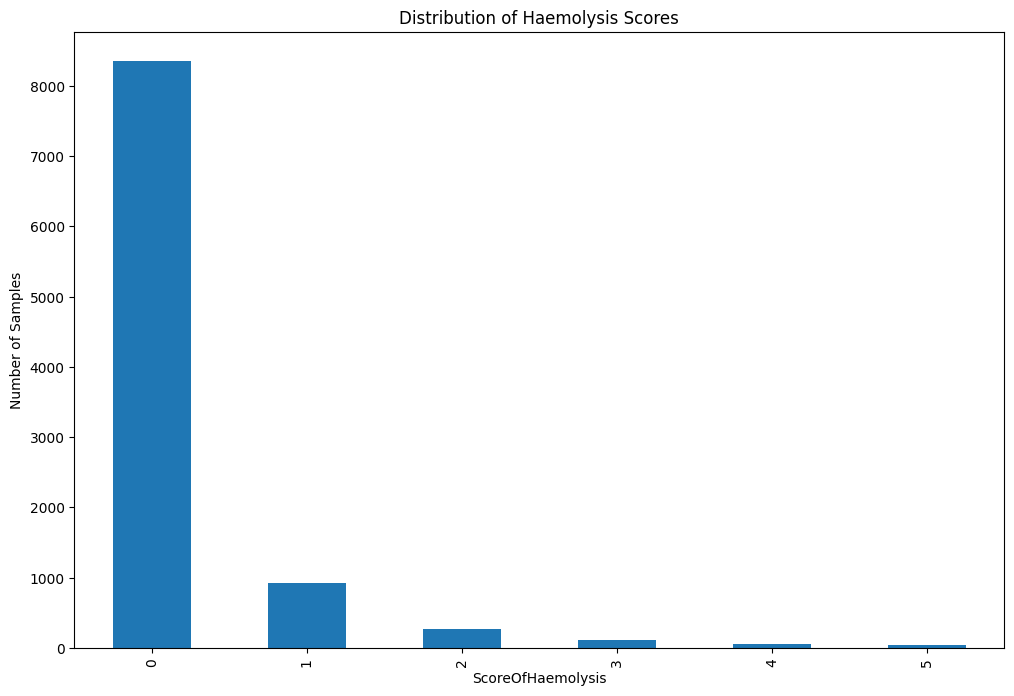

In [ ]:
import matplotlib.pyplot as plt

counts.plot(kind='bar')
plt.xlabel('ScoreOfHaemolysis')
plt.ylabel('Number of Samples')
plt.title('Distribution of Haemolysis Scores')
plt.show()


Feature importances for predicting Haemolysis:
                feature  importance
MinutesFromLabToResults    0.479763
     MinutesFromGPtoLab    0.217652
     DistanceFromTUH_KM    0.152104
       Potassium_mmol/L    0.150481


/tmp/ipython-input-3887940682.py:41: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=feature_cols)


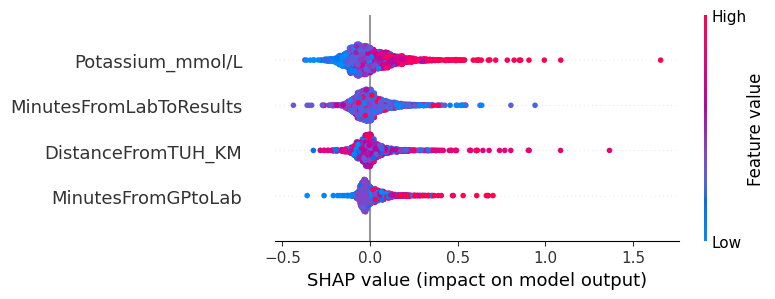

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

y = merged['ScoreOfHaemolysis']

# Features: numeric columns
feature_cols = [
    'DistanceFromTUH_KM',
    'Potassium_mmol/L',
    'MinutesFromGPtoLab',
    'MinutesFromLabToResults'
]
X = merged[feature_cols].copy()

# === 3. Split into train/test sets ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# === 4. Fit a Random Forest regressor ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# === 5. Extract and display feature importances ===
fi = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Feature importances for predicting Haemolysis:")
print(fi.to_string(index=False))

# === 6. Compute and visualize SHAP values (TreeSHAP) ===
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# 6a. SHAP summary plot (global importance)
shap.summary_plot(shap_values, X_test, feature_names=feature_cols)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1. Predict on the test set
y_pred = rf.predict(X_test)

# 2. Compute R²
r2 = r2_score(y_test, y_pred)
print(f"R² on test set: {r2:.3f}")

# 3. Compute Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.3f}")

# 4. Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:.3f}")


R² on test set: -0.086
Test MSE: 0.485
Test MAE: 0.393


# Model 5 – Numeric‑Only Haemolysis Prediction with OLS, Lasso, and Random Forest SHAP Analysis

## Description:
This model predicts continuous haemolysis values using only numeric predictors by:

Feature selection: Uses four numeric features (DistanceFromTUH_KM, Potassium_mmol/L, MinutesFromGPtoLab, MinutesFromLabToResults).

Preprocessing: Imputes missing values (mean) and standardises features (z‑score).

OLS regression: Estimates standardised coefficients to assess linear relationships.

LassoCV: Identifies sparse predictors via 5‑fold cross‑validation.

Random Forest regression: Evaluates non‑linear relationships and computes permutation‑based feature importances.

Model explainability: Applies TreeSHAP to visualise global feature influence via a beeswarm plot.

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# === 1. Define numeric feature and target columns ===
feature_cols = [
    'DistanceFromTUH_KM',
    'Potassium_mmol/L',
    'MinutesFromGPtoLab',
    'MinutesFromLabToResults'
]
target_col = 'Haemolysis'

# === 2. Split X and y ===
X = merged[feature_cols].copy()
y = merged[target_col].values  # continuous target

# === 3. Impute missing values for numeric features ===
num_imputer = SimpleImputer(strategy='mean')
X_num_imputed = num_imputer.fit_transform(X)

# === 4. Standardize numeric variables ===
scaler = StandardScaler()
X_num_std = scaler.fit_transform(X_num_imputed)

# Now X_final consists only of the four standardized numeric columns
X_final = X_num_std
feature_names = feature_cols

# === 5. Fit OLS (ordinary least squares) regression ===
# Add constant term for intercept
X_sm = sm.add_constant(X_final, has_constant='add')
ols_model = sm.OLS(y, X_sm).fit()
print("=== OLS Regression Summary ===")
print(ols_model.summary())

# Standardized OLS Coefficients (excluding intercept)
ols_coefs = pd.Series(ols_model.params[1:], index=feature_names)
print("\nStandardized OLS Coefficients:")
print(ols_coefs.sort_values(key=abs, ascending=False))

# === 6. Fit LassoCV to identify sparse predictors ===
lasso = LassoCV(cv=5, random_state=42).fit(X_final, y)
lasso_coefs = pd.Series(lasso.coef_, index=feature_names)

nonzero_coefs = lasso_coefs[lasso_coefs.abs() > 1e-4].sort_values(key=abs, ascending=False)
print("\n=== Lasso Nonzero Coefficients ===")
print(nonzero_coefs)


=== OLS Regression Summary ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     84.89
Date:                Wed, 08 Oct 2025   Prob (F-statistic):           5.43e-71
Time:                        15:12:37   Log-Likelihood:                -36793.
No. Observations:                9749   AIC:                         7.360e+04
Df Residuals:                    9744   BIC:                         7.363e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7048

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_final, y)
y_pred = rf.predict(X_final)
print("RF R² (train):", r2_score(y, y_pred))
print("RF MAE (train):", mean_absolute_error(y, y_pred))


RF R² (train): 0.8490329654893577
RF MAE (train): 2.610779480842154


In [ ]:
from sklearn.inspection import permutation_importance
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train, y_train)
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
imp = pd.Series(perm.importances_mean, index=feature_cols).sort_values(ascending=False)
print("Permutation Importances:\n", imp)


Permutation Importances:
 Potassium_mmol/L           0.106268
DistanceFromTUH_KM         0.041232
MinutesFromGPtoLab         0.022987
MinutesFromLabToResults    0.021980
dtype: float64


/tmp/ipython-input-2026405905.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_explain, feature_names=feature_cols)


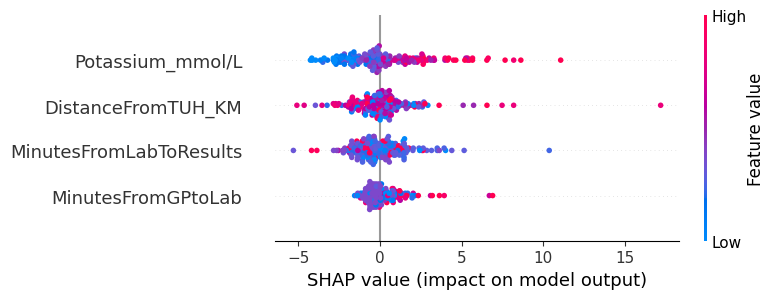

In [ ]:
import shap

explainer = shap.TreeExplainer(rf)
X_explain = X_test[:200]  # explain first 200 test samples
shap_values = explainer.shap_values(X_explain)

# Global summary (beeswarm)
shap.summary_plot(shap_values, X_explain, feature_names=feature_cols)



## Model 5 v2 – Mixed Numeric & Categorical Haemolysis Prediction with OLS, Lasso, Random Forest, and SHAP Analysis

## Key Differences – Model 5 v1 vs Model 5 v2

### 1. Input Features
- **v1:** Only numeric features:  
  - DistanceFromTUH_KM  
  - Potassium_mmol/L  
  - MinutesFromGPtoLab  
  - MinutesFromLabToResults  
- **v2:** Includes the same four numeric features **plus three categorical features**:  
  - GP  
  - Who delivered samples  
  - Delivery Window  

### 2. Preprocessing
- **v1:**  
  - Mean imputation for numeric features  
  - Standardisation (z‑score) for numeric features only  
- **v2:**  
  - Mean imputation for numeric features  
  - Most‑frequent imputation for categorical features  
  - One‑hot encoding for categorical variables (`drop='first'`)  
  - Standardisation applied only to numeric features  
  - Numeric + encoded categorical features combined into final matrix  

### 3. Model Inputs
- **v1:** OLS, LassoCV, Random Forest, and SHAP run **only on numeric features**.  
- **v2:** OLS, LassoCV, Random Forest, and SHAP run **on mixed numeric + encoded categorical features**.  

### 4. Explainability Output
- **v1:** SHAP beeswarm plot for the full numeric feature set.  
- **v2:** SHAP beeswarm plot appears intended for a reduced Random Forest model (`rf_small`) and reduced feature set (`pos_feats`) — though `rf_small` and `pos_feats` are not defined in the provided code block, suggesting it’s adapted from a reduced‑feature approach like in your earlier categorical models.  


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# === 1. Define feature and target columns ===
feature_cols = [
    'DistanceFromTUH_KM',
    'Potassium_mmol/L',
    'MinutesFromGPtoLab',
    'MinutesFromLabToResults',
    'GP',                     # categorical
    'Who delivered samples',  # categorical
    'Delivery Window'         # categorical
]
target_col = 'Haemolysis'

# === 2. Split X and y ===
X = merged[feature_cols].copy()
y = merged[target_col].values  # continuous target

# === 3. Impute missing values ===
num_cols = [
    'DistanceFromTUH_KM',
    'Potassium_mmol/L',
    'MinutesFromGPtoLab',
    'MinutesFromLabToResults'
]
num_imputer = SimpleImputer(strategy='mean')
X_num_imputed = num_imputer.fit_transform(X[num_cols])

cat_cols = ['GP', 'Who delivered samples', 'Delivery Window']
cat_imputer = SimpleImputer(strategy='most_frequent')
X_cat_imputed = cat_imputer.fit_transform(X[cat_cols])

# === 4. One‐hot encode categorical variables ===
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_cat_enc = encoder.fit_transform(X_cat_imputed)
cat_feature_names = encoder.get_feature_names_out(cat_cols)

# === 5. Standardize numeric variables ===
scaler = StandardScaler()
X_num_std = scaler.fit_transform(X_num_imputed)

# === 6. Combine numeric + encoded categorical into final design matrix ===
X_final = np.hstack([X_num_std, X_cat_enc])
feature_names = num_cols + list(cat_feature_names)

# === 7. Fit OLS (ordinary least squares) regression ===
X_sm = sm.add_constant(X_final, has_constant='add')
ols_model = sm.OLS(y, X_sm).fit()
print("=== OLS Regression Summary ===")
print(ols_model.summary())

# Standardized OLS Coefficients (excluding intercept)
ols_coefs = pd.Series(ols_model.params[1:], index=feature_names)
print("\nStandardized OLS Coefficients:")
print(ols_coefs.sort_values(key=abs, ascending=False))

# === 8. Fit LassoCV to identify sparse predictors ===
lasso = LassoCV(cv=5, random_state=42).fit(X_final, y)
lasso_coefs = pd.Series(lasso.coef_, index=feature_names)

nonzero_coefs = lasso_coefs[lasso_coefs.abs() > 1e-4].sort_values(key=abs, ascending=False)
print("\n=== Lasso Nonzero Coefficients ===")
print(nonzero_coefs)


=== OLS Regression Summary ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     12.31
Date:                Wed, 08 Oct 2025   Prob (F-statistic):          2.30e-114
Time:                        15:13:25   Log-Likelihood:                -36596.
No. Observations:                9749   AIC:                         7.332e+04
Df Residuals:                    9687   BIC:                         7.376e+04
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.394e+12

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# === 1. Split X_final and y into train/test sets ===
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.20, random_state=42
)

# === 2. Fit Random Forest on the same features (numeric + one‐hot dummies) ===
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# === 3. Evaluate on the training set ===
y_train_pred = rf.predict(X_train)
print("RF R² (train):", r2_score(y_train, y_train_pred))
print("RF MAE (train):", mean_absolute_error(y_train, y_train_pred))

# === 4. Evaluate on the held‐out test set ===
y_test_pred = rf.predict(X_test)
print("RF R² (test):", r2_score(y_test, y_test_pred))
print("RF MAE (test):", mean_absolute_error(y_test, y_test_pred))


RF R² (train): 0.8471917564744766
RF MAE (train): 2.593818411479105
RF R² (test): -0.08805115336642344
RF MAE (test): 7.021690027195028


In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd

# === 1. Split X_final and y into train/test sets ===
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.20, random_state=42
)

# === 2. Fit Random Forest ===
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# === 3. Compute permutation importances on the test set ===
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# === 4. Create a Series indexed by feature_names ===
imp = pd.Series(perm.importances_mean, index=feature_names).sort_values(ascending=False)

print("Permutation Importances:\n", imp)


Permutation Importances:
 Potassium_mmol/L                 0.096608
GP_GP40                          0.033738
MinutesFromGPtoLab               0.015260
MinutesFromLabToResults          0.009394
GP_GP11                          0.003152
                                   ...   
Who delivered samples_Courier   -0.007758
GP_GP10                         -0.007988
GP_GP18                         -0.010053
Delivery Window_14.30-15.00     -0.022261
DistanceFromTUH_KM              -0.042075
Length: 80, dtype: float64


In [ ]:
# 1. Identify the positively important feature names
pos_feats = imp[imp > 0].index.tolist()
# e.g., ['Potassium_mmol/L', 'MinutesFromLabToResults', 'GP_GP44', 'GP_GP40', ...]

# 2. Build X_pos by selecting only these columns from X_final
#    (Assume X_final’s columns align with feature_names in order)
X_pos = pd.DataFrame(X_final, columns=feature_names)[pos_feats].values

# 3. Train/test split on this reduced set
Xp_train, Xp_test, y_train, y_test = train_test_split(
    X_pos, y, test_size=0.20, random_state=42
)

# 4. Fit a new tuned random forest (or reuse rf_tuned settings)
from sklearn.ensemble import RandomForestRegressor
rf_small = RandomForestRegressor(
    n_estimators=200, max_depth=6, min_samples_leaf=5, random_state=42
).fit(Xp_train, y_train)

# 5. Evaluate
from sklearn.metrics import r2_score, mean_absolute_error
y_pred_sm = rf_small.predict(Xp_test)
print("Reduced RF R² (test):", r2_score(y_test, y_pred_sm))
print("Reduced RF MAE (test):", mean_absolute_error(y_test, y_pred_sm))


Reduced RF R² (test): 0.07189699760459933
Reduced RF MAE (test): 6.288792172932067


/tmp/ipython-input-568237746.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


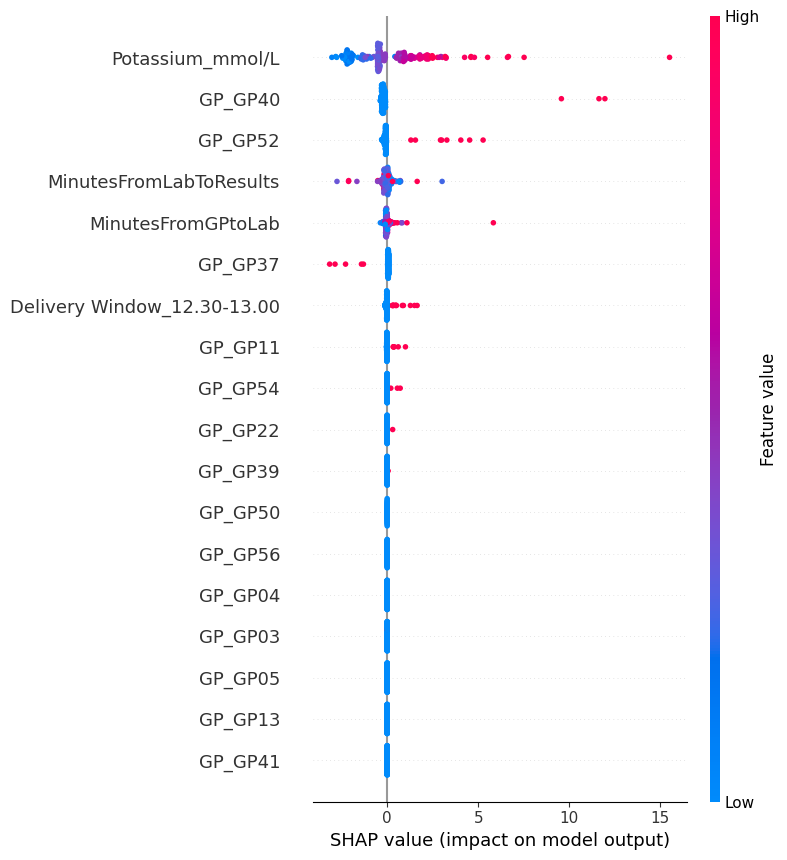

In [ ]:
import shap

# Use the reduced Random Forest (rf_small) and reduced feature set (Xp_test, pos_feats)
explainer = shap.TreeExplainer(rf_small)
Xp_explain = Xp_test[:200]  # explain first 200 rows of the reduced test set
shap_values_reduced = explainer.shap_values(Xp_explain)

# Global summary (beeswarm) for the reduced model
shap.summary_plot(
    shap_values_reduced,
    Xp_explain,
    feature_names=pos_feats
)


# Model 6 – Filtered Low‑Range Haemolysis Prediction with Random Forest Regression and SHAP Feature Interpretation

## Description:
This model focuses on predicting haemolysis values within a restricted low‑range subset by:  

- **Filtering data:** Retains only samples with *Haemolysis ≤ 30*.  
- **Binning for analysis:** Creates `ScoreOfHaemolysis` categories (0–5) using 5‑unit intervals to inspect distribution, but keeps original continuous haemolysis values for modelling.  
- **Feature selection:** Uses four numeric predictors (*DistanceFromTUH_KM*, *Potassium_mmol/L*, *MinutesFromGPtoLab*, *MinutesFromLabToResults*).  
- **Random Forest regression:** Trains with `n_estimators=100`, `random_state=42` to capture non‑linear relationships in the restricted dataset.  
- **Feature importance:** Extracts Random Forest feature importances for model interpretation.  
- **Model explainability:** Applies TreeSHAP to visualise global feature influence via a beeswarm plot.  


In [ ]:
import numpy as np
import pandas as pd

# 1. Drop any rows where Haemolysis > 90
merged = merged[merged['Haemolysis'] <= 30].copy()

# 2. Define bin edges and labels
#    Edges: 0, 15, 30, 45, 60, 75, 90
bins = np.arange(0, 31, 5)
labels = list(range(len(bins) - 1))  # [0, 1, 2, 3, 4, 5]

# 3. Create the new binned “ScoreOfHaemolysis” column
merged['ScoreOfHaemolysis'] = pd.cut(
    merged['Haemolysis'],
    bins=bins,
    labels=labels,
    include_lowest=True,   # put Haemolysis == 0 into bin 0
    right=True             # (a, b] intervals, so 15→1, 90→5
)

# 4. Convert to integer dtype
merged['ScoreOfHaemolysis'] = merged['ScoreOfHaemolysis'].astype(int)

# Now `df` contains only Haemolysis ≤ 90, and ScoreOfHaemolysis in {0,1,2,3,4,5}.
print(merged[['Haemolysis','ScoreOfHaemolysis']].head(10))


    Haemolysis  ScoreOfHaemolysis
0            3                  0
1            6                  1
2            4                  0
3           11                  2
5            5                  0
6            6                  1
7            5                  0
8           16                  3
9            7                  1
10           1                  0


In [ ]:
merged.head(10)

,DateSampleTaken,TimeSampleTaken,DateReceivedLab,TimeReceivedLab,DateResultReported,TimeResultReported,GP,DistanceFromTUH_KM,Potassium_mmol/L,Haemolysis,...,Delivery Window_10.00-10.30,Delivery Window_10.30-11.00,Delivery Window_11.00-11.30,Delivery Window_12.00-12.30,Delivery Window_12.30-13.00,Delivery Window_13.00-13.30,Delivery Window_13.30-14.00,Delivery Window_14.30-15.00,Delivery Window_15.00-15.30,Delivery Window_16.00-16.30
0,2023-02-13,18:22:00,2023-02-13,18:22:00,2023-02-15,09:18:00,GP51,1.3,4.2,3,...,False,False,False,True,False,False,False,False,False,False
1,2023-02-09,11:00:00,2023-02-09,16:50:00,2023-02-10,14:19:00,GP01,1.1,3.8,6,...,False,False,False,True,False,False,False,False,False,False
2,2023-01-17,09:45:00,2023-01-17,15:56:00,2023-01-18,15:31:00,GP33,6.5,3.9,4,...,False,False,False,False,False,False,False,False,False,True
3,2023-01-11,16:16:00,2023-01-11,16:47:00,2023-01-12,12:18:00,GP10,5.7,4.8,11,...,False,False,False,False,False,False,False,True,False,False
5,2023-02-17,12:27:00,2023-02-17,12:27:00,2023-02-20,10:11:00,GP58,5.5,6.2,5,...,False,False,False,True,False,False,False,False,False,False
6,2023-01-11,16:07:00,2023-01-11,16:47:00,2023-01-12,08:54:00,GP31,2.4,3.9,6,...,False,False,False,True,False,False,False,False,False,False
7,2023-02-07,15:15:00,2023-02-07,15:15:00,2023-02-08,16:38:00,GP39,6.4,3.7,5,...,False,False,False,False,False,False,False,True,False,False
8,2023-02-20,16:07:00,2023-02-20,16:07:00,2023-02-21,08:47:00,GP12,4.3,4.5,16,...,False,False,False,False,False,False,False,True,False,False
9,2023-01-30,10:10:00,2023-01-30,17:52:00,2023-01-31,10:05:00,GP31,2.4,4.6,7,...,False,False,False,True,False,False,False,False,False,False
10,2023-01-30,16:03:00,2023-01-30,16:03:00,2023-01-31,11:52:00,GP16,2.5,4.7,1,...,False,False,False,True,False,False,False,False,False,False


In [ ]:
# Compute counts per rating
counts = merged['ScoreOfHaemolysis'].value_counts().sort_index()

print("Distribution of Haemolysis Scores (0–5):")
print(counts)


Distribution of Haemolysis Scores (0–5):
ScoreOfHaemolysis
0    3882
1    3196
2    1275
3     526
4     254
5     141
Name: count, dtype: int64


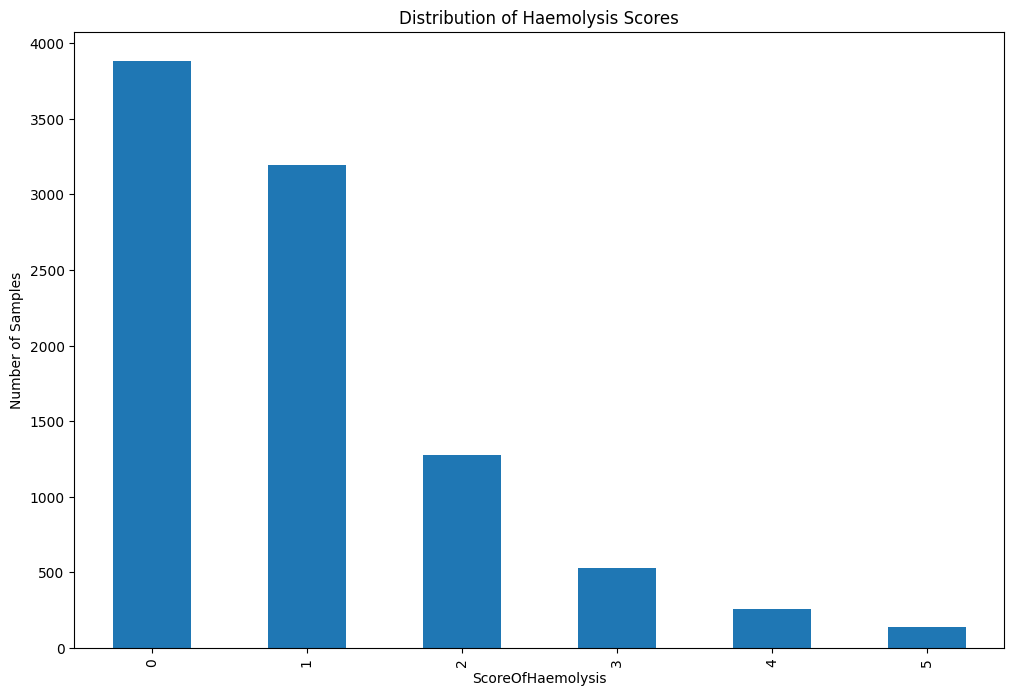

In [ ]:
import matplotlib.pyplot as plt

counts.plot(kind='bar')
plt.xlabel('ScoreOfHaemolysis')
plt.ylabel('Number of Samples')
plt.title('Distribution of Haemolysis Scores')
plt.show()


Feature importances for predicting Haemolysis:
                feature  importance
MinutesFromLabToResults    0.469309
     MinutesFromGPtoLab    0.215857
     DistanceFromTUH_KM    0.173858
       Potassium_mmol/L    0.140976


/tmp/ipython-input-542874.py:41: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=feature_cols)


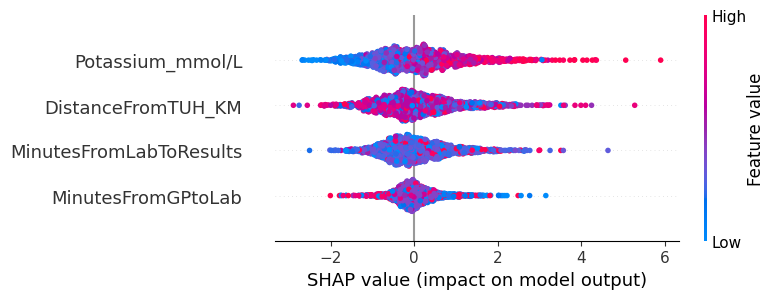

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

y = merged['Haemolysis']

# Features: numeric columns
feature_cols = [
    'DistanceFromTUH_KM',
    'Potassium_mmol/L',
    'MinutesFromGPtoLab',
    'MinutesFromLabToResults'
]
X = merged[feature_cols].copy()

# === 3. Split into train/test sets ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# === 4. Fit a Random Forest regressor ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# === 5. Extract and display feature importances ===
fi = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Feature importances for predicting Haemolysis:")
print(fi.to_string(index=False))

# === 6. Compute and visualize SHAP values (TreeSHAP) ===
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# 6a. SHAP summary plot (global importance)
shap.summary_plot(shap_values, X_test, feature_names=feature_cols)

## Model 6 v2 – Enhanced Haemolysis Prediction with Mixed Features, Random Forest Evaluation, and SHAP Analysis

### **Description:**  
This model expands on Model 6 by incorporating both numeric and categorical predictors, adding explicit evaluation metrics, and using SHAP for feature interpretation by:  

- **Feature selection:**  
  - **Numeric features:** *MinutesFromGPtoLab*, *MinutesFromLabToResults*, *Potassium_mmol/L*  
  - **Categorical features (one‑hot encoded):** *DistanceFromTUH_Cat*, *Who delivered samples*, *Delivery Window*  

- **Preprocessing:**  
  - Renames and encodes categorical variables using one‑hot encoding (`drop_first=True`)  
  - Drops missing values before modelling  

- **Random Forest regression:** Trains with `n_estimators=100`, `random_state=42` on mixed feature set  

- **Model evaluation:** Reports R², MSE, MAE, and percentage accuracy within ±1 haemolysis unit on test data  

- **Feature importance:** Extracts and ranks Random Forest feature importances  

- **Model explainability:** Applies TreeSHAP to compute SHAP values and visualises global feature importance using a bar plot  

R²: -0.071
MSE: 34.309
MAE: 4.452
Accuracy within ±1 unit: 14.07%


/tmp/ipython-input-1079608427.py:37: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=feature_cols, plot_type='bar')


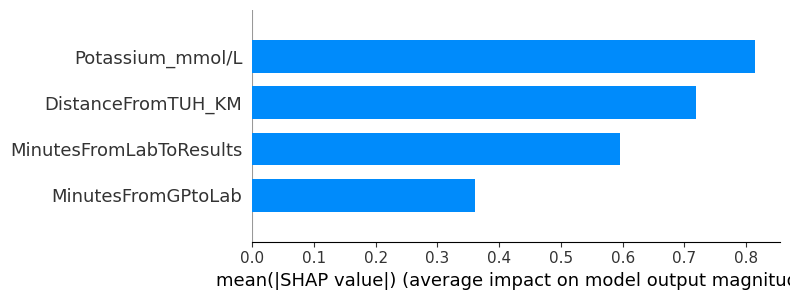

                   feature  importance
3  MinutesFromLabToResults    0.469309
2       MinutesFromGPtoLab    0.215857
0       DistanceFromTUH_KM    0.173858
1         Potassium_mmol/L    0.140976


In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# === 1. Feature prep ===
feature_cols = ['DistanceFromTUH_KM', 'Potassium_mmol/L', 'MinutesFromGPtoLab', 'MinutesFromLabToResults']
X = merged[feature_cols].copy()
y = merged['Haemolysis']

# Handle missing data
X = X.dropna()
y = y.loc[X.index]

# === 2. Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 3. Fit model ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# === 4. Evaluation ===
y_pred = rf.predict(X_test)
print(f"R²: {r2_score(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"Accuracy within ±1 unit: {np.mean(np.abs(y_pred - y_test) <= 1):.2%}")

# === 5. SHAP analysis ===
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_cols, plot_type='bar')

# === 6. Feature importance ===
fi = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)
print(fi)


In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# === 1. Rename categorical variable to match style ===
merged.rename(columns={'Distance from TUH Lab in KMs': 'DistanceFromTUH_Cat'}, inplace=True)

# === 2. Encode categorical variables ===
categorical_cols = ['DistanceFromTUH_Cat', 'Who delivered samples', 'Delivery Window']
merged = pd.get_dummies(merged, columns=categorical_cols, drop_first=True)

# === 3. Select final features ===
feature_cols = [
    'MinutesFromGPtoLab',
    'MinutesFromLabToResults',
    'Potassium_mmol/L'
] + [col for col in merged.columns if col.startswith(('DistanceFromTUH_Cat_', 'Who delivered samples_', 'Delivery Window_'))]

# === 4. Define X and y ===
X = merged[feature_cols].copy()
y = merged['Haemolysis']

# === 5. Drop missing values ===
X = X.dropna()
y = y.loc[X.index]

# === 6. Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# === 7. Train Random Forest ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# === 8. Evaluate ===
y_pred = rf.predict(X_test)
print(f"R²: {r2_score(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"Accuracy within ±1 unit: {np.mean(np.abs(y_pred - y_test) <= 1):.2%}")

# === 9. Feature Importances ===
fi = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)
print(fi)

# === 10. SHAP Analysis ===
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, plot_type='bar')


KeyError: "None of [Index(['DistanceFromTUH_Cat', 'Who delivered samples', 'Delivery Window'], dtype='object')] are in the [columns]"

In [ ]:
import seaborn as sns
sns.histplot(y, bins=30)
print(y.value_counts())


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1. Predict on the test set
y_pred = rf.predict(X_test)

# 2. Compute R²
r2 = r2_score(y_test, y_pred)
print(f"R² on test set: {r2:.3f}")

# 3. Compute Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.3f}")

# 4. Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:.3f}")


# Model 7

In [ ]:
print(merged.columns.tolist())


['DateSampleTaken', 'TimeSampleTaken', 'DateReceivedLab', 'TimeReceivedLab', 'DateResultReported', 'TimeResultReported', 'GP', 'DistanceFromTUH_KM', 'Potassium_mmol/L', 'Haemolysis', 'DatetimeSampleTaken', 'DatetimeReceivedLab', 'DatetimeResultReported', 'MinutesFromGPtoLab', 'MinutesFromLabToResults', 'HaemolysisScore', 'Results', 'ScoreOfHaemolysis', 'DistanceFromTUH_Cat_0.9', 'DistanceFromTUH_Cat_1.1', 'DistanceFromTUH_Cat_1.3', 'DistanceFromTUH_Cat_2.1', 'DistanceFromTUH_Cat_2.4', 'DistanceFromTUH_Cat_2.5', 'DistanceFromTUH_Cat_2.6', 'DistanceFromTUH_Cat_2.7', 'DistanceFromTUH_Cat_2.8', 'DistanceFromTUH_Cat_2.9', 'DistanceFromTUH_Cat_3.0', 'DistanceFromTUH_Cat_3.1', 'DistanceFromTUH_Cat_3.2', 'DistanceFromTUH_Cat_3.4', 'DistanceFromTUH_Cat_3.5', 'DistanceFromTUH_Cat_4.3', 'DistanceFromTUH_Cat_4.4', 'DistanceFromTUH_Cat_4.5', 'DistanceFromTUH_Cat_4.9', 'DistanceFromTUH_Cat_5.1', 'DistanceFromTUH_Cat_5.3', 'DistanceFromTUH_Cat_5.5', 'DistanceFromTUH_Cat_5.7', 'DistanceFromTUH_Cat_5.8


=== XGBoost Regression Performance (No Delivery Window) ===
R²: 0.564
MSE: 291.060
MAE: 7.786
Accuracy within ±1 unit: 10.21%

=== Feature Importances ===
                Feature  Importance
       Potassium_mmol/L    0.858649
MinutesFromLabToResults    0.095409
     MinutesFromGPtoLab    0.045942


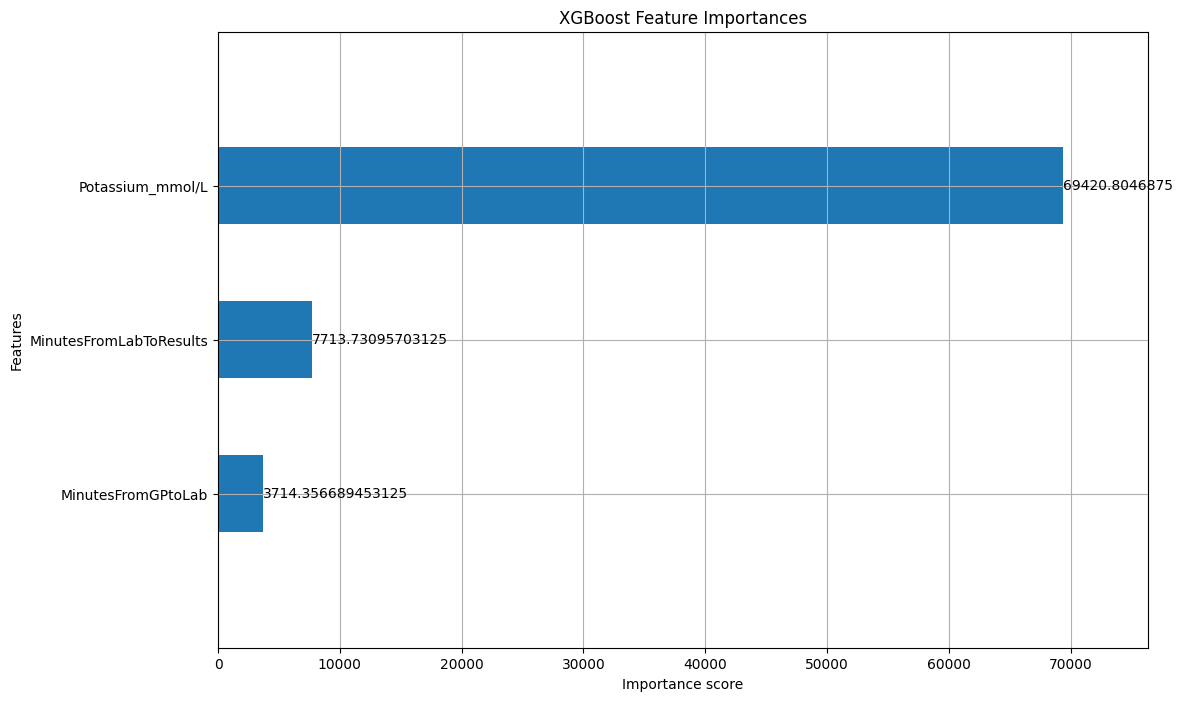

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# === 1. Define top features and target ===
feature_cols = [
    'MinutesFromLabToResults',
    'MinutesFromGPtoLab',
    'Potassium_mmol/L'
]

X = merged[feature_cols].copy()
y = merged['Haemolysis']

# === 2. Drop missing values ===
X = X.dropna()
y = y.loc[X.index]

# === 3. Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 4. Train XGBoost Regressor ===
xgbr = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgbr.fit(X_train, y_train)

# === 5. Evaluate the model ===
y_pred = xgbr.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
acc1 = np.mean(np.abs(y_pred - y_test) <= 1)

print("\n=== XGBoost Regression Performance (No Delivery Window) ===")
print(f"R²: {r2:.3f}")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"Accuracy within ±1 unit: {acc1:.2%}")

# === 6. Feature Importances as Table ===
fi_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgbr.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n=== Feature Importances ===")
print(fi_df.to_string(index=False))

# === 7. Optional: Visual Plot ===
xgb.plot_importance(xgbr, importance_type='gain', height=0.5)
plt.title("XGBoost Feature Importances")
plt.show()



=== XGBoost Performance (Haemolysis < 30) ===
R²: -0.004
MSE: 11.713
MAE: 2.793
Accuracy within ±1 unit: 21.32%

=== Feature Importances ===
                Feature  Importance
MinutesFromLabToResults    0.342149
     MinutesFromGPtoLab    0.330111
       Potassium_mmol/L    0.327739


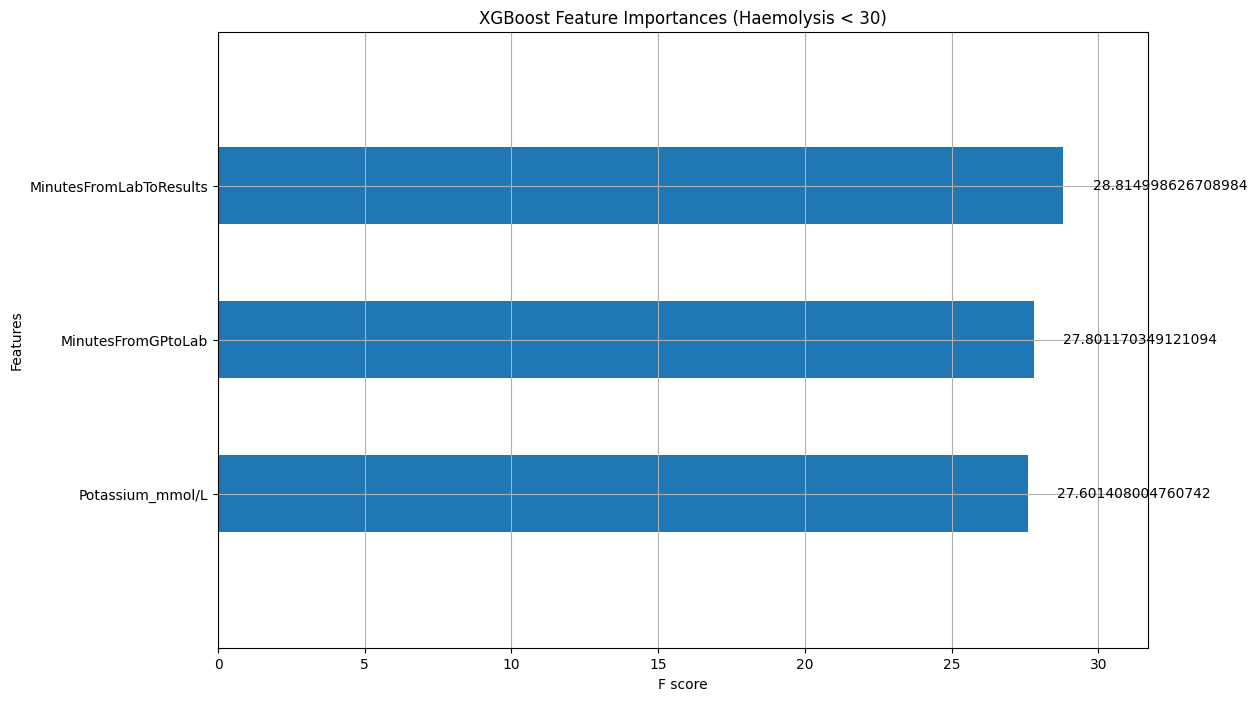

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# === 1. Filter rows where Haemolysis < 30 ===
filtered = merged[merged['Haemolysis'] < 15].copy()

# === 2. Define features and target ===
feature_cols = [
    'MinutesFromLabToResults',
    'MinutesFromGPtoLab',
    'Potassium_mmol/L'
]

X = filtered[feature_cols]
y = filtered['Haemolysis']

# === 3. Drop missing values ===
X = X.dropna()
y = y.loc[X.index]

# === 4. Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 5. Train XGBoost Regressor ===
xgbr = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgbr.fit(X_train, y_train)

# === 6. Predictions & Evaluation ===
y_pred = xgbr.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
acc1 = np.mean(np.abs(y_pred - y_test) <= 1)

print("\n=== XGBoost Performance (Haemolysis < 30) ===")
print(f"R²: {r2:.3f}")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"Accuracy within ±1 unit: {acc1:.2%}")

# === 7. Feature Importances ===
fi_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgbr.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n=== Feature Importances ===")
print(fi_df.to_string(index=False))

# === 8. Optional: Plot Feature Importances ===
xgb.plot_importance(xgbr, importance_type='gain', height=0.5)
plt.title("XGBoost Feature Importances (Haemolysis < 30)")
plt.show()


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# === 1. Filter Haemolysis < 30 and bin classes ===
filtered = merged[merged['Haemolysis'] < 30].copy()
bins = [-1, 3, 10, 30]
labels = ['Mild', 'Moderate', 'Severe']
filtered['Haemolysis_Class'] = pd.cut(filtered['Haemolysis'], bins=bins, labels=labels)

# === 2. Encode labels to integers ===
le = LabelEncoder()
filtered['Haemolysis_Label'] = le.fit_transform(filtered['Haemolysis_Class'])

# === 3. Define features and drop missing ===
feature_cols = ['MinutesFromLabToResults', 'MinutesFromGPtoLab', 'Potassium_mmol/L']
X = filtered[feature_cols].dropna()
y = filtered.loc[X.index, 'Haemolysis_Label']

# === 4. Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === 5. Compute class weights ===
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

# Create sample weights for each training sample
sample_weights = np.array([class_weight_dict[i] for i in y_train])

# === 6. Train XGBoost Classifier with sample weights ===
xgbc = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)

xgbc.fit(X_train, y_train, sample_weight=sample_weights)

# === 7. Evaluate ===
y_pred = xgbc.predict(X_test)

print("\n=== Classification Report (Weighted XGBoost) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=3))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# === 8. Feature Importances ===
fi_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgbc.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n=== Feature Importances ===")
print(fi_df.to_string(index=False))


Class Weights: {0: np.float64(1.4957575757575758), 1: np.float64(0.6151545363908275), 2: np.float64(1.4167623421354765)}

=== Classification Report (Weighted XGBoost) ===
              precision    recall  f1-score   support

        Mild      0.237     0.393     0.296       412
    Moderate      0.552     0.289     0.379      1004
      Severe      0.283     0.417     0.337       436

    accuracy                          0.342      1852
   macro avg      0.357     0.366     0.337      1852
weighted avg      0.419     0.342     0.351      1852

=== Confusion Matrix ===
[[162 141 109]
 [361 290 353]
 [160  94 182]]

=== Feature Importances ===
                Feature  Importance
       Potassium_mmol/L    0.358204
MinutesFromLabToResults    0.328232
     MinutesFromGPtoLab    0.313564


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import pandas as pd
import numpy as np

# === 1. Prepare data as before ===
filtered = merged[merged['Haemolysis'] < 30].copy()
bins = [-1, 3, 10, 30]
labels = ['Mild', 'Moderate', 'Severe']
filtered['Haemolysis_Class'] = pd.cut(filtered['Haemolysis'], bins=bins, labels=labels)

# Label encode
le = LabelEncoder()
filtered['Haemolysis_Label'] = le.fit_transform(filtered['Haemolysis_Class'])

# Feature set
feature_cols = ['MinutesFromLabToResults', 'MinutesFromGPtoLab', 'Potassium_mmol/L']
X = filtered[feature_cols].dropna()
filtered = filtered.loc[X.index]
y = filtered['Haemolysis_Label']

# === 2. Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === 3. Apply SMOTE ===
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# === 4. Train XGBoost ===
xgbc_smote = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)
xgbc_smote.fit(X_resampled, y_resampled)

# === 5. Evaluate ===
y_pred_smote = xgbc_smote.predict(X_test)

print("\n=== Classification Report (SMOTE) ===")
print(classification_report(y_test, y_pred_smote, target_names=le.classes_, digits=3))

print("=== Confusion Matrix (SMOTE) ===")
print(confusion_matrix(y_test, y_pred_smote))

# === 6. Feature Importances ===
fi_df_smote = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgbc_smote.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n=== Feature Importances (SMOTE) ===")
print(fi_df_smote.to_string(index=False))



=== Classification Report (SMOTE) ===
              precision    recall  f1-score   support

        Mild      0.257     0.044     0.075       412
    Moderate      0.544     0.855     0.665      1004
      Severe      0.328     0.154     0.209       436

    accuracy                          0.509      1852
   macro avg      0.376     0.351     0.316      1852
weighted avg      0.429     0.509     0.426      1852

=== Confusion Matrix (SMOTE) ===
[[ 18 365  29]
 [ 38 858 108]
 [ 14 355  67]]

=== Feature Importances (SMOTE) ===
                Feature  Importance
       Potassium_mmol/L    0.693042
     MinutesFromGPtoLab    0.153481
MinutesFromLabToResults    0.153478



🔍 SHAP summary for class: Mild


/tmp/ipython-input-65-1035894559.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[i], X_test, feature_names=X.columns, show=True, plot_type='bar')


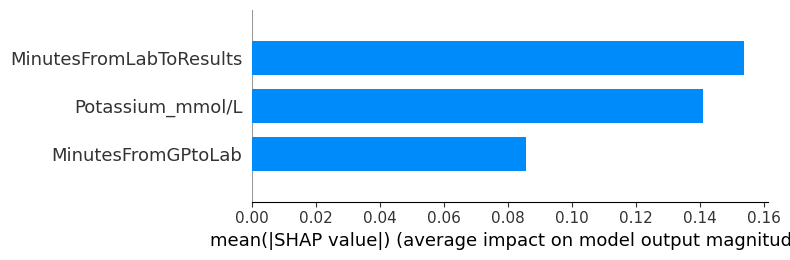


🔍 SHAP summary for class: Moderate


/tmp/ipython-input-65-1035894559.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[i], X_test, feature_names=X.columns, show=True, plot_type='bar')


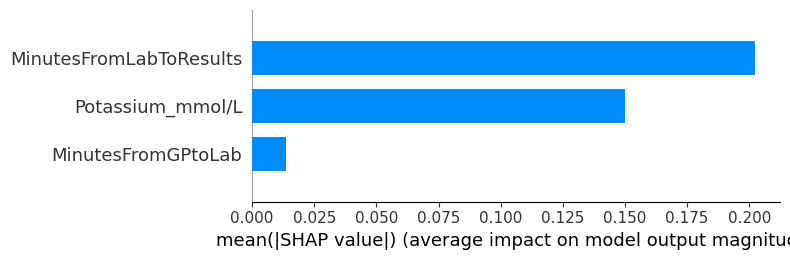


🔍 SHAP summary for class: Severe


/tmp/ipython-input-65-1035894559.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[i], X_test, feature_names=X.columns, show=True, plot_type='bar')


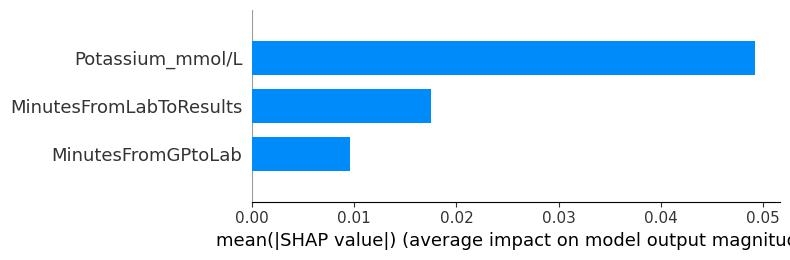

In [ ]:
import shap
import matplotlib.pyplot as plt

# === 1. Create TreeExplainer ===
explainer = shap.TreeExplainer(xgbc)  # xgbc = your trained XGBClassifier

# === 2. Compute SHAP values for test set ===
shap_values = explainer.shap_values(X_test)

# === 3. SHAP Summary plot (one per class) ===
class_names = le.classes_  # ['Mild', 'Moderate', 'Severe']
for i, class_name in enumerate(class_names):
    print(f"\n🔍 SHAP summary for class: {class_name}")
    shap.summary_plot(shap_values[i], X_test, feature_names=X.columns, show=True, plot_type='bar')


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import numpy as np
import pandas as pd

# === 1. Filter haemolysis < 30 and bin ===
filtered = merged[merged['Haemolysis'] < 30].copy()
bins = [-1, 3, 10, 30]
labels = ['Mild', 'Moderate', 'Severe']
filtered['Haemolysis_Class'] = pd.cut(filtered['Haemolysis'], bins=bins, labels=labels)

# === 2. Encode target
le = LabelEncoder()
filtered['Haemolysis_Label'] = le.fit_transform(filtered['Haemolysis_Class'])

# === 3. Select features
feature_cols = ['MinutesFromLabToResults', 'MinutesFromGPtoLab', 'Potassium_mmol/L']
X = filtered[feature_cols].dropna()
filtered = filtered.loc[X.index]
y = filtered['Haemolysis_Label']

# === 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === 5. Apply SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# === 6. Compute class weights *after* SMOTE
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_resampled),
    y=y_resampled
)
weight_dict = dict(enumerate(class_weights))

# Create per-sample weights
sample_weights = np.array([weight_dict[i] for i in y_resampled])

# === 7. Fit XGBoost classifier with sample weights
xgbc_combo = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)

xgbc_combo.fit(X_resampled, y_resampled, sample_weight=sample_weights)

# === 8. Evaluate on real test set
y_pred = xgbc_combo.predict(X_test)

print("\n=== Classification Report (SMOTE + Class Weights) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=3))

print("=== Confusion Matrix (SMOTE + Weights) ===")
print(confusion_matrix(y_test, y_pred))

# === 9. Feature importances
fi_df_combo = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgbc_combo.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n=== Feature Importances (SMOTE + Weights) ===")
print(fi_df_combo.to_string(index=False))



=== Classification Report (SMOTE + Class Weights) ===
              precision    recall  f1-score   support

        Mild      0.257     0.044     0.075       412
    Moderate      0.544     0.855     0.665      1004
      Severe      0.328     0.154     0.209       436

    accuracy                          0.509      1852
   macro avg      0.376     0.351     0.316      1852
weighted avg      0.429     0.509     0.426      1852

=== Confusion Matrix (SMOTE + Weights) ===
[[ 18 365  29]
 [ 38 858 108]
 [ 14 355  67]]

=== Feature Importances (SMOTE + Weights) ===
                Feature  Importance
       Potassium_mmol/L    0.693042
     MinutesFromGPtoLab    0.153481
MinutesFromLabToResults    0.153478


## Weighted XGB < 90

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# === 1. Filter Haemolysis < 90 and bin classes ===
filtered = merged[merged['Haemolysis'] < 90].copy()
bins = [-1, 3, 30, 90]
labels = ['Mild', 'Moderate', 'Severe']
filtered['Haemolysis_Class'] = pd.cut(filtered['Haemolysis'], bins=bins, labels=labels)

# === 2. Encode labels to integers ===
le = LabelEncoder()
filtered['Haemolysis_Label'] = le.fit_transform(filtered['Haemolysis_Class'])

# === 3. Define features and drop missing ===
feature_cols = ['MinutesFromLabToResults', 'MinutesFromGPtoLab', 'Potassium_mmol/L']
X = filtered[feature_cols].dropna()
y = filtered.loc[X.index, 'Haemolysis_Label']

# === 4. Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === 5. Compute class weights ===
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

# Create sample weights for each training sample
sample_weights = np.array([class_weight_dict[i] for i in y_train])

# === 6. Train XGBoost Classifier with sample weights ===
xgbc = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)

xgbc.fit(X_train, y_train, sample_weight=sample_weights)

# === 7. Evaluate ===
y_pred = xgbc.predict(X_test)

print("\n=== Classification Report (Haemolysis < 90) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=3))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# === 8. Feature Importances ===
fi_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgbc.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n=== Feature Importances ===")
print(fi_df.to_string(index=False))


Class Weights: {0: np.float64(1.5753535353535353), 1: np.float64(0.4505691338764662), 2: np.float64(6.858399296394019)}

=== Classification Report (Haemolysis < 90) ===
              precision    recall  f1-score   support

        Mild      0.249     0.498     0.332       412
    Moderate      0.725     0.304     0.428      1443
      Severe      0.076     0.421     0.129        95

    accuracy                          0.350      1950
   macro avg      0.350     0.407     0.296      1950
weighted avg      0.593     0.350     0.393      1950

=== Confusion Matrix ===
[[205 131  76]
 [598 438 407]
 [ 20  35  40]]

=== Feature Importances ===
                Feature  Importance
       Potassium_mmol/L    0.473007
MinutesFromLabToResults    0.271207
     MinutesFromGPtoLab    0.255786


## SMOTE Haemolysis < 90

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import pandas as pd
import numpy as np

# === 1. Filter Haemolysis < 90 and bin classes ===
filtered = merged[merged['Haemolysis'] < 90].copy()
bins = [-1, 3, 30, 90]
labels = ['Mild', 'Moderate', 'Severe']
filtered['Haemolysis_Class'] = pd.cut(filtered['Haemolysis'], bins=bins, labels=labels)


# Label encode
le = LabelEncoder()
filtered['Haemolysis_Label'] = le.fit_transform(filtered['Haemolysis_Class'])

# Feature set
feature_cols = ['MinutesFromLabToResults', 'MinutesFromGPtoLab', 'Potassium_mmol/L']
X = filtered[feature_cols].dropna()
filtered = filtered.loc[X.index]
y = filtered['Haemolysis_Label']

# === 2. Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === 3. Apply SMOTE ===
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# === 4. Train XGBoost ===
xgbc_smote = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)
xgbc_smote.fit(X_resampled, y_resampled)

# === 5. Evaluate ===
y_pred_smote = xgbc_smote.predict(X_test)

print("\n=== Classification Report (SMOTE < 90) ===")
print(classification_report(y_test, y_pred_smote, target_names=le.classes_, digits=3))

print("=== Confusion Matrix (SMOTE < 90) ===")
print(confusion_matrix(y_test, y_pred_smote))

# === 6. Feature Importances ===
fi_df_smote = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgbc_smote.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n=== Feature Importances (SMOTE < 90) ===")
print(fi_df_smote.to_string(index=False))



=== Classification Report (SMOTE < 90) ===
              precision    recall  f1-score   support

        Mild      0.236     0.051     0.084       412
    Moderate      0.741     0.894     0.811      1443
      Severe      0.107     0.137     0.120        95

    accuracy                          0.679      1950
   macro avg      0.362     0.361     0.338      1950
weighted avg      0.604     0.679     0.623      1950

=== Confusion Matrix (SMOTE < 90) ===
[[  21  372   19]
 [  64 1290   89]
 [   4   78   13]]

=== Feature Importances (SMOTE < 90) ===
                Feature  Importance
       Potassium_mmol/L    0.766682
MinutesFromLabToResults    0.128270
     MinutesFromGPtoLab    0.105048



🔍 SHAP summary for class: Mild


/tmp/ipython-input-69-1035894559.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[i], X_test, feature_names=X.columns, show=True, plot_type='bar')


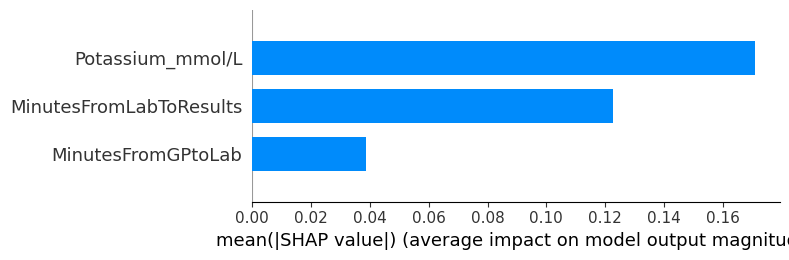


🔍 SHAP summary for class: Moderate


/tmp/ipython-input-69-1035894559.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[i], X_test, feature_names=X.columns, show=True, plot_type='bar')


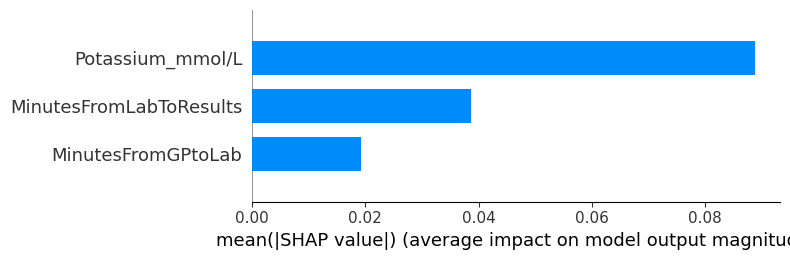


🔍 SHAP summary for class: Severe


/tmp/ipython-input-69-1035894559.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[i], X_test, feature_names=X.columns, show=True, plot_type='bar')


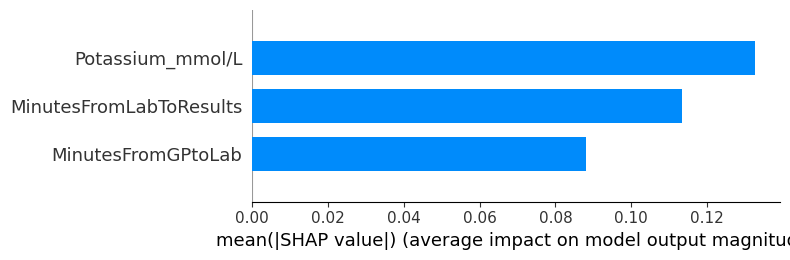

In [ ]:
import shap
import matplotlib.pyplot as plt

# === 1. Create TreeExplainer ===
explainer = shap.TreeExplainer(xgbc)  # xgbc = your trained XGBClassifier

# === 2. Compute SHAP values for test set ===
shap_values = explainer.shap_values(X_test)

# === 3. SHAP Summary plot (one per class) ===
class_names = le.classes_  # ['Mild', 'Moderate', 'Severe']
for i, class_name in enumerate(class_names):
    print(f"\n🔍 SHAP summary for class: {class_name}")
    shap.summary_plot(shap_values[i], X_test, feature_names=X.columns, show=True, plot_type='bar')


In [ ]:
print(filtered['Haemolysis_Class'].value_counts())


Haemolysis_Class
Moderate    7212
Mild        2062
Severe       474
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# === 1. Filter Haemolysis < 90 and bin classes ===
filtered = merged[merged['Haemolysis'] < 90].copy()
bins = [-1, 3, 30, 90]
labels = ['Mild', 'Moderate', 'Severe']
filtered['Haemolysis_Class'] = pd.cut(filtered['Haemolysis'], bins=bins, labels=labels)

# Drop missing Haemolysis_Class
filtered = filtered.dropna(subset=['Haemolysis_Class'])

# === 2. Label encode target ===
le = LabelEncoder()
filtered['Haemolysis_Label'] = le.fit_transform(filtered['Haemolysis_Class'])

# === 3. Encode categorical variables ===
# Use the original column names for one-hot encoding
categorical_cols = ['GP', 'Who delivered samples', 'Delivery Window'] # Using original column names
filtered = pd.get_dummies(filtered, columns=categorical_cols, drop_first=True)

# === 4. Define feature columns ===
# Include original numeric columns and the newly created one-hot encoded columns
feature_cols = [
    'MinutesFromGPtoLab',
    'MinutesFromLabToResults',
    'Potassium_mmol/L',
    'DistanceFromTUH_KM' # Include original numeric column
] + [col for col in filtered.columns if col.startswith(('GP_', 'Who delivered samples_', 'Delivery Window_'))]


X = filtered[feature_cols].dropna()
y = filtered.loc[X.index, 'Haemolysis_Label']

# === 5. Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# === 6. Apply SMOTE ===
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# === 7. Train XGBoost ===
xgbc_smote = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgbc_smote.fit(X_resampled, y_resampled)

# === 8. Evaluate ===
y_pred_smote = xgbc_smote.predict(X_test)

print("\n=== Classification Report (SMOTE < 90) ===")
print(classification_report(y_test, y_pred_smote, target_names=le.classes_, digits=3))

print("=== Confusion Matrix (SMOTE < 90) ===")
print(confusion_matrix(y_test, y_pred_smote))

# === 9. Feature Importances ===
fi_df_smote = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgbc_smote.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n=== Feature Importances (SMOTE < 90) ===")
print(fi_df_smote.to_string(index=False))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:55:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Classification Report (SMOTE < 90) ===
              precision    recall  f1-score   support

        Mild      0.375     0.029     0.054       412
    Moderate      0.743     0.972     0.842      1443
      Severe      0.207     0.063     0.097        95

    accuracy                          0.729      1950
   macro avg      0.442     0.355     0.331      1950
weighted avg      0.639     0.729     0.639      1950

=== Confusion Matrix (SMOTE < 90) ===
[[  12  398    2]
 [  19 1403   21]
 [   1   88    6]]

=== Feature Importances (SMOTE < 90) ===
                            Feature  Importance
         Who delivered samples_Taxi    0.052274
      Who delivered samples_Courier    0.050214
                            GP_GP40    0.039539
        Delivery Window_13.00-13.30    0.037126
        Delivery Window_14.30-15.00    0.032499
                   Potassium_mmol/L    0.030989
        Delivery Window_12.30-13.00    0.029561
                            GP_GP52    0.028415
        

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4048 - loss: 1.0727 - val_accuracy: 0.5222 - val_loss: 1.0264
Epoch 2/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4552 - loss: 1.0038 - val_accuracy: 0.4980 - val_loss: 1.0727
Epoch 3/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4585 - loss: 0.9924 - val_accuracy: 0.5459 - val_loss: 1.0150
Epoch 4/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4721 - loss: 0.9810 - val_accuracy: 0.5702 - val_loss: 0.9912
Epoch 5/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4736 - loss: 0.9794 - val_accuracy: 0.5869 - val_loss: 0.9792
Epoch 6/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4833 - loss: 0.9674 - val_accuracy: 0.5511 - val_loss: 1.0104
Epoch 7/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4860 - loss: 0.9703 - val_accuracy: 0.4876 - val_loss: 1.0570
Epoch 8/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4875 - loss: 0.9644 - val_accuracy: 0

PermutationExplainer explainer: 101it [00:16,  3.30it/s]
/tmp/ipython-input-72-2487994911.py:79: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[..., 1], features=X_test.iloc[:100], feature_names=X.columns)


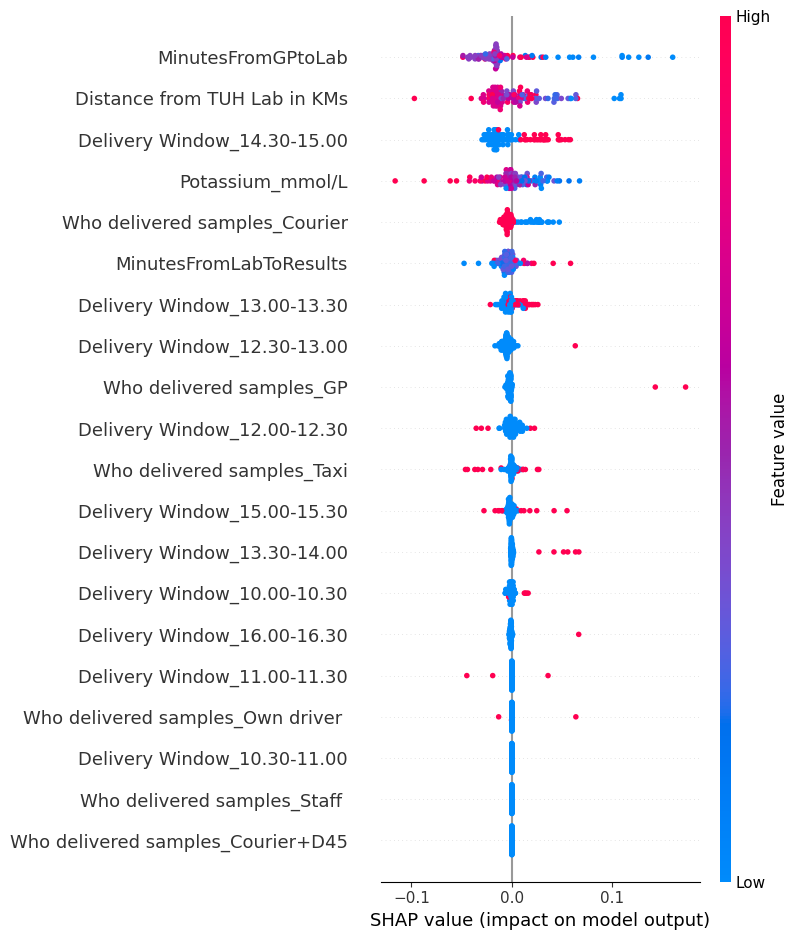

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import shap
import matplotlib.pyplot as plt

# === 1. Filter Haemolysis < 90 and Bin Classes ===
filtered = merged[merged['Haemolysis'] < 90].copy()
bins = [-1, 3, 30, 90]
labels = ['Mild', 'Moderate', 'Severe']
filtered['Haemolysis_Class'] = pd.cut(filtered['Haemolysis'], bins=bins, labels=labels)

# === 2. Encode target ===
le = LabelEncoder()
filtered['Haemolysis_Label'] = le.fit_transform(filtered['Haemolysis_Class'])

# === 3. Select features ===
categorical_cols = ['Distance from TUH Lab in KMs', 'Who delivered samples', 'Delivery Window']
numeric_cols = ['MinutesFromGPtoLab', 'MinutesFromLabToResults', 'Potassium_mmol/L']
filtered = filtered.dropna(subset=numeric_cols + categorical_cols + ['Haemolysis_Label'])

# One-hot encode categoricals
X_cat = pd.get_dummies(filtered[categorical_cols], drop_first=True)
X_num = filtered[numeric_cols]
X = pd.concat([X_num, X_cat], axis=1)
y = filtered['Haemolysis_Label']

# === 4. Split and Scale ===
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Apply SMOTE ===
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)

# === 6. Prepare for Keras ===
y_res_cat = to_categorical(y_resampled)
y_test_cat = to_categorical(y_test)

# === 7. Define MLP ===
model = Sequential([
    Dense(128, input_dim=X_resampled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === 8. Train ===
model.fit(X_resampled, y_res_cat, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

# === 9. Evaluate ===
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n=== Classification Report (SMOTE + MLP) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=3))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# === 10. SHAP Explainability ===
explainer = shap.Explainer(model, X_train_scaled, feature_names=X.columns.tolist())
shap_values = explainer(X_test_scaled[:100])

# Summary Plot (Class 0 = Mild, Class 1 = Moderate, Class 2 = Severe)
shap.summary_plot(shap_values[..., 1], features=X_test.iloc[:100], feature_names=X.columns)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


339/339 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.3625 - loss: 1.3238 - val_accuracy: 0.3447 - val_loss: 1.1767
Epoch 2/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3676 - loss: 1.1272 - val_accuracy: 0.3297 - val_loss: 1.2104
Epoch 3/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3924 - loss: 1.0882 - val_accuracy: 0.2874 - val_loss: 1.2319
Epoch 4/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4027 - loss: 1.0716 - val_accuracy: 0.2076 - val_loss: 1.2699
Epoch 5/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4033 - loss: 1.0664 - val_accuracy: 0.1919 - val_loss: 1.2375
Epoch 6/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4180 - loss: 1.0602 - val_accuracy: 0.2409 - val_loss: 1.2259
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

=== Classification Report (SMOTE + MLP) ===
              precision    recall  f1-score   support

        Mild      0.255     0.352     0.296       412
    Moderate      0.557     0.475     0.513

PermutationExplainer explainer: 101it [00:22,  2.70it/s]
/tmp/ipython-input-76-1921692595.py:99: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[..., 1], features=sample_df, feature_names=X.columns, show=True)


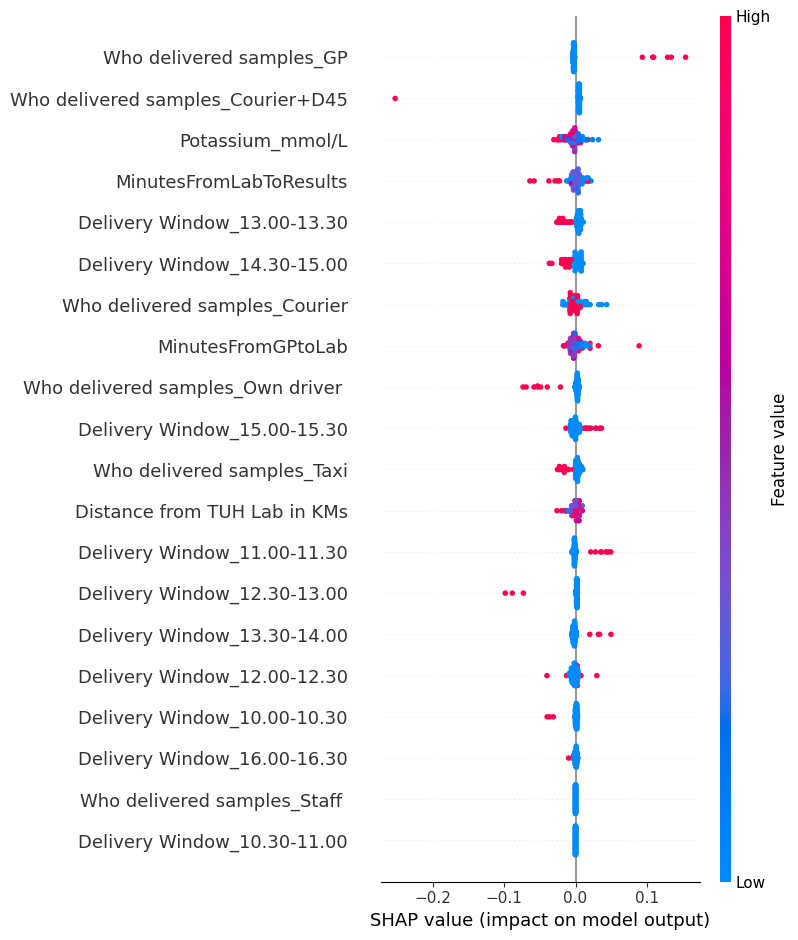

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import shap
import matplotlib.pyplot as plt

# === 1. Filter Haemolysis < 90 and Bin Classes ===
filtered = merged[merged['Haemolysis'] < 30].copy()
bins = [-1, 3, 10, 30]
labels = ['Mild', 'Moderate', 'Severe']
filtered['Haemolysis_Class'] = pd.cut(filtered['Haemolysis'], bins=bins, labels=labels)

# === 2. Encode target ===
le = LabelEncoder()
filtered['Haemolysis_Label'] = le.fit_transform(filtered['Haemolysis_Class'])

# === 3. Select features ===
categorical_cols = ['Distance from TUH Lab in KMs', 'Who delivered samples', 'Delivery Window']
numeric_cols = ['MinutesFromGPtoLab', 'MinutesFromLabToResults', 'Potassium_mmol/L']
filtered = filtered.dropna(subset=numeric_cols + categorical_cols + ['Haemolysis_Label'])

# One-hot encode categoricals
X_cat = pd.get_dummies(filtered[categorical_cols], drop_first=True)
X_num = filtered[numeric_cols]
X = pd.concat([X_num, X_cat], axis=1)
y = filtered['Haemolysis_Label']

# === 4. Train/Test Split and Scaling ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Apply SMOTE ===
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)

# === 6. Convert Labels for Keras ===
y_res_cat = to_categorical(y_resampled)
y_test_cat = to_categorical(y_test)

# === 7. Define MLP ===
model = Sequential([
    Dense(256, input_dim=X_resampled.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  # 3 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === 8. Train with Early Stopping ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_resampled, y_res_cat,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# === 9. Evaluate ===
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n=== Classification Report (SMOTE + MLP) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=3))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# === 10. SHAP Explainability ===
# SHAP expects a smaller sample, otherwise it will be slow
sample_X = X_test_scaled[:100]
sample_df = X_test.iloc[:100]

explainer = shap.Explainer(model, X_train_scaled, feature_names=X.columns.tolist())
shap_values = explainer(sample_X)

# Visualize impact on Moderate class (class index = 1)
shap.summary_plot(shap_values[..., 1], features=sample_df, feature_names=X.columns, show=True)


In [ ]:
# === Add Route Info to merged ===
import pandas as pd

# Load the courier route file
routes = pd.read_excel("routes.xlsx")

# Normalize text
routes['Who delivered samples'] = routes['Who delivered samples'].str.lower().str.strip()

# Define valid courier types
valid_couriers = ['courier', 'courier/taxis', 'courier+d45']
routes['IsCourierDelivery'] = routes['Who delivered samples'].isin(valid_couriers).astype(int)

# Assign route order
courier_only = routes[routes['IsCourierDelivery'] == 1].drop_duplicates(subset='GP').copy()
courier_only['Route_Order'] = range(1, len(courier_only) + 1)

# Merge back to main dataset
route_info = courier_only[['GP', 'Route_Order']].merge(
    routes[['GP', 'IsCourierDelivery']], on='GP', how='right'
).drop_duplicates(subset='GP')

merged = merged.merge(route_info, on='GP', how='left')
merged['Route_Order'] = merged['Route_Order'].fillna(-1).astype(int)
merged['IsCourierDelivery'] = merged['IsCourierDelivery'].fillna(0).astype(int)


In [ ]:
merged.head(50)

,DateSampleTaken,TimeSampleTaken,DateReceivedLab,TimeReceivedLab,DateResultReported,TimeResultReported,GP,DistanceFromTUH_KM,Potassium_mmol/L,Haemolysis,...,MinutesFromGPtoLab,MinutesFromLabToResults,HaemolysisScore,Results,Distance from TUH Lab in KMs,Est time collected from practice,Who delivered samples,Delivery Window,Route_Order,IsCourierDelivery
0,2023-02-13,18:22:00,2023-02-13,18:22:00,2023-02-15,09:18:00,GP51,1.3,4.2,3,...,215.0,2336.0,0,8,1.3,Unknown,Courier,12.00-12.30,12,1
1,2023-02-09,11:00:00,2023-02-09,16:50:00,2023-02-10,14:19:00,GP01,1.1,3.8,6,...,350.0,1639.0,0,8,1.1,10.00am - 11.50am,Courier,12.00-12.30,11,1
2,2023-01-17,09:45:00,2023-01-17,15:56:00,2023-01-18,15:31:00,GP33,6.5,3.9,4,...,371.0,1786.0,0,8,6.5,09.30 - 11.40,Courier,16.00-16.30,42,1
3,2023-01-11,16:16:00,2023-01-11,16:47:00,2023-01-12,12:18:00,GP10,5.7,4.8,11,...,31.0,1202.0,0,8,5.7,Unknown,Courier,14.30-15.00,23,1
4,2023-01-23,12:44:00,2023-01-23,14:01:00,2023-01-23,15:26:00,GP40,7.8,4.3,36,...,77.0,162.0,0,8,7.8,Unknown,Courier,14.30-15.00,28,1
5,2023-02-17,12:27:00,2023-02-17,12:27:00,2023-02-20,10:11:00,GP58,5.5,6.2,5,...,215.0,4184.0,0,2,5.5,Unknown,Courier,12.00-12.30,7,1
6,2023-01-11,16:07:00,2023-01-11,16:47:00,2023-01-12,08:54:00,GP31,2.4,3.9,6,...,40.0,1007.0,0,8,2.4,10.19am - 11.37am,Courier,12.00-12.30,10,1
7,2023-02-07,15:15:00,2023-02-07,15:15:00,2023-02-08,16:38:00,GP39,6.4,3.7,5,...,215.0,1523.0,0,8,6.4,09.00 - 11.30,Courier,14.30-15.00,25,1
8,2023-02-20,16:07:00,2023-02-20,16:07:00,2023-02-21,08:47:00,GP12,4.3,4.5,16,...,215.0,1000.0,0,8,4.3,9,Courier,14.30-15.00,31,1
9,2023-01-30,10:10:00,2023-01-30,17:52:00,2023-01-31,10:05:00,GP31,2.4,4.6,7,...,462.0,1435.0,0,8,2.4,10.19am - 11.37am,Courier,12.00-12.30,10,1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.3468 - loss: 1.4183 - val_accuracy: 0.3279 - val_loss: 1.1160
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3384 - loss: 1.1933 - val_accuracy: 0.3657 - val_loss: 1.1034
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3625 - loss: 1.1334 - val_accuracy: 0.3333 - val_loss: 1.0870
Epoch 4/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3396 - loss: 1.1252 - val_accuracy: 0.3657 - val_loss: 1.0740
Epoch 5/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3543 - loss: 1.1008 - val_accuracy: 0.3050 - val_loss: 1.0998
Epoch 6/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3407 - loss: 1.0904 - val_accuracy: 0.3387 - val_loss: 1.0775
Epoch 7/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3453 - loss: 1.0809 - val_accuracy: 0.3576 - val_loss: 1.0710
Epoch 8/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3598 - loss: 1.0852 - val_ac

PermutationExplainer explainer: 101it [00:20,  3.10it/s]
/tmp/ipython-input-45-3748466514.py:96: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[..., 1], features=sample_df, feature_names=X.columns, show=True)


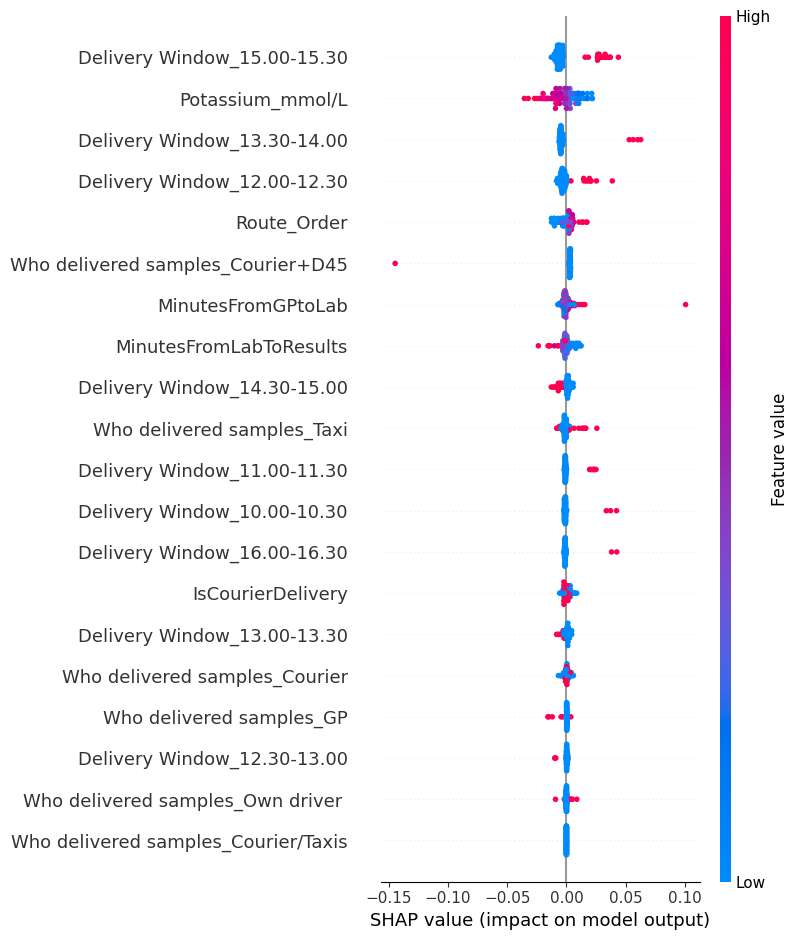

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import shap
import matplotlib.pyplot as plt

# === 1. Filter Haemolysis < 90 and Bin Classes ===
filtered = merged[merged['Haemolysis'] < 30].copy()
bins = [-1, 3, 10, 30]
labels = ['Mild', 'Moderate', 'Severe']
filtered['Haemolysis_Class'] = pd.cut(filtered['Haemolysis'], bins=bins, labels=labels)

# === 2. Encode target ===
le = LabelEncoder()
filtered['Haemolysis_Label'] = le.fit_transform(filtered['Haemolysis_Class'])

# === 3. Select features (with new route features) ===
categorical_cols = ['Who delivered samples', 'Delivery Window',
    'Route_Order', 'IsCourierDelivery']
numeric_cols = [
    'MinutesFromGPtoLab', 'MinutesFromLabToResults', 'Potassium_mmol/L',
]
filtered = filtered.dropna(subset=numeric_cols + categorical_cols + ['Haemolysis_Label'])

# One-hot encode categoricals
X_cat = pd.get_dummies(filtered[categorical_cols], drop_first=True)
X_num = filtered[numeric_cols]
X = pd.concat([X_num, X_cat], axis=1)
y = filtered['Haemolysis_Label']  # Do NOT one-hot encode

# === 4. Train/Test Split and Scaling ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Compute Class Weights ===
cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(cw))

# === 6. Define MLP ===
model = Sequential([
    Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  # 3 classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# === 7. Train with Early Stopping ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_train_scaled, y_train,  # y_train is NOT one-hot
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)

# === 8. Evaluate ===
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n=== Classification Report (class_weight + MLP) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=3))
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# === 9. SHAP Explainability ===
sample_X = X_test_scaled[:100]
sample_df = X_test.iloc[:100]

explainer = shap.Explainer(model, X_train_scaled, feature_names=X.columns.tolist())
shap_values = explainer(sample_X)

# Visualize impact on Moderate class (index = 1)
shap.summary_plot(shap_values[..., 1], features=sample_df, feature_names=X.columns, show=True)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.5125 - loss: 0.8098 - val_accuracy: 0.4615 - val_loss: 0.7136
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5435 - loss: 0.7154 - val_accuracy: 0.5587 - val_loss: 0.7015
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5329 - loss: 0.7287 - val_accuracy: 0.5722 - val_loss: 0.7002
Epoch 4/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5644 - loss: 0.7040 - val_accuracy: 0.5951 - val_loss: 0.6908
Epoch 5/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5804 - loss: 0.6700 - val_accuracy: 0.4615 - val_loss: 0.7633
Epoch 6/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5417 - loss: 0.6694 - val_accuracy: 0.5938 - val_loss: 0.6915
Epoch 7/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5793 - loss: 0.6874 - val_accuracy: 0.5870 - val_loss: 0.6703
Epoch 8/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5632 - loss: 0.6810 - val_accuracy: 0.5

PermutationExplainer explainer: 101it [00:15,  2.51it/s]
/tmp/ipython-input-46-4285360643.py:100: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=sample_df, feature_names=X.columns, show=True)


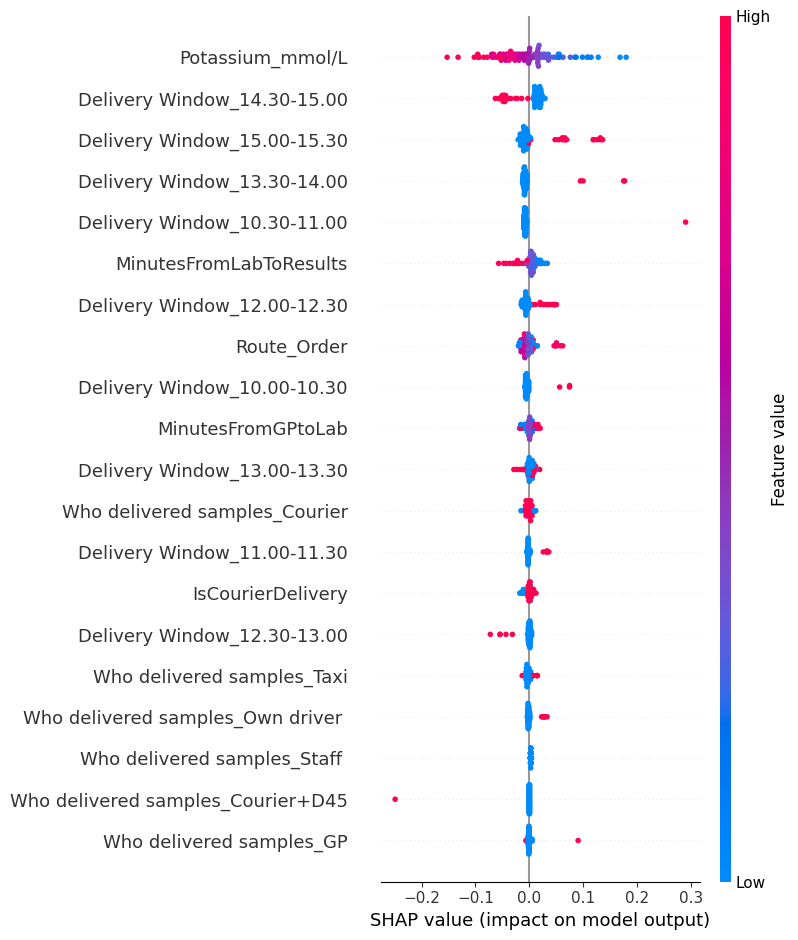

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import shap
import matplotlib.pyplot as plt
class_weights = {0: 1.0, 1: 50.0}  # assuming class 1 is “High”



# === 1. Filter Haemolysis < 90 and Bin into 2 Classes: Low vs High ===
filtered = merged[merged['Haemolysis'] < 30].copy()
bins = [-1, 15, 30]  # Two bins: <=3 is Low, >3 is High
labels = ['Low', 'High']
filtered['Haemolysis_Class'] = pd.cut(filtered['Haemolysis'], bins=bins, labels=labels)


# === 2. Encode target ===
le = LabelEncoder()
filtered['Haemolysis_Label'] = le.fit_transform(filtered['Haemolysis_Class'])

# === 3. Select features (with new route features) ===
categorical_cols = ['Who delivered samples', 'Delivery Window',
    'Route_Order', 'IsCourierDelivery']
numeric_cols = [
    'MinutesFromGPtoLab', 'MinutesFromLabToResults', 'Potassium_mmol/L',
]
filtered = filtered.dropna(subset=numeric_cols + categorical_cols + ['Haemolysis_Label'])

# One-hot encode categoricals
X_cat = pd.get_dummies(filtered[categorical_cols], drop_first=True)
X_num = filtered[numeric_cols]
X = pd.concat([X_num, X_cat], axis=1)
y = filtered['Haemolysis_Label']  # Do NOT one-hot encode

# === 4. Train/Test Split and Scaling ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Compute Class Weights ===
cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(cw))

# === 6. Define MLP ===
# === 6. Define Binary MLP ===
model = Sequential([
    Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === 7. Train with Early Stopping ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_train_scaled, y_train,  # y_train is NOT one-hot
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)
# === 8. Evaluate ===
y_pred_probs = model.predict(X_test_scaled)
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int).reshape(-1)

print("\n=== Classification Report (Binary) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=3))
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# === 9. SHAP Explainability ===
sample_X = X_test_scaled[:100]
sample_df = X_test.iloc[:100]

explainer = shap.Explainer(model, X_train_scaled, feature_names=X.columns.tolist())
shap_values = explainer(sample_X)

# Visualize impact on Moderate class (index = 1)
shap.summary_plot(shap_values, features=sample_df, feature_names=X.columns, show=True)


In [ ]:
print(filtered['Haemolysis_Class'].value_counts())


Haemolysis_Class
Low     903
High    903
Name: count, dtype: int64


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.5361 - loss: 0.8253 - val_accuracy: 0.5862 - val_loss: 0.6738
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5619 - loss: 0.7388 - val_accuracy: 0.6069 - val_loss: 0.6707
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5467 - loss: 0.7521 - val_accuracy: 0.5862 - val_loss: 0.6720
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5523 - loss: 0.7473 - val_accuracy: 0.6069 - val_loss: 0.6657
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5531 - loss: 0.7376 - val_accuracy: 0.6000 - val_loss: 0.6617
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6134 - loss: 0.6906 - val_accuracy: 0.6207 - val_loss: 0.6617
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5858 - loss: 0.7187 - val_accuracy: 0.5931 - val_loss: 0.6651
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5559 - loss: 0.7123 - val_accuracy: 0.6207 - val_loss: 0

PermutationExplainer explainer: 101it [00:12,  1.49it/s]
/tmp/ipython-input-56-1506447787.py:96: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=sample_df, feature_names=X.columns, show=True)


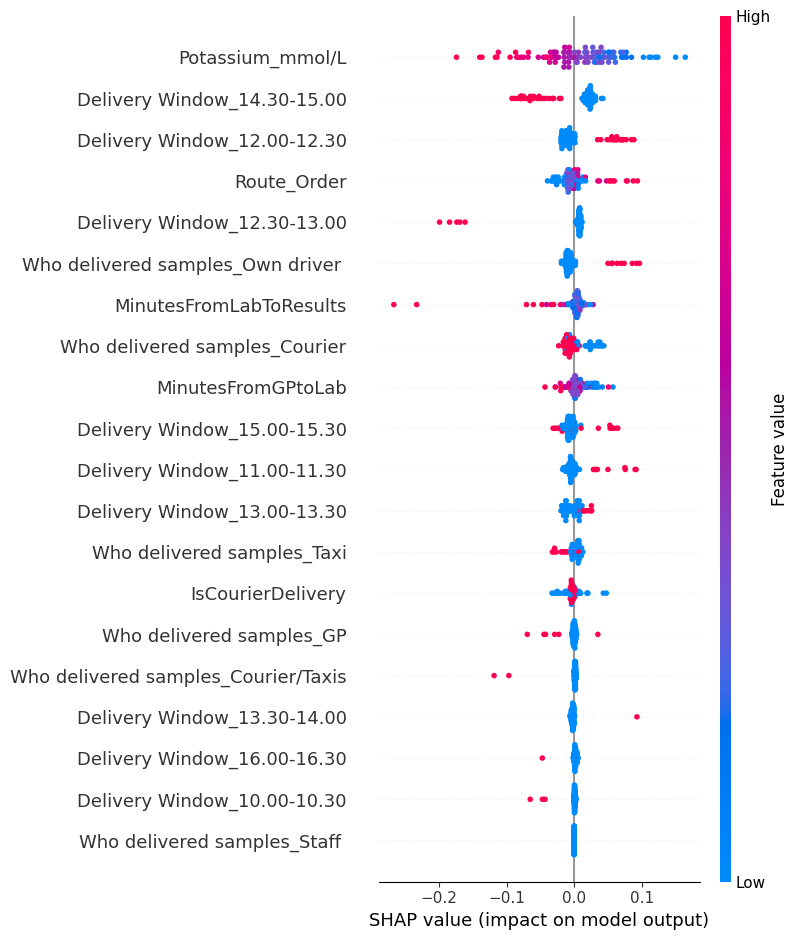

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import shap
import matplotlib.pyplot as plt

# === 1. Filter Haemolysis < 30 and Bin into 2 Classes: Low vs High ===
filtered = merged[merged['Haemolysis'] < 30].copy()
bins = [-1, 15, 30]  # Two bins: <=15 is Low, >15 is High
labels = ['Low', 'High']
filtered['Haemolysis_Class'] = pd.cut(filtered['Haemolysis'], bins=bins, labels=labels)

# === 2. Encode target ===
le = LabelEncoder()
filtered['Haemolysis_Label'] = le.fit_transform(filtered['Haemolysis_Class'])

# === 2b. Balance the dataset via undersampling (Low -> 903 samples) ===
low_df = filtered[filtered['Haemolysis_Class'] == 'Low'].sample(n=903, random_state=42)
high_df = filtered[filtered['Haemolysis_Class'] == 'High']
balanced = pd.concat([low_df, high_df]).sample(frac=1, random_state=42)  # Shuffle
filtered = balanced  # Use balanced dataset

# === 3. Select features (with new route features) ===
categorical_cols = ['Who delivered samples', 'Delivery Window',
    'Route_Order', 'IsCourierDelivery']
numeric_cols = [
    'MinutesFromGPtoLab', 'MinutesFromLabToResults', 'Potassium_mmol/L',
]
filtered = filtered.dropna(subset=numeric_cols + categorical_cols + ['Haemolysis_Label'])

# One-hot encode categoricals
X_cat = pd.get_dummies(filtered[categorical_cols], drop_first=True)
X_num = filtered[numeric_cols]
X = pd.concat([X_num, X_cat], axis=1)
y = filtered['Haemolysis_Label']  # Do NOT one-hot encode

# === 4. Train/Test Split and Scaling ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# === 6. Define Binary MLP ===
model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === 7. Train with Early Stopping ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_train_scaled, y_train,  # y_train is NOT one-hot
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)

# === 8. Evaluate ===
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

print("\n=== Classification Report (Binary) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=3))
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# === 9. SHAP Explainability ===
sample_X = X_test_scaled[:100]
sample_df = X_test.iloc[:100]

explainer = shap.Explainer(model, X_train_scaled, feature_names=X.columns.tolist())
shap_values = explainer(sample_X)

shap.summary_plot(shap_values, features=sample_df, feature_names=X.columns, show=True)
